In [38]:
# %% General
import warnings
warnings.filterwarnings ( "ignore" )
import os
from datetime import datetime,timedelta,date  #time,
import matplotlib.pyplot as plt
from IPython.display import display


# Scientific and data
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import griddata
eps = np.finfo(np.float).eps
from scipy.stats import multivariate_normal
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import signal

# Local modules
import  learning_lidar.global_settings as gs
import learning_lidar.preprocessing.preprocessing as prep

In [39]:
def get_gen_dataset_file_name(station, day_date, wavelength='*', data_source='lidar', file_type = 'range_corr'):
    """
     Retrieves file pattern name of generated lidar dataset according to:
      station, date, wavelength.
    :param station: gs.station() object of the lidar station
    :param day_date: datetime.datetime object of the generated date
    :param wavelength: wavelength [nm] e.g., for the green channel 532 [nm] or all (meaning the dataset contains all elastic wavelengths)
    :param data_source: string object: 'aerosol' or 'lidar'
    :param file_type: string object: e.g., 'range_corr'/'lidar_power' for separated files per wavelength (355,532, or 1064) or 'lidar'/'aerosol' for all wavelengths

    :return: dataset file name (netcdf) file of the data_type required per given day and wavelength, data_source and file_type
    """
    if wavelength == '*':
        file_name = f"{day_date.strftime('%Y_%m_%d')}_{station.location}_generated_{data_source}.nc"
    else:
        file_name = f"{day_date.strftime('%Y_%m_%d')}_{station.location}_generated_{file_type}_{wavelength}_{data_source}.nc"

    return (file_name)

def save_generated_dataset(station, dataset, data_source ='lidar' ,save_mode='both'):
    """
	Save the input dataset to netcdf file
	:param station: station: gs.station() object of the lidar station
	:param dataset: array.Dataset() a daily generated lidar signal, holding 5 data variables:
			 4 daily dataset, with dimensions of : Height, Time, Wavelength.
			  name of profiles: 'range_corr','range_corr_p', 'lidar_sig','lidar_sig_p'
			 1 shared variable: date
    :param data_source: source type of the file, i.e., 'lidar' - for lidar dataset, and 'aerosol' - aerosols dataset.
	:param save_mode: save mode options:
					'sep' - for separated profiles (each is file is per profile per wavelength)
					'single' - save the dataset a single file per day
					'both' -saving both options
	:return: ncpaths - the paths of the saved dataset/s . None - for failure.
	"""
    date_datetime = prep.get_daily_ds_date(dataset)
    if data_source=='lidar':
        base_folder = station.gen_lidar_dataset
    elif data_source=='aerosol':
        base_folder = station.gen_aerosol_dataset
    else:
        base_folder = station.generation_folder
    month_folder = prep.get_month_folder_name(base_folder, date_datetime)

    prep.get_daily_ds_date(dataset)
    '''save the dataset to separated netcdf files: per profile per wavelength'''
    ncpaths = []

    # NOTE: Currently saving to separated profiles is only for `range_corr_p` - used in the learning phase.cur_day
    # if one needs other separated profile, add it as an an input term.
    profile = list(dataset.data_vars)[1]
    if save_mode in ['both', 'sep']:
        for wavelength in dataset.Wavelength.values:
            ds_profile = dataset.sel(Wavelength=wavelength)[profile]
            ds_profile['date'] = date_datetime
            file_name = get_gen_dataset_file_name(station, date_datetime, data_source=data_source,
                                                   wavelength = wavelength , file_type=profile)
            ncpath = prep.save_dataset(ds_profile, month_folder, file_name)
            if ncpath:
                ncpaths.append(ncpath)

    '''save the dataset to a single netcdf'''
    if save_mode in ['both', 'single']:
        file_name = get_gen_dataset_file_name(station, date_datetime, data_source=data_source,
                                               wavelength='*')
        ncpath = prep.save_dataset(dataset, month_folder, file_name)
        if ncpath:
            ncpaths.append(ncpath)
    return  ncpaths

In [40]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#sns.set_context('notebook')
#sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
timeformat = mdates.DateFormatter('%H:%M')
wavelengts = [355,532,1064]
colors = ["darkblue", "darkgreen","darkred"]

sns.set_palette(sns.color_palette(colors))
customPalette = sns.set_palette(sns.color_palette(colors))

In [41]:
# %%
def dt2binscale(dt_time, res_sec = 30):
	"""
	Returns the bin index corresponds to dt_time
	binscale - is the time scale [0,2880], of a daily lidar bin index from 00:00:00 to 23:59:30.
	The lidar has a bin measure every 30 sec, in total 2880 bins per day.
	:param dt_time: datetime.datetime object
	:return: binscale - float in [0,2880]
	"""
	res_minute = 60/res_sec
	res_hour = 60*res_minute
	res_musec = (1e-6)/res_sec
	tind = dt_time.hour*res_hour + dt_time.minute*res_minute + dt_time.second/res_sec + dt_time.microsecond*res_musec
	return tind

def get_random_sample_grid(nx,ny,orig_x, orig_y,std_ratio=.125):
	delta_x = (orig_x[-1]-orig_x[0])/nx
	delta_y = (orig_y[-1]-orig_y[0])/ny

	# generate a new grid (points are set to be in the middle of each patch)
	center_x = .5*delta_x + (np.arange(nx)*delta_x).astype(int).reshape((1,nx)).repeat(ny,axis=0) + orig_x[0]
	center_y = .5*delta_y + (np.arange(ny)*delta_y).astype(int).reshape((ny,1)).repeat(nx,axis=1) + orig_y[0]

	# set random distances from centers of the new grid
	dx = (std_ratio*delta_x*np.random.randn(nx,ny)).astype(int).T
	dy = (std_ratio*delta_y*np.random.randn(nx,ny)).astype(int).T

	# set random point in each patch of the new grid
	points_x = center_x + dx
	points_y = center_y + dy

	new_grid = {'x': center_x.flatten(),'y':center_y.flatten()}
	sample_points = {'x': points_x.flatten(),'y':points_y.flatten()}
	return  new_grid,sample_points

def get_random_cov_mat(lbound_x = .5 , lbound_y=.1):
	# generating covariance matrix with higher x diagonal of gaussian
	# set : lbound_x< std_x <= 1
	std_x = 1 - lbound_x*np.random.rand()
	# set : lbound_y < std_y <= std_x
	std_y = std_x - (std_x-lbound_y)*np.random.rand()
	# %%
	# generate random correlation [-1,1]
	# this is to make sure that the covariance matrix is PSD : std_x*std_y - std_xy*std_xy >= 0
	rho = -1 + 2*np.random.rand()
	std_xy = rho*std_y*std_x
	cov = np.array([[std_x,std_xy],[std_xy,std_y]])
	return cov

def make_interpolated_image(nsamples,im):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """
    nx, ny = im.shape[1], im.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method = 'nearest',fill_value = 0)
    return int_im

def create_gaussians_level(grid,nx,ny,grid_x,grid_y,std_ratio=.125,choose_ratio = 1.0,
                           cov_size = 1E-5, cov_r_lbounds=[.8,.1]):

	# create centers of Gaussians:
	new_grid,sample_points = get_random_sample_grid(nx,ny,grid_x,grid_y,std_ratio)
	if choose_ratio<1.0:
		center_x, _, center_y, _ = train_test_split(sample_points['x'],sample_points['y'],
		                                                    train_size = choose_ratio,shuffle = True)
	else:
		center_x = sample_points['x']
		center_y = sample_points['y']

	# Create covariance to each gaussian and adding each
	Z_level = np.zeros((grid.shape[0],grid.shape[1]))
	for x0,y0 in zip(center_x,center_y):
		cov = cov_size*get_random_cov_mat(lbound_x = cov_r_lbounds[0] , lbound_y=cov_r_lbounds[1])
		rv = multivariate_normal((x0,y0), cov)
		Z_level += rv.pdf(grid)
	# normalizing:
	Z_level = (Z_level - Z_level.min())/(Z_level.max() - Z_level.min())
	return Z_level

def angstrom(tau_1,tau_2, lambda_1,lambda_2):
	"""
	calculates angstrom exponent
	:param tau_1: AOD Aerosol optical depth at wavelength lambda_1
	:param tau_2: AOD Aerosol optical depth at wavelength lambda_2
	:param lambda_1: wavelength lambda_1 , lambda_1<lambda_2 (e.g. 355 nm)
	:param lambda_2: wavelength lambda_2 , lambda_1<lambda_2 (e.g. 532 nm)
	:return: angstrom exponent A_1,2
	"""
	return -np.log(tau_1/tau_2)/np.log(lambda_1/lambda_2)

def get_sub_sample_level (level, source_indexes, target_indexes):
	z_samples = level[:,source_indexes]
	df_sigma= pd.DataFrame(z_samples,columns = target_indexes)
	interp_sigma_df = (df_sigma.T.resample( '30S' ).interpolate ( method = 'linear' )).T
	sampled_interp = interp_sigma_df.values
	sampled_interp=(sampled_interp-sampled_interp.min())/(sampled_interp.max()-sampled_interp.min())
	return sampled_interp

def normalize(x,max_value=1):
	return max_value*(x-x.min())/(x.max()-x.min())
# %%

In [42]:
# Station parameters
PLOT_RESULTS = True
station_name = 'haifa'
station = gs.Station (  station_name = station_name )
#folder_name = 'D:\data_haifa\GENERATION'

month = 9
year = 2017
monthdays = (date(year,month+1,1)-date(year,month,1)).days
month_start_day = datetime(year,month,1,0,0)
month_end_day = datetime(year,month,monthdays,0,0)
nc_name = f"generated_density_params_{station.name}_{month_start_day.strftime('%Y-%m-%d')}_{month_end_day.strftime('%Y-%m-%d')}.nc"
gen_source_path = os.path.join(station.generation_folder,nc_name)
ds_month_params = prep.load_dataset(gen_source_path)

cur_day = datetime(2017,9,2,0,0)
ds_day_params = ds_month_params.sel(Time=slice(cur_day,cur_day+timedelta(days = 1)))
LR_tropos = 55
ref_height = np.float(ds_day_params.rm.sel(Time=cur_day).values)
sigma_532_max = np.float(ds_day_params.beta532.sel(Time=cur_day).values) * LR_tropos
ang_532_10264 = np.float(ds_day_params.ang5321064.sel(Time=cur_day).values)
ang_355_532 = np.float(ds_day_params.ang355532.sel(Time=cur_day).values)
LR = np.float(ds_day_params.LR.sel(Time=cur_day).values)

km_scale = 1E-3
min_height = station.altitude + station.start_bin_height
top_height = station.altitude + station.end_bin_height
heights = np.linspace ( min_height * km_scale , top_height * km_scale , station.n_bins )
dr = heights[1]-heights[0] # 7.4714e-3

end_t = cur_day+timedelta(hours = 24)-timedelta(seconds = 30)
time_index = pd.date_range(start = cur_day,end = end_t,freq = '30S')
total_time_bins = len(time_index) #2880


In [43]:
ref_height_bin = np.int(ref_height/dr)
total_bins = station.n_bins
x = np.arange(total_time_bins)
y = np.arange(total_bins)
X, Y = np.meshgrid(x,y,indexing = 'xy')
grid = np.dstack((X, Y))

In [44]:
CREATE_RATIO = False
if CREATE_RATIO:
	start_height =1e-3*( station.start_bin_height+station.altitude)
	t_start = start_height/ref_height
	r_start = 0.7
	t_r = np.array([0,0.125*t_start,0.25*t_start,.5*t_start,t_start,0.05,0.1,.3,.4,.5,.6,.7,.8,.9,1.0])*np.float(ref_height_bin)
	ratios = np.array([1,1,1,1,1,1.0,1,1,1,1,0.95,0.85,0.4,.3,0.2])
	t_o = np.array([0,0.125*t_start,0.25*t_start,.5*t_start,t_start,0.05,0.1,.3,.4,.5,.6,.7,.8,.9,1.0])*np.float(ref_height_bin)
	overlaps = np.array([.0,.01,0.02,.1,r_start,0.9,1,1,1,1,1,1,1,1,1])
	t_interp = np.arange(start = 1,stop=total_bins+1,step=1)
	ratio_interp= np.interp(t_interp,t_r,ratios)
	overlap_interp= np.interp(t_interp,t_o,overlaps)

	smooth_ratio = gaussian_filter1d(ratio_interp, sigma=40)
	smooth_overlap = gaussian_filter1d(overlap_interp, sigma=20)
	smooth_ratio = np.ones_like(y)

	plt.figure(figsize = (3,3))
	plt.plot(smooth_ratio,t_interp,label='density ratio')
	plt.plot(smooth_overlap, t_interp,linestyle='--',label='overlap')
	plt.ylabel('Height bins')
	plt.xlabel('ratio')
	plt.show()

smooth_ratio = np.ones_like(y)

#### Set grid of Gaussian's - component 0

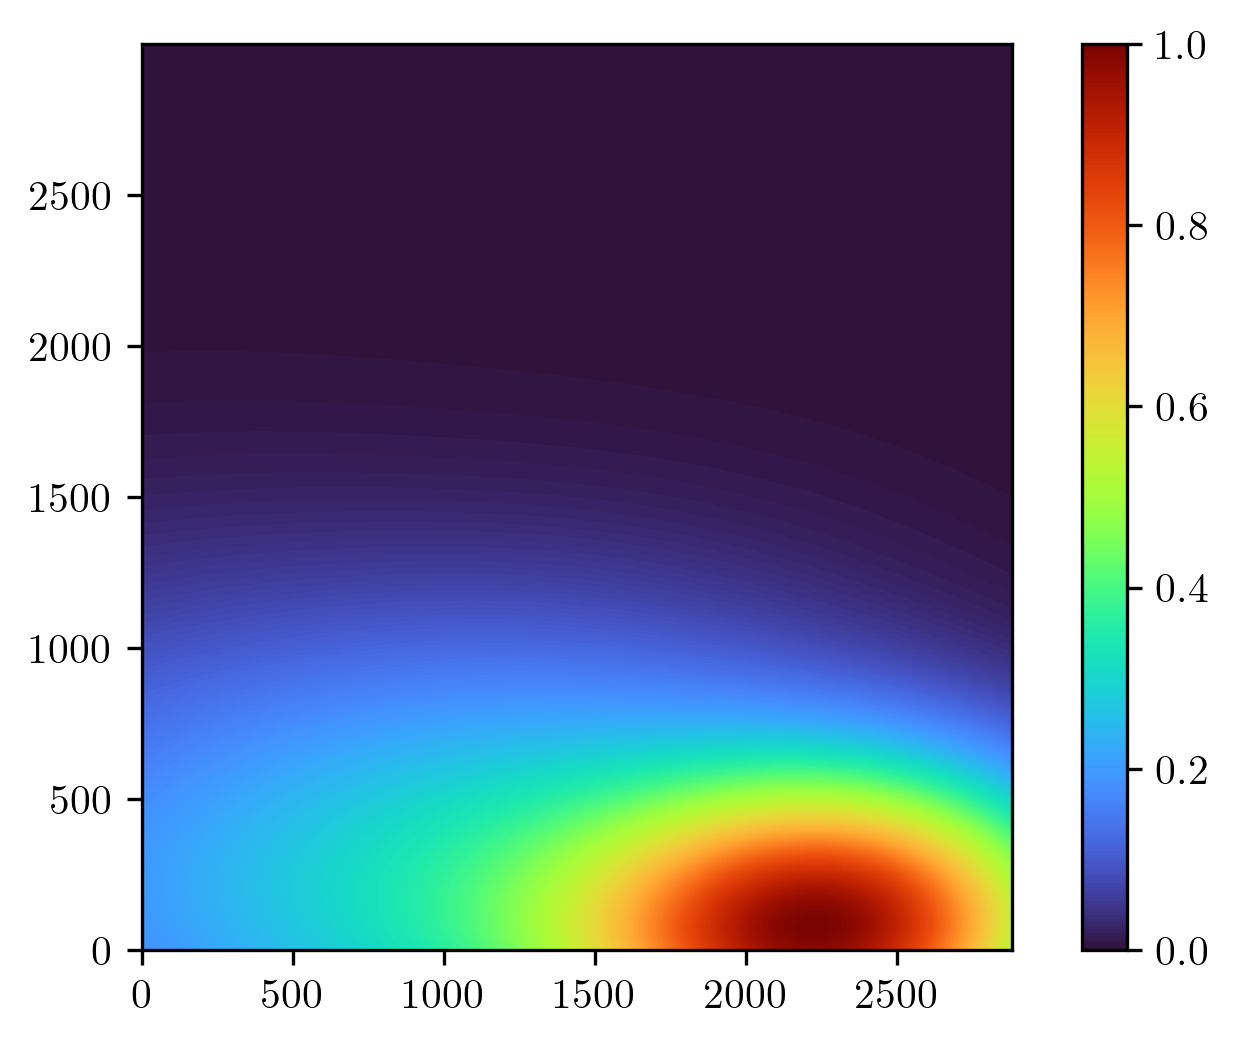

In [45]:
# %% Set a grid of Gaussian's - component 0
nx =5
ny = 1
cov_size =1E+6
choose_ratio = .95
std_ratio = .25
cov_r_lbounds=[.8,.1]
# setting height bounds for randomizing Gaussians
start_bin = 0
top_bin = int(0.5*ref_height_bin)
grid_y = y[start_bin:top_bin]
grid_x = x

Z_level0 = create_gaussians_level(grid,nx,ny,grid_x,grid_y,std_ratio,
                                  choose_ratio,cov_size,cov_r_lbounds)
if PLOT_RESULTS:
	plt.figure()
	im = plt.imshow(Z_level0,cmap = 'turbo')
	plt.colorbar(im)
	plt.gca().set_aspect('equal')
	plt.gca().invert_yaxis()
	plt.show()
# %%

#### Set grid of Gaussian's - component 1

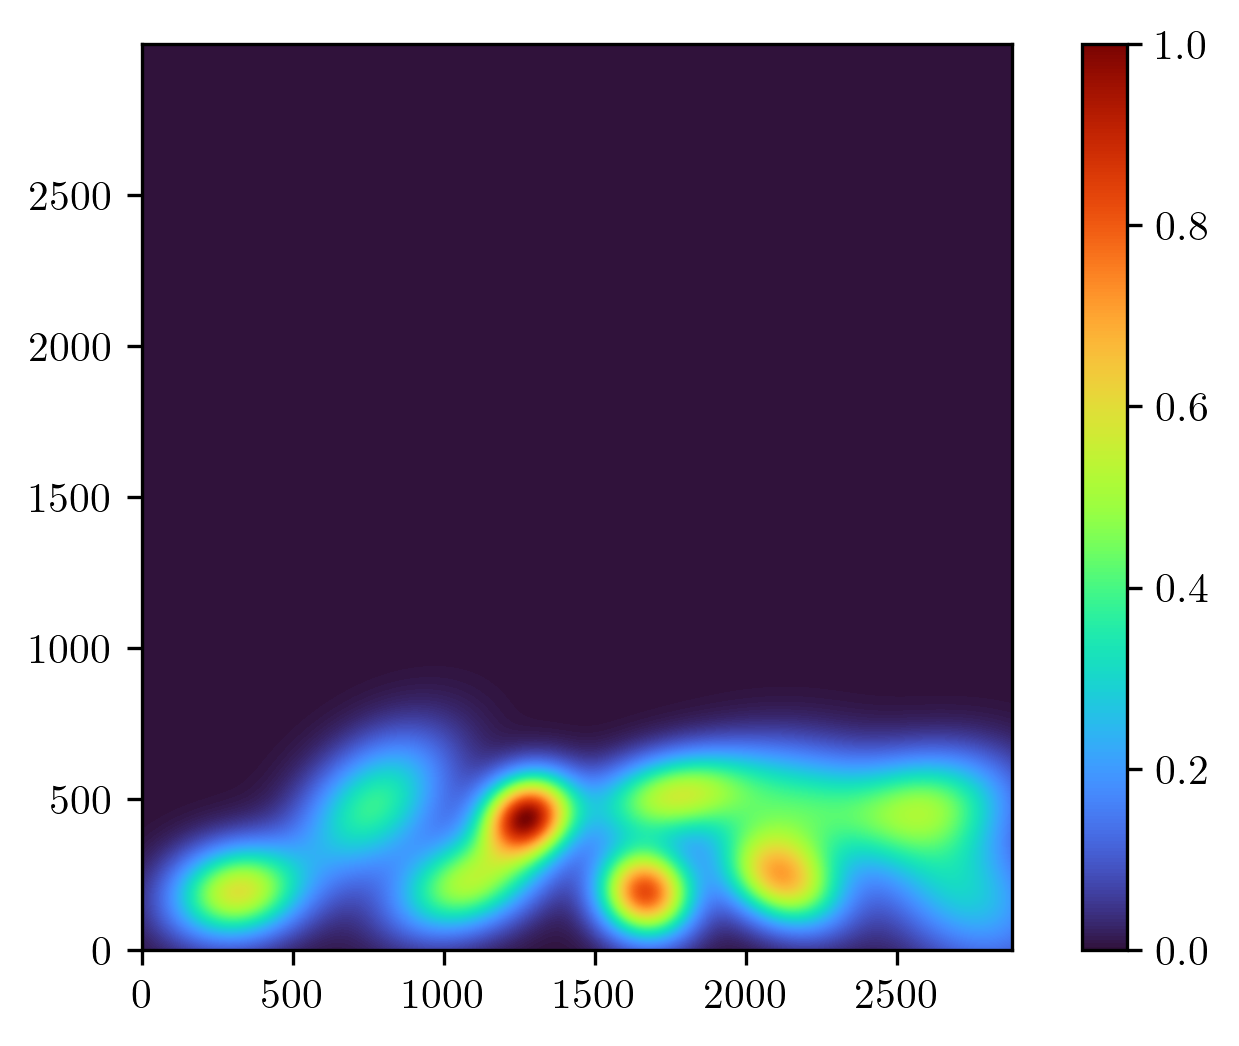

In [46]:
# %% Set a grid of gaussians - component 1
nx = 6
ny = 2
cov_size = 5*1E+4
choose_ratio = .9
std_ratio = .15
cov_r_lbounds=[.8,.1]

# setting height bounds for randomizing Gaussians
start_bin = int(0.1*ref_height_bin)
top_bin = int(0.8*ref_height_bin)
grid_y = y[start_bin:top_bin]
grid_x = x
Z_level1 = create_gaussians_level(grid,nx,ny,grid_x,grid_y,std_ratio,
                                  choose_ratio,cov_size,cov_r_lbounds)
if PLOT_RESULTS:
	plt.figure()
	im = plt.imshow(Z_level1,cmap='turbo')
	plt.colorbar(im)
	plt.gca().set_aspect('equal')
	plt.gca().invert_yaxis()
	plt.show()
# %%

#### Set grid of Gaussian's - component 2 (for features)

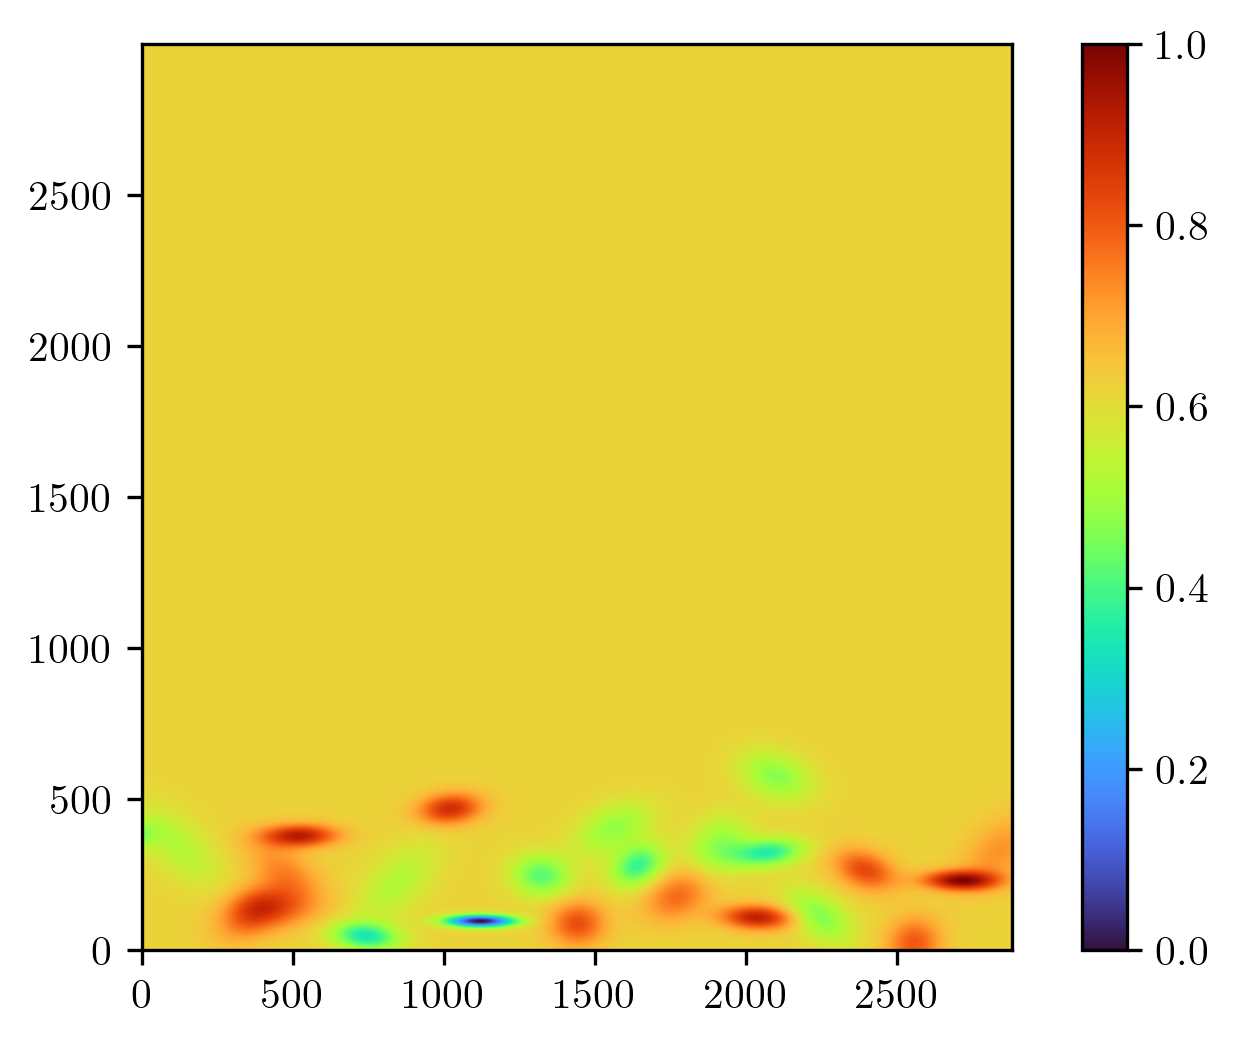

In [47]:
# %%Set a grid of gaussians - component 2 - for features

nx = 9
ny = 1
# setting height bounds for randomizing Gaussians
start_bin = int(0*ref_height_bin)
top_bin = int(.3*ref_height_bin)
grid_y = y[start_bin:top_bin]
new_grid,sample_points = get_random_sample_grid(nx,ny,grid_x, grid_y, std_ratio=.25)
center_x = sample_points['x']
center_y = sample_points['y']

nx = 8
ny = 1
# setting height bounds for randomizing Gaussians
start_bin = int(0.2*ref_height_bin)
top_bin = int(.5*ref_height_bin)
grid_y = y[start_bin:top_bin]
new_grid,sample_points = get_random_sample_grid(nx,ny,grid_x,grid_y, std_ratio=.25)
center_x1 = sample_points['x']
center_y1 = sample_points['y']

nx = 7
ny = 1
# setting height bounds for randomizing Gaussians
start_bin = int(0.4*ref_height_bin)
top_bin = int(.7*ref_height_bin)
grid_y = y[start_bin:top_bin]
new_grid,sample_points = get_random_sample_grid(nx,ny,grid_x,grid_y, std_ratio=.25)
center_x2 = sample_points['x']
center_y2= sample_points['y']


center_x_split_1, center_x_split_2, center_y_split_1, center_y_split_2 =\
	train_test_split(np.concatenate((center_x, center_x1,center_x2),axis = 0),
	                 np.concatenate((center_y, center_y1,center_y2),axis = 0),
	                 train_size = .5)

grid_cov_size = 1E+4
Z_level2 = np.zeros((grid.shape[0],grid.shape[1]))
for x0,y0 in zip(center_x_split_1,center_y_split_1):
	cov = grid_cov_size*get_random_cov_mat(lbound_x = .7 , lbound_y=.01)
	rv = multivariate_normal((x0,y0), cov)
	r = 1
	Z_level2 += r*rv.pdf(grid)
for x0,y0 in zip(center_x_split_2,center_y_split_2):
	cov = grid_cov_size*get_random_cov_mat(lbound_x = .7 , lbound_y=.01)
	rv = multivariate_normal((x0,y0), cov)
	r = -1
	Z_level2 += r*rv.pdf(grid)

Z_level2 = (Z_level2 -Z_level2.min())/(Z_level2.max()-Z_level2.min())
if PLOT_RESULTS:
	plt.figure()
	im = plt.imshow(Z_level2,cmap = 'turbo')
	plt.colorbar(im)
	plt.gca().set_aspect('equal')
	plt.gca().invert_yaxis()
	plt.show()
# %%

#### Gradients of component 2

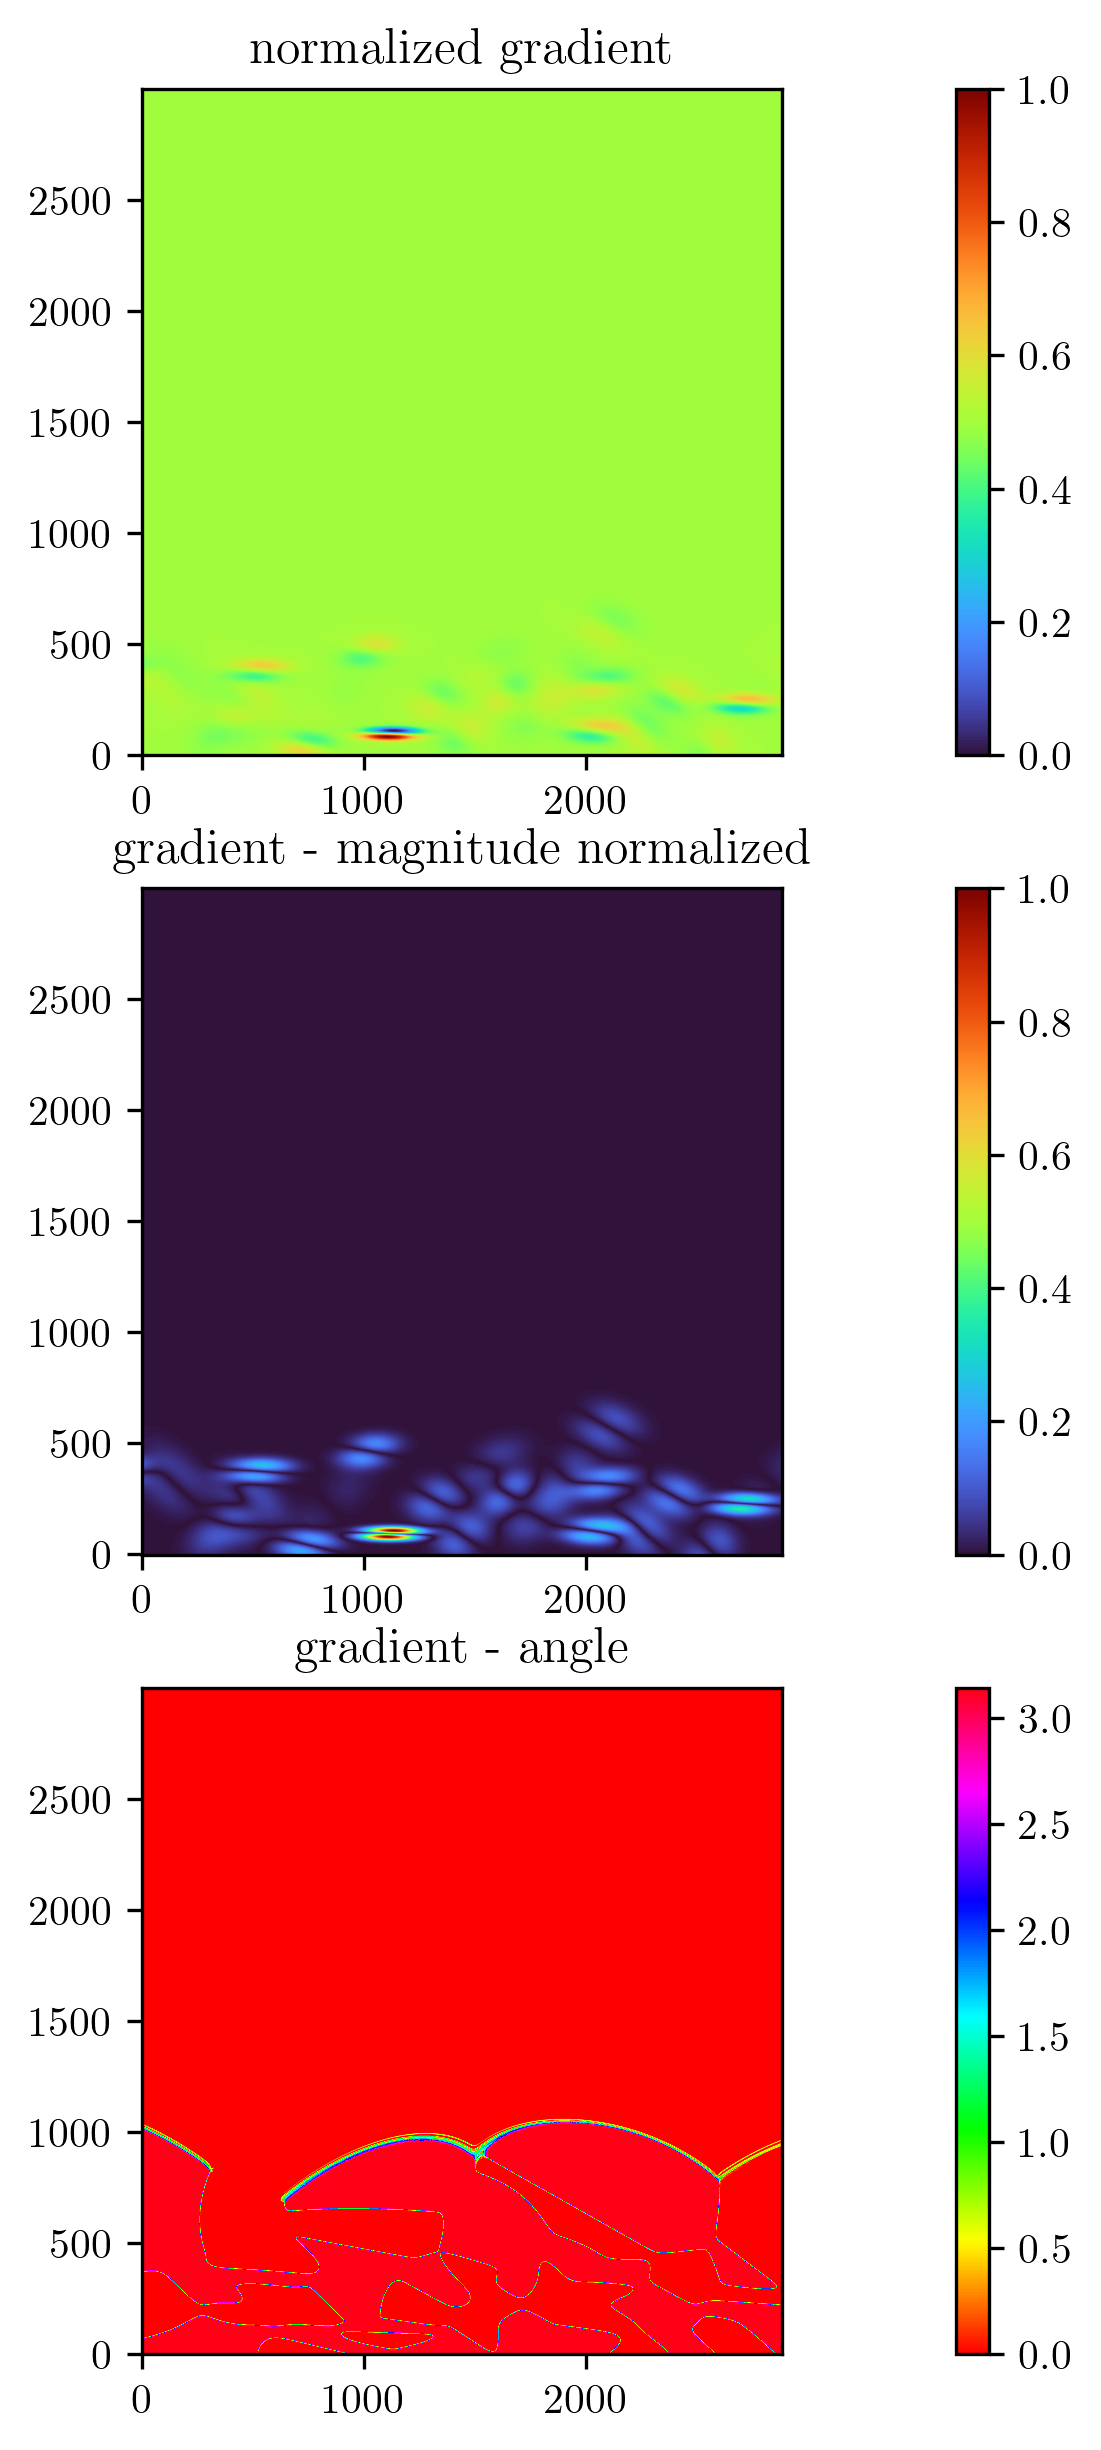

In [48]:
# %%Gradients of component 2

g_filter = np.array([[0 , -1, 0],
                     [-1, 0 , 1],
                     [0 , 1 , 0]])
grad = signal.convolve2d(Z_level2, g_filter, boundary='symm', mode='same')
grad_norm = (grad-grad.min())/(grad.max()-grad.min())
grad_amplitude = np.absolute(grad)
grad_norm_amplitude= (grad_amplitude-grad_amplitude.min())/(grad_amplitude.max()-grad_amplitude.min())

if PLOT_RESULTS:
	fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
	ax = axes.ravel()
	ax_i = ax[0]

	im = ax_i.imshow(grad_norm, cmap='turbo')
	plt.colorbar(im, ax=ax_i)
	ax_i.set_aspect('equal')
	ax_i.invert_yaxis()
	ax_i.set_title('normalized gradient')

	ax_i= ax[1]
	im = ax_i.imshow(grad_norm_amplitude, cmap='turbo')
	plt.colorbar(im, ax=ax_i)
	ax_i.set_aspect('equal')
	ax_i.invert_yaxis()
	ax_i.set_title('gradient - magnitude normalized')

	ax_i= ax[2]
	im = ax_i.imshow(np.angle(grad), cmap='hsv')
	plt.colorbar(im, ax=ax_i)
	ax_i.set_aspect('equal')
	ax_i.invert_yaxis()
	ax_i.set_title('gradient - angle')
	plt.show()
# %%

#### Subsample and interpolation of the absolute of gradients - component 2

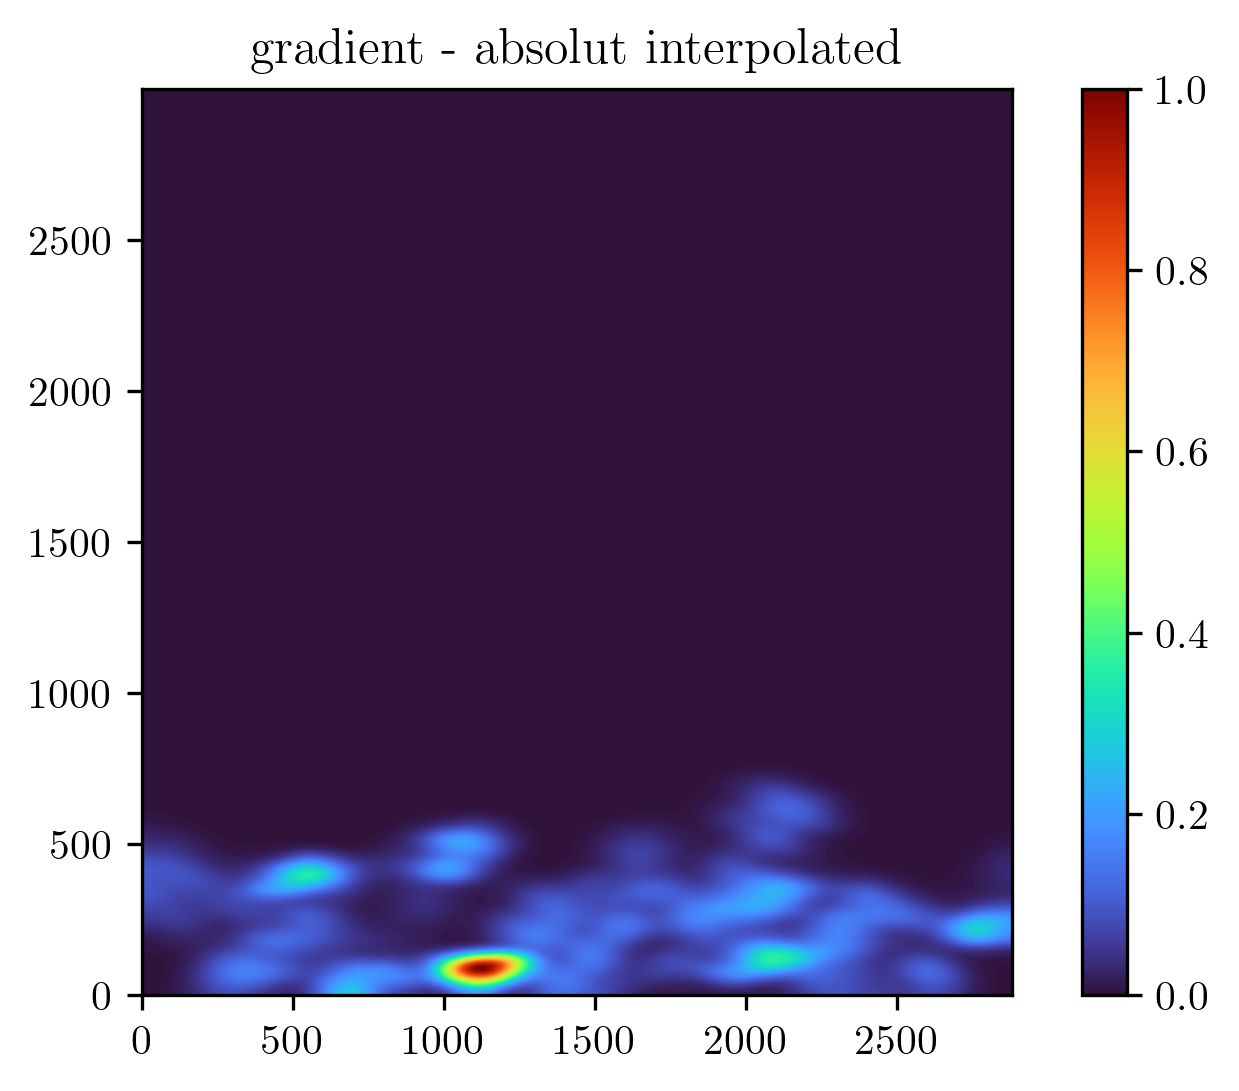

In [49]:
# %%Subsample and interpolation of the absolute of gradients - component 2

nsamples= int(total_bins*total_time_bins *.0005)
interp_features = make_interpolated_image(nsamples,grad_norm_amplitude)
blur_features= gaussian_filter(interp_features,sigma=(21,61))
blur_features = (blur_features-blur_features.min())/(blur_features.max()-blur_features.min())
if PLOT_RESULTS:
	plt.figure()
	im = plt.imshow(blur_features, cmap='turbo')
	plt.colorbar(im)
	plt.gca().set_aspect('equal')
	plt.gca().invert_yaxis()
	plt.title('gradient - absolut interpolated')
	plt.show()
# %%

#### Subsample & interpolation of 1/4 part of the component (stretching to one day of measurments)

In [50]:
indexes= np.round(np.linspace(0,720,97)).astype(int)
target_indexes = [ i*30 for i in range(97)]
target_indexes[-1]-=1
tt_index = time_index[target_indexes]

# %% trying to set different sizes of croping : 6,8,12 or 24 hours . This is not finished yet, thus uncommented

"""
interval_size = np.random.choice([6,8,12,24])
bins_interval = 120*interval_size
bins_interval,interval_size, bins_interval/30
2880/30+1 , len(target_indexes),96*30, source_indexes"""

'\ninterval_size = np.random.choice([6,8,12,24])\nbins_interval = 120*interval_size\nbins_interval,interval_size, bins_interval/30\n2880/30+1 , len(target_indexes),96*30, source_indexes'

## Summing up the components to an aerosol density $\rho_{aer}$

In [51]:
# %%
k =  np.random.uniform(0.5,2.5)
shift_bins = int((720)*k)
print(f'component 0 shift bins {shift_bins}')
source_indexes = indexes+shift_bins
sampled_level0_interp  = get_sub_sample_level (Z_level0, source_indexes, tt_index)

k =  np.random.uniform(0,3)
shift_bins = int((720)*k)
print(f'component 1 shift bins {shift_bins}')
source_indexes = indexes+shift_bins
sampled_level1_interp  = get_sub_sample_level (Z_level1, source_indexes, tt_index)

k =  np.random.uniform(0,3)
shift_bins = int((720)*k)
print(f'component 2 shift bins {shift_bins}')
source_indexes = indexes+shift_bins
sampled_level2_interp  = get_sub_sample_level (blur_features, source_indexes, tt_index)
# %%

component 0 shift bins 1764
component 1 shift bins 1581
component 2 shift bins 956


In [52]:

components = []
for indl,component in enumerate([sampled_level0_interp,sampled_level1_interp,sampled_level2_interp]):
	ds_component = xr.Dataset (
	    data_vars = {'density' : (('Height','Time') , component) ,
                     'component' : ('Component' , [indl])
                     } ,
        coords = {'Height': heights,
                  'Time' : time_index.tolist(),
                  'Component' : [indl]
                  })
	components.append(ds_component)
ds_density = xr.concat(components,dim='Component')
ds_density.Height.attrs = {'units':r'$km$', 'info':"Measurements heights above sea level"}
#ds_density

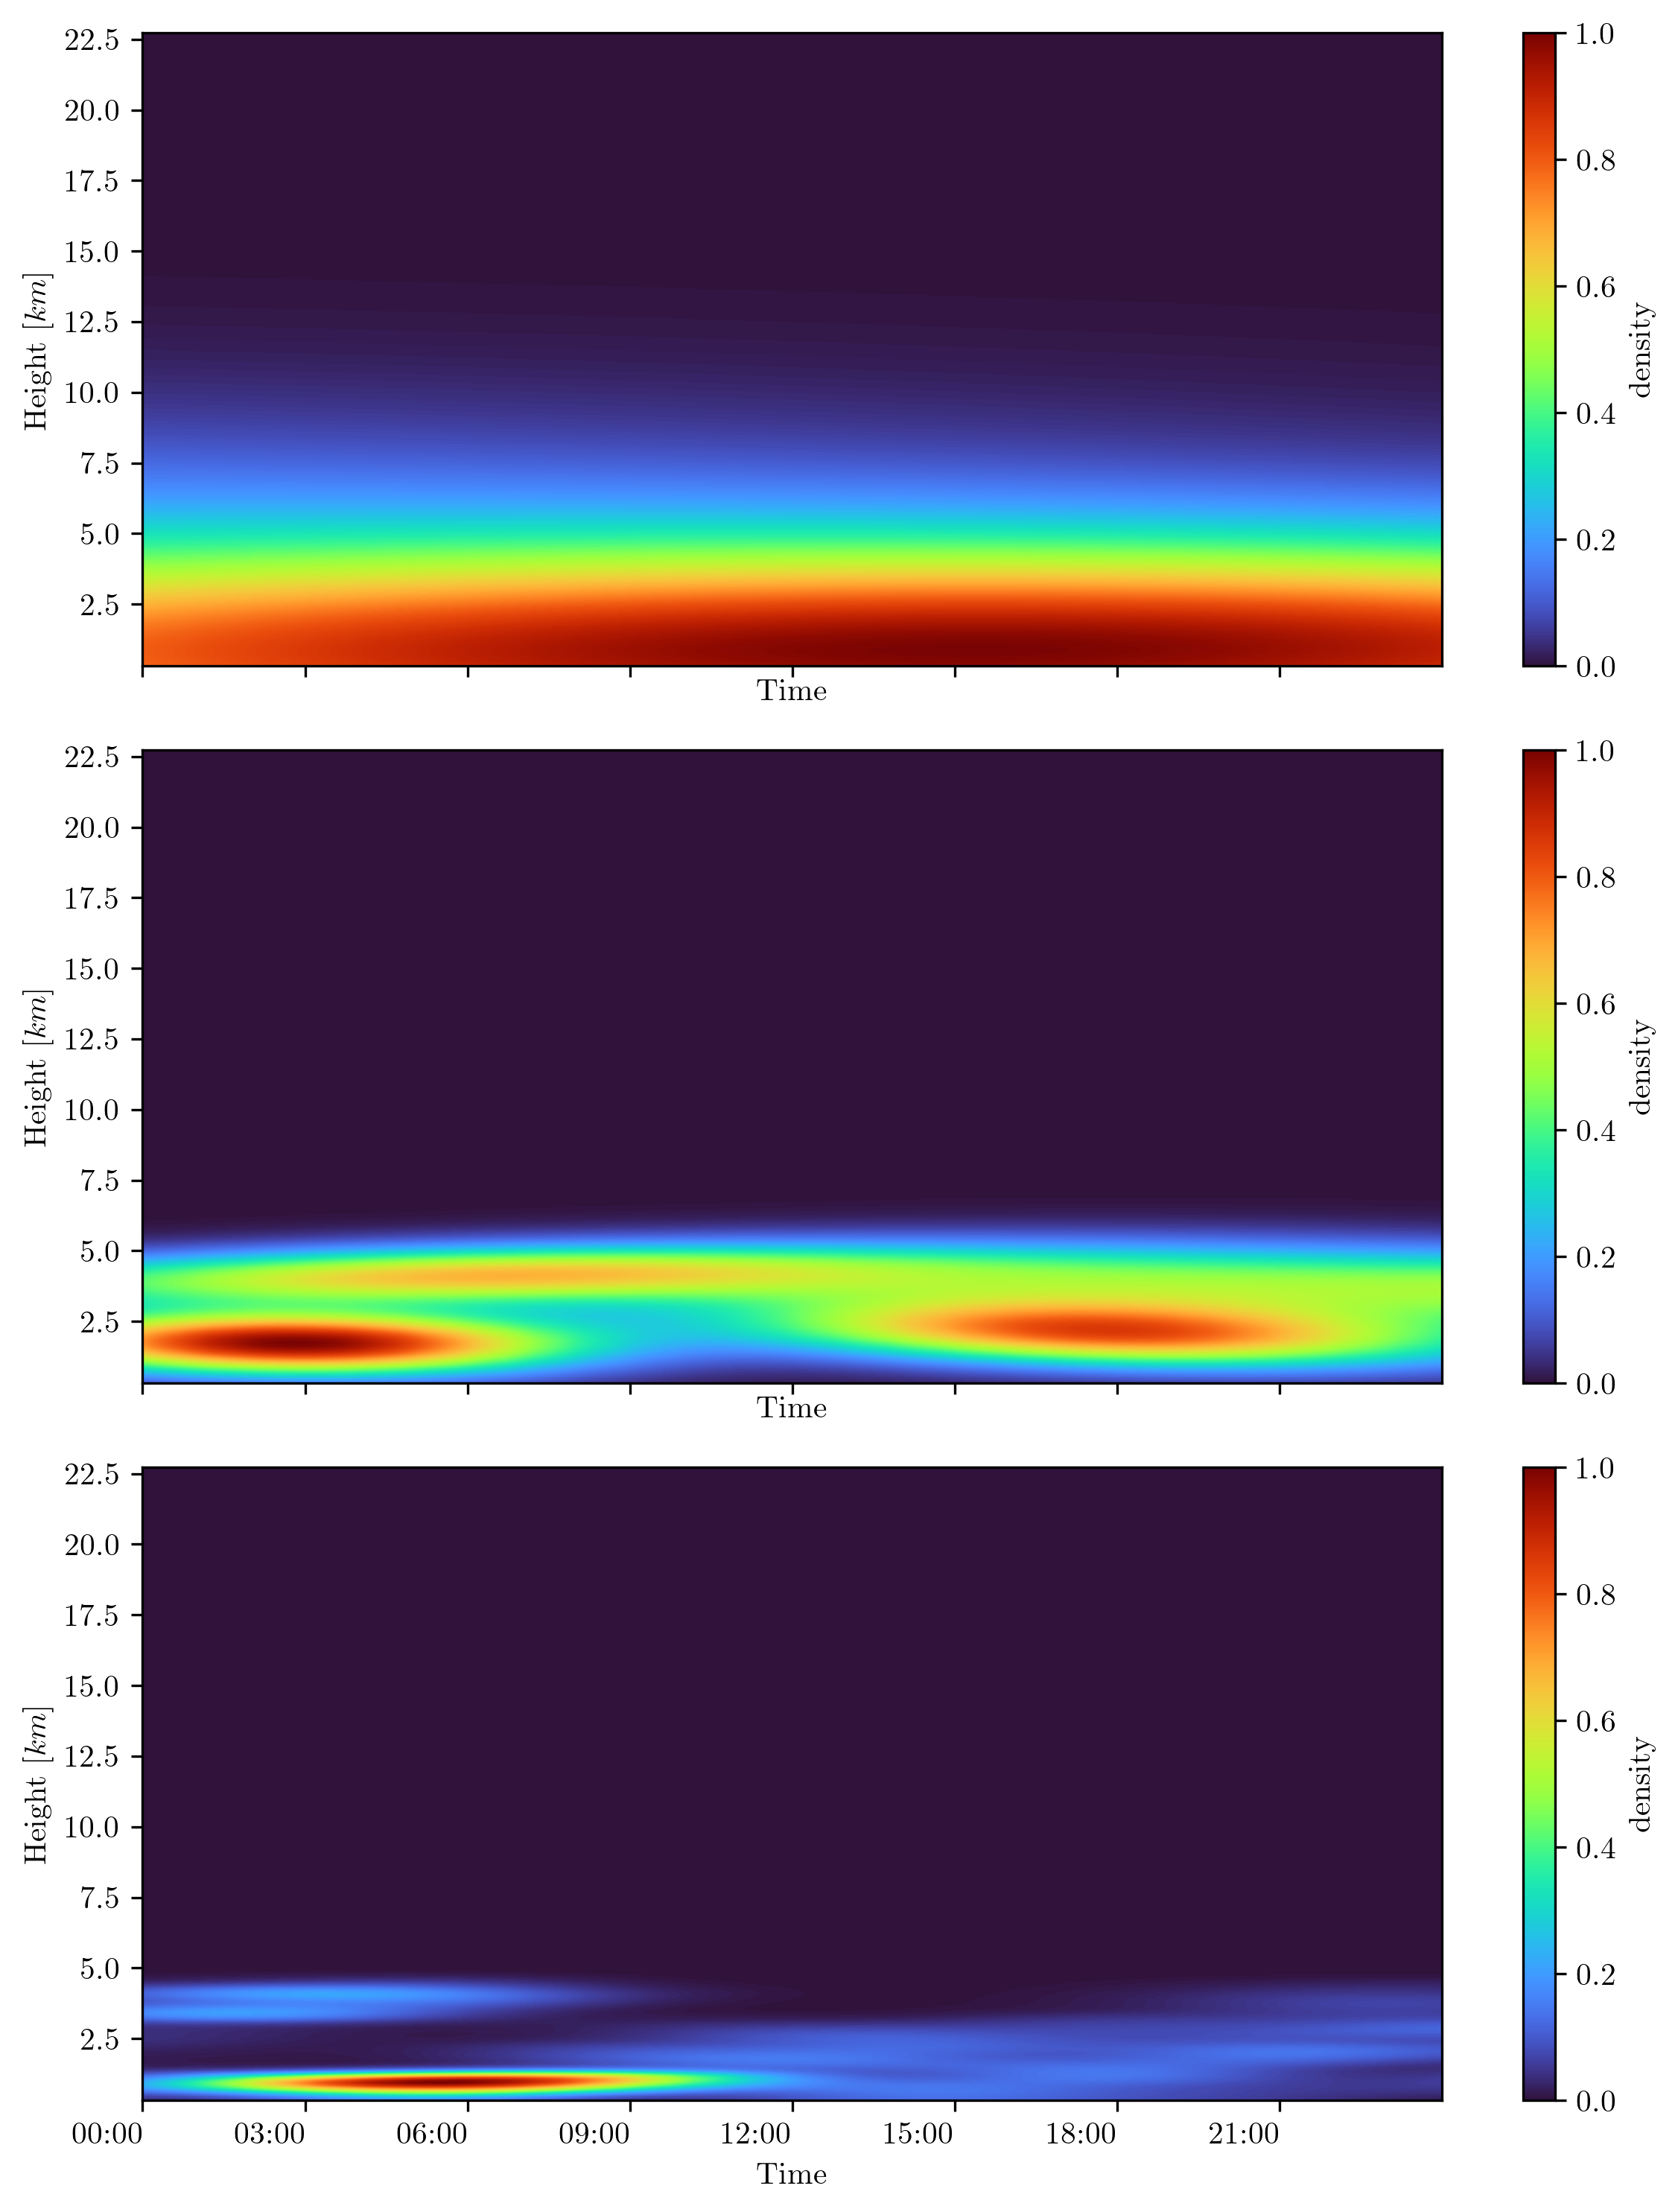

In [53]:
if PLOT_RESULTS:
	fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,10),sharex=True)
	for l,ax in zip(ds_density.Component,axes.ravel()):
		ds_density.density.sel(Component = l).plot(cmap='turbo', ax=ax)
		ax.xaxis.set_major_formatter(timeformat)
		ax.xaxis.set_tick_params(rotation=0)
		ax.set_title('')
		#ax.xticks(rotation=0)
	plt.tight_layout()

	plt.show()

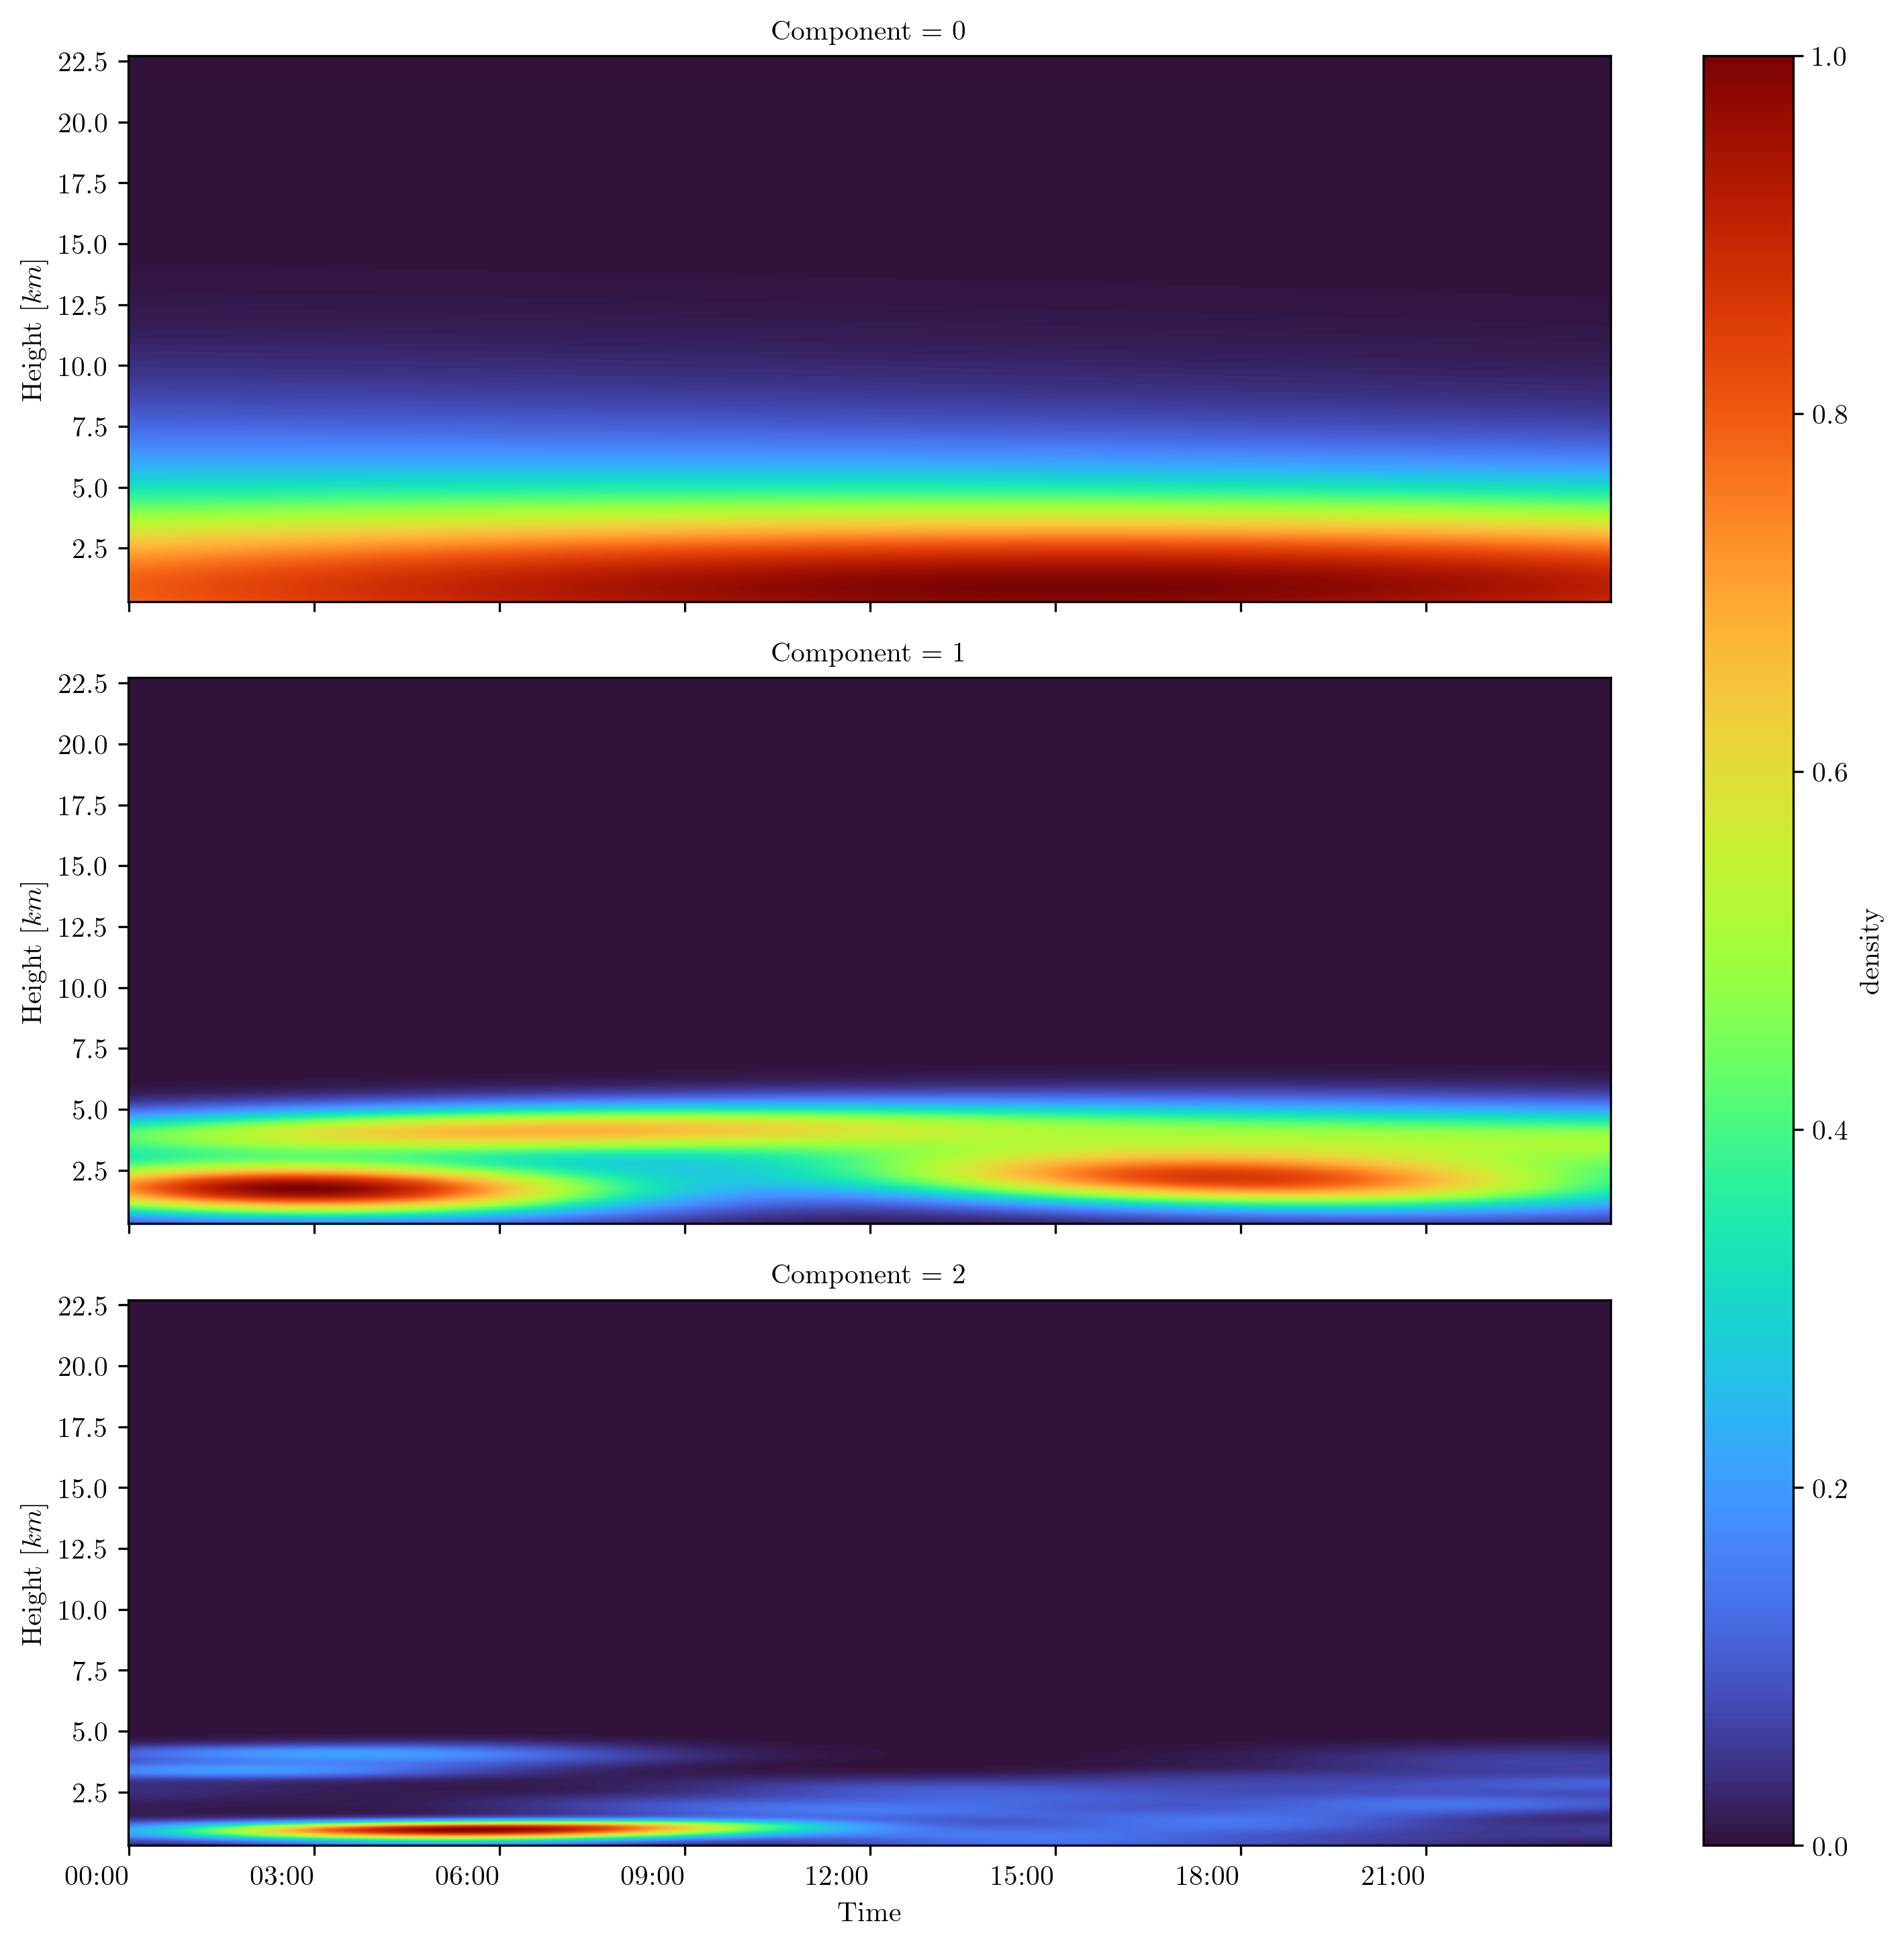

In [54]:
ds_density.density.plot(x='Time',y='Height',row='Component',cmap = 'turbo',figsize=(10,10) ,sharex=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(timeformat)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

## Profiles at different times

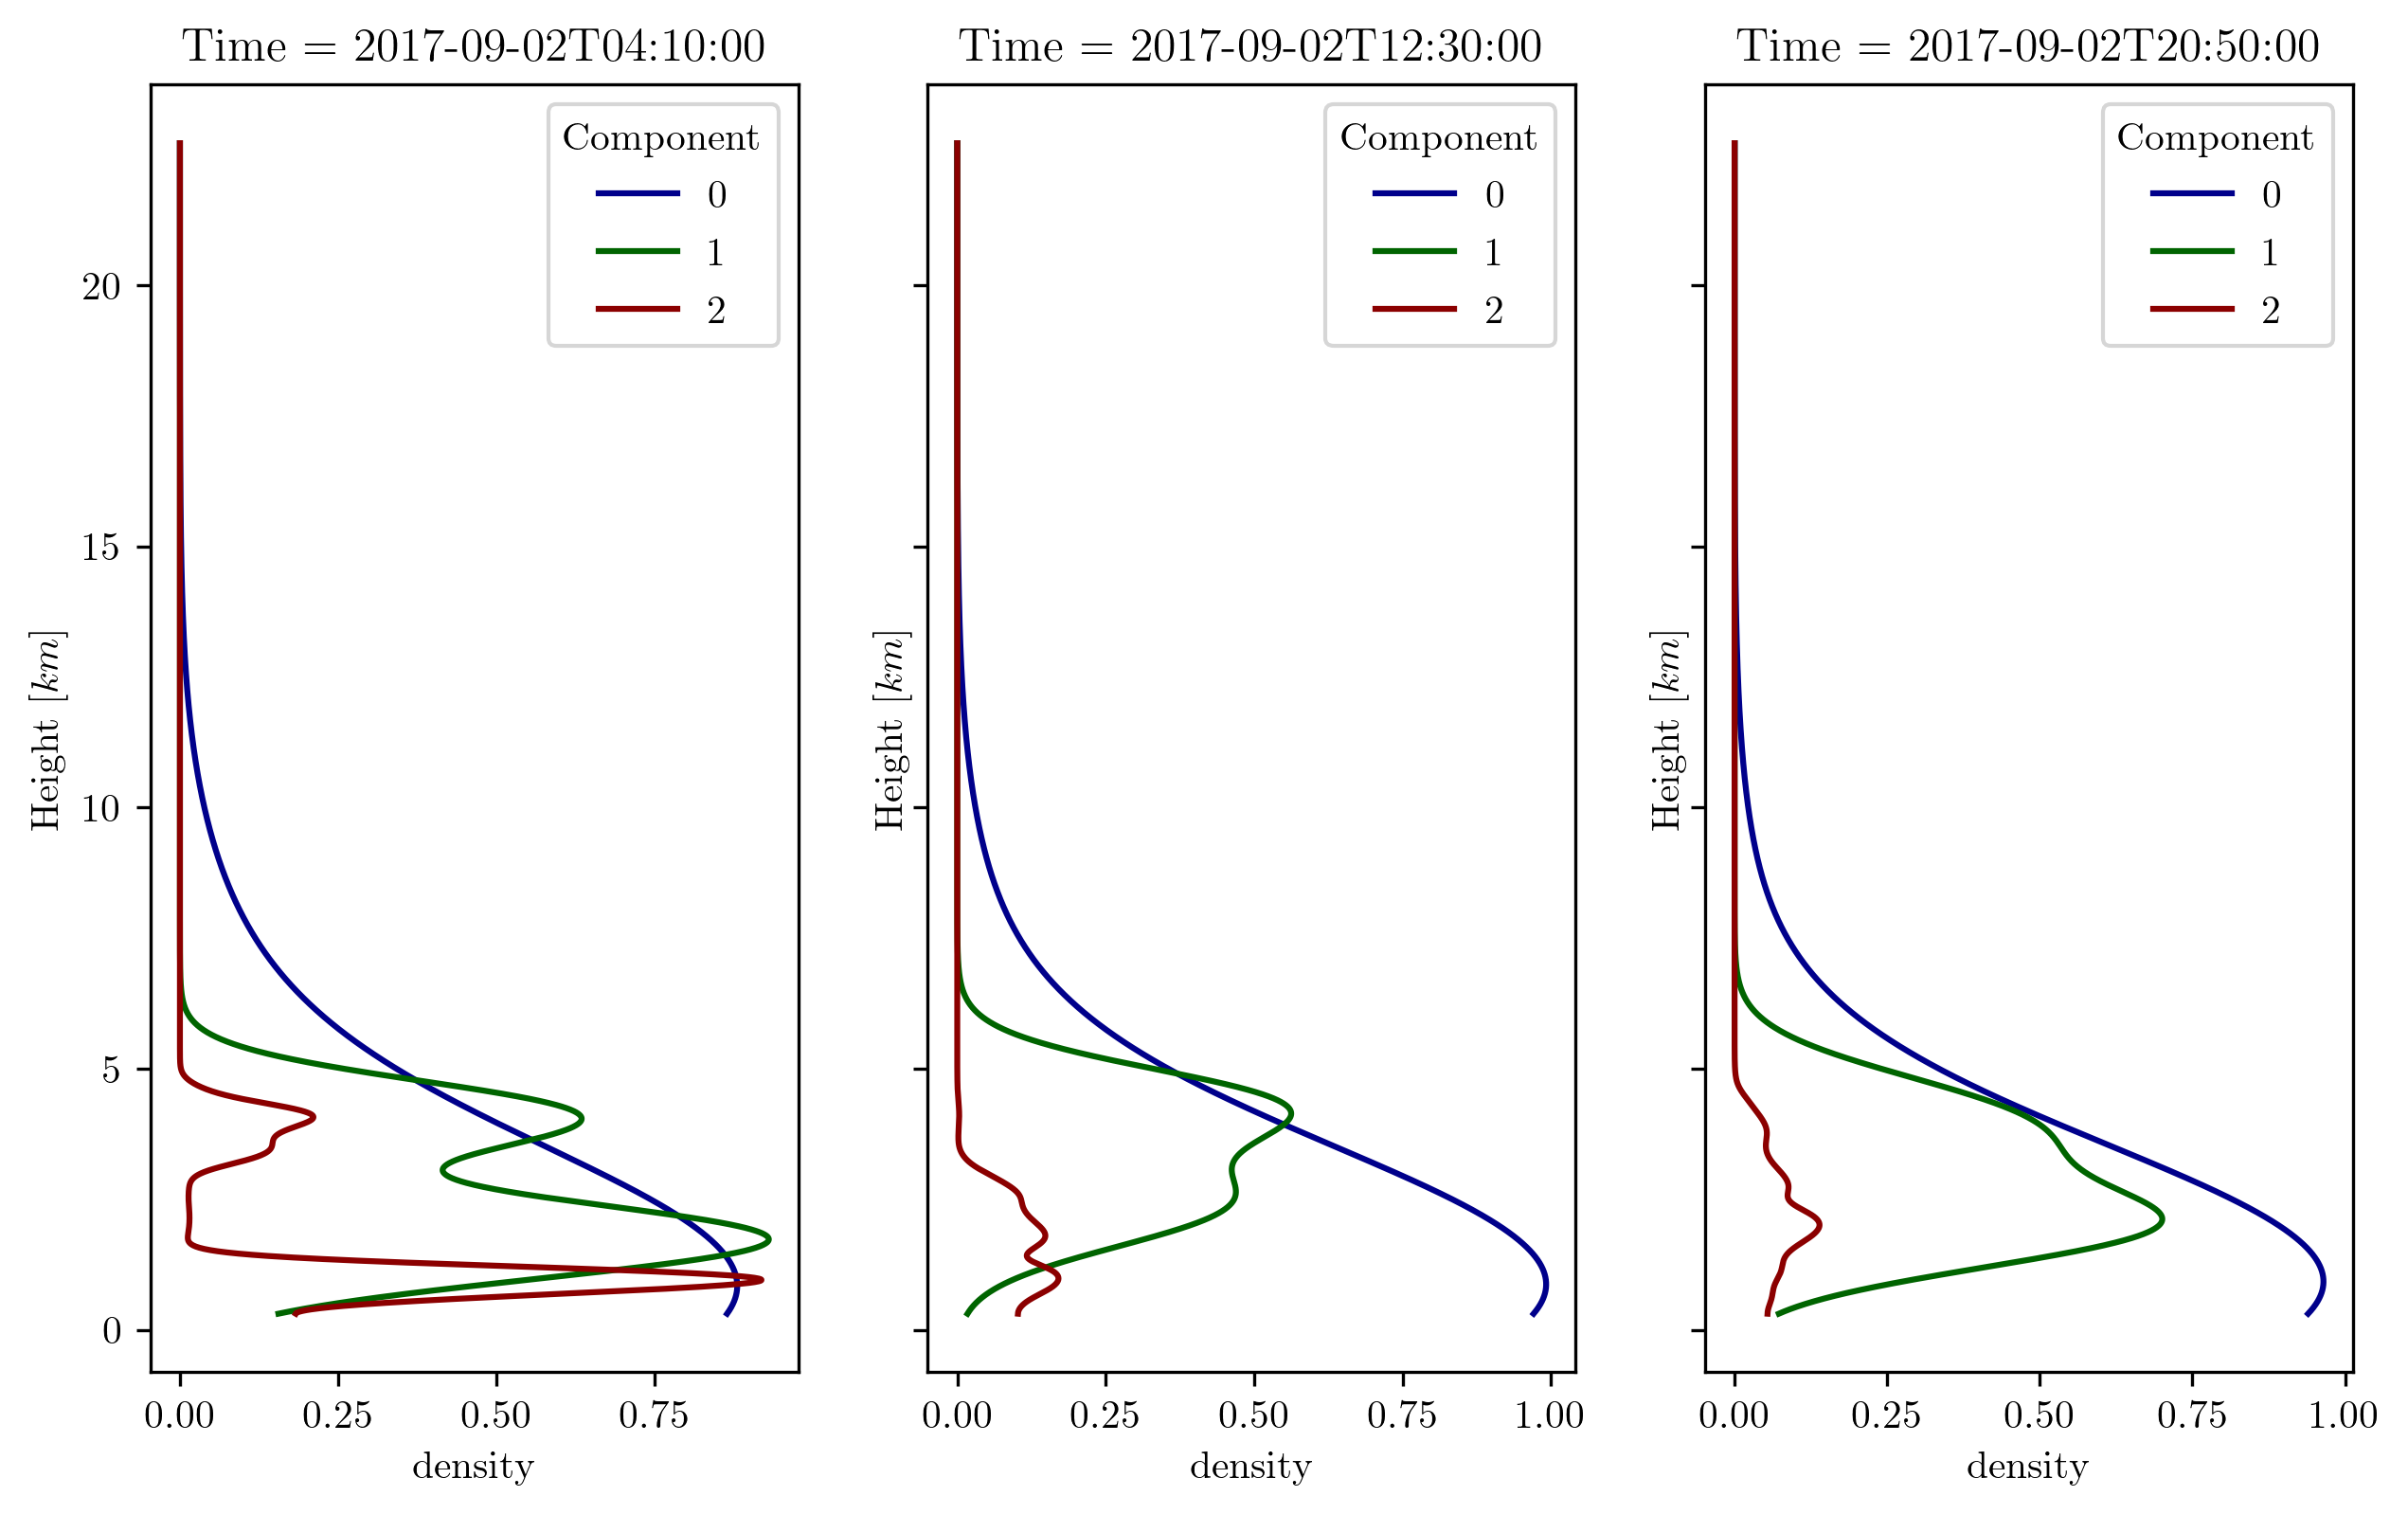

In [55]:
if PLOT_RESULTS:
	t_index = [500,1500,2500]
	times = [ds_density.Time[ind].values for ind in t_index]
	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,6),sharey = True)
	for t, ax in zip(times,axes.ravel()):
		ds_density.density.sel(Time = t).plot.line(ax= ax,y='Height')
	#plt.tight_layout()
	plt.show()

## Merged density level
#### Built as a linear combination of the levels above

In [56]:
weight_0 = 0.6 + (0.25)*np.random.randn()
if weight_0<0.3 :
	weight_0 = 0.5 + abs(weight_0)
weight_1 = 0.3 + (0.25)*np.random.randn()
if weight_1<0 :
	weight_1 = 0.3 + abs(weight_1)
weight_2 = 0.4 + (0.25)*np.random.randn()
if weight_2<0 :
	weight_2 = 0.4 + abs(weight_2)
print([weight_0,weight_1,weight_2])
atmosphere_ds = ds_density.assign({'weights':('Component',[weight_0,weight_1,weight_2])})
merged = xr.zeros_like(ds_density.density[0])
for l in ds_density.Component:
	merged += ds_density.density.sel(Component=l)*atmosphere_ds.weights.sel(Component=l)
merged = (merged-merged.min())/(merged.max()-merged.min())

[0.6226813398886905, 0.27153192535445114, 0.61757151412361]


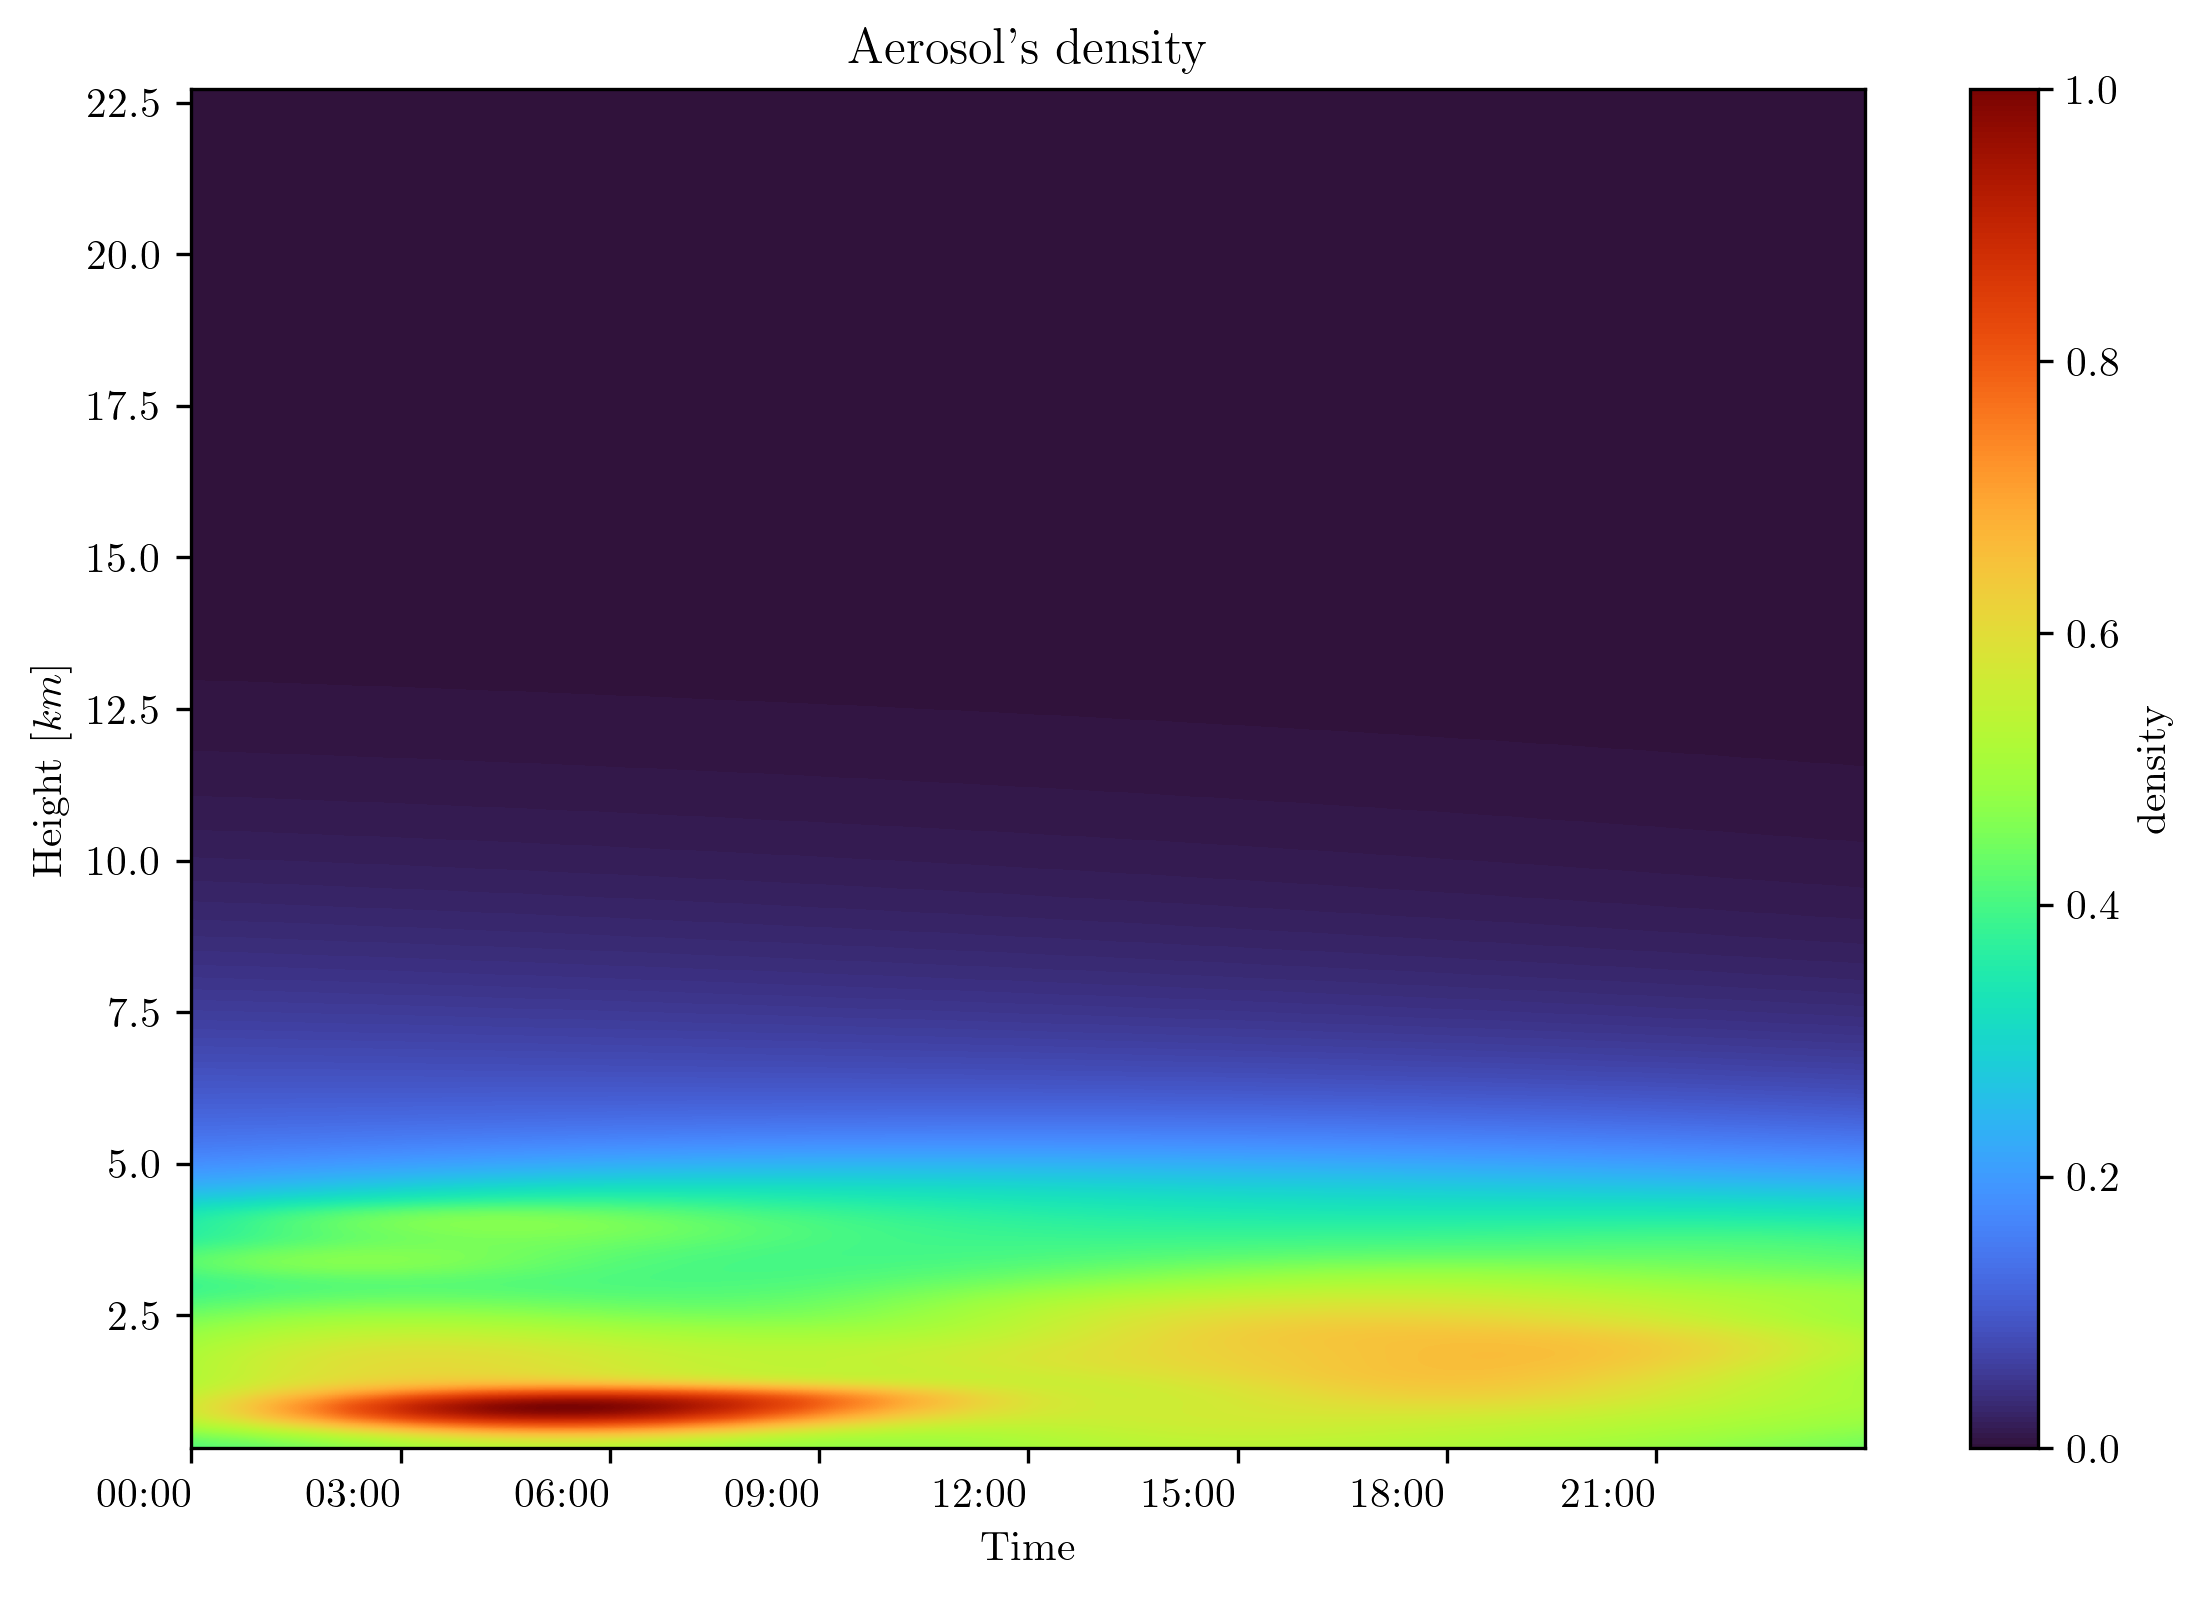

In [57]:
atmosphere_ds =  atmosphere_ds.assign(merged = merged)
atmosphere_ds.merged.attrs = {'info':"Aerosol's density",'long_name':'density'}
if PLOT_RESULTS:
	plt.figure(figsize = (9,6))
	atmosphere_ds.merged.plot(cmap='turbo')
	plt.title(atmosphere_ds.merged.attrs['info'])
	ax = plt.gca()
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

Create empty $\beta$ and $\sigma$ densities

In [58]:
atmosphere_ds = atmosphere_ds.assign_coords(Wavelength=[355,532,1064])
atmosphere_ds =atmosphere_ds.assign({'ratio':('Height',smooth_ratio)})
atmosphere_ds

<xarray.Dataset>
Dimensions:     (Component: 3, Height: 3000, Time: 2880, Wavelength: 3)
Coordinates:
  * Height      (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
  * Time        (Time) datetime64[ns] 2017-09-02 ... 2017-09-02T23:59:30
  * Component   (Component) int64 0 1 2
  * Wavelength  (Wavelength) int32 355 532 1064
Data variables:
    density     (Component, Height, Time) float64 0.782 0.7822 ... 0.0 0.0
    component   (Component) int32 0 1 2
    weights     (Component) float64 0.6227 0.2715 0.6176
    merged      (Height, Time) float64 0.4148 0.4149 0.4151 ... 2.185e-10 0.0
    ratio       (Height) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

## Creating $\sigma_{532}$
#### To create the aerosol, the density is:
1. Normalized
2. Corrected according to ratio above
3. multiplied with a typical $\sigma_{aer,532}$, e.g. $\sigma_{max}=0.025[1/km]$

In [59]:
sigma_ratio = xr.apply_ufunc(lambda x,r: gaussian_filter(r*x,sigma = (9,5)),
                         atmosphere_ds.merged,atmosphere_ds.ratio,keep_attrs = False)

sigma_g = xr.apply_ufunc(lambda x: normalize(x,sigma_532_max),
                         sigma_ratio.copy(deep=True),keep_attrs = False)
sigma_g['Wavelength'] = 532

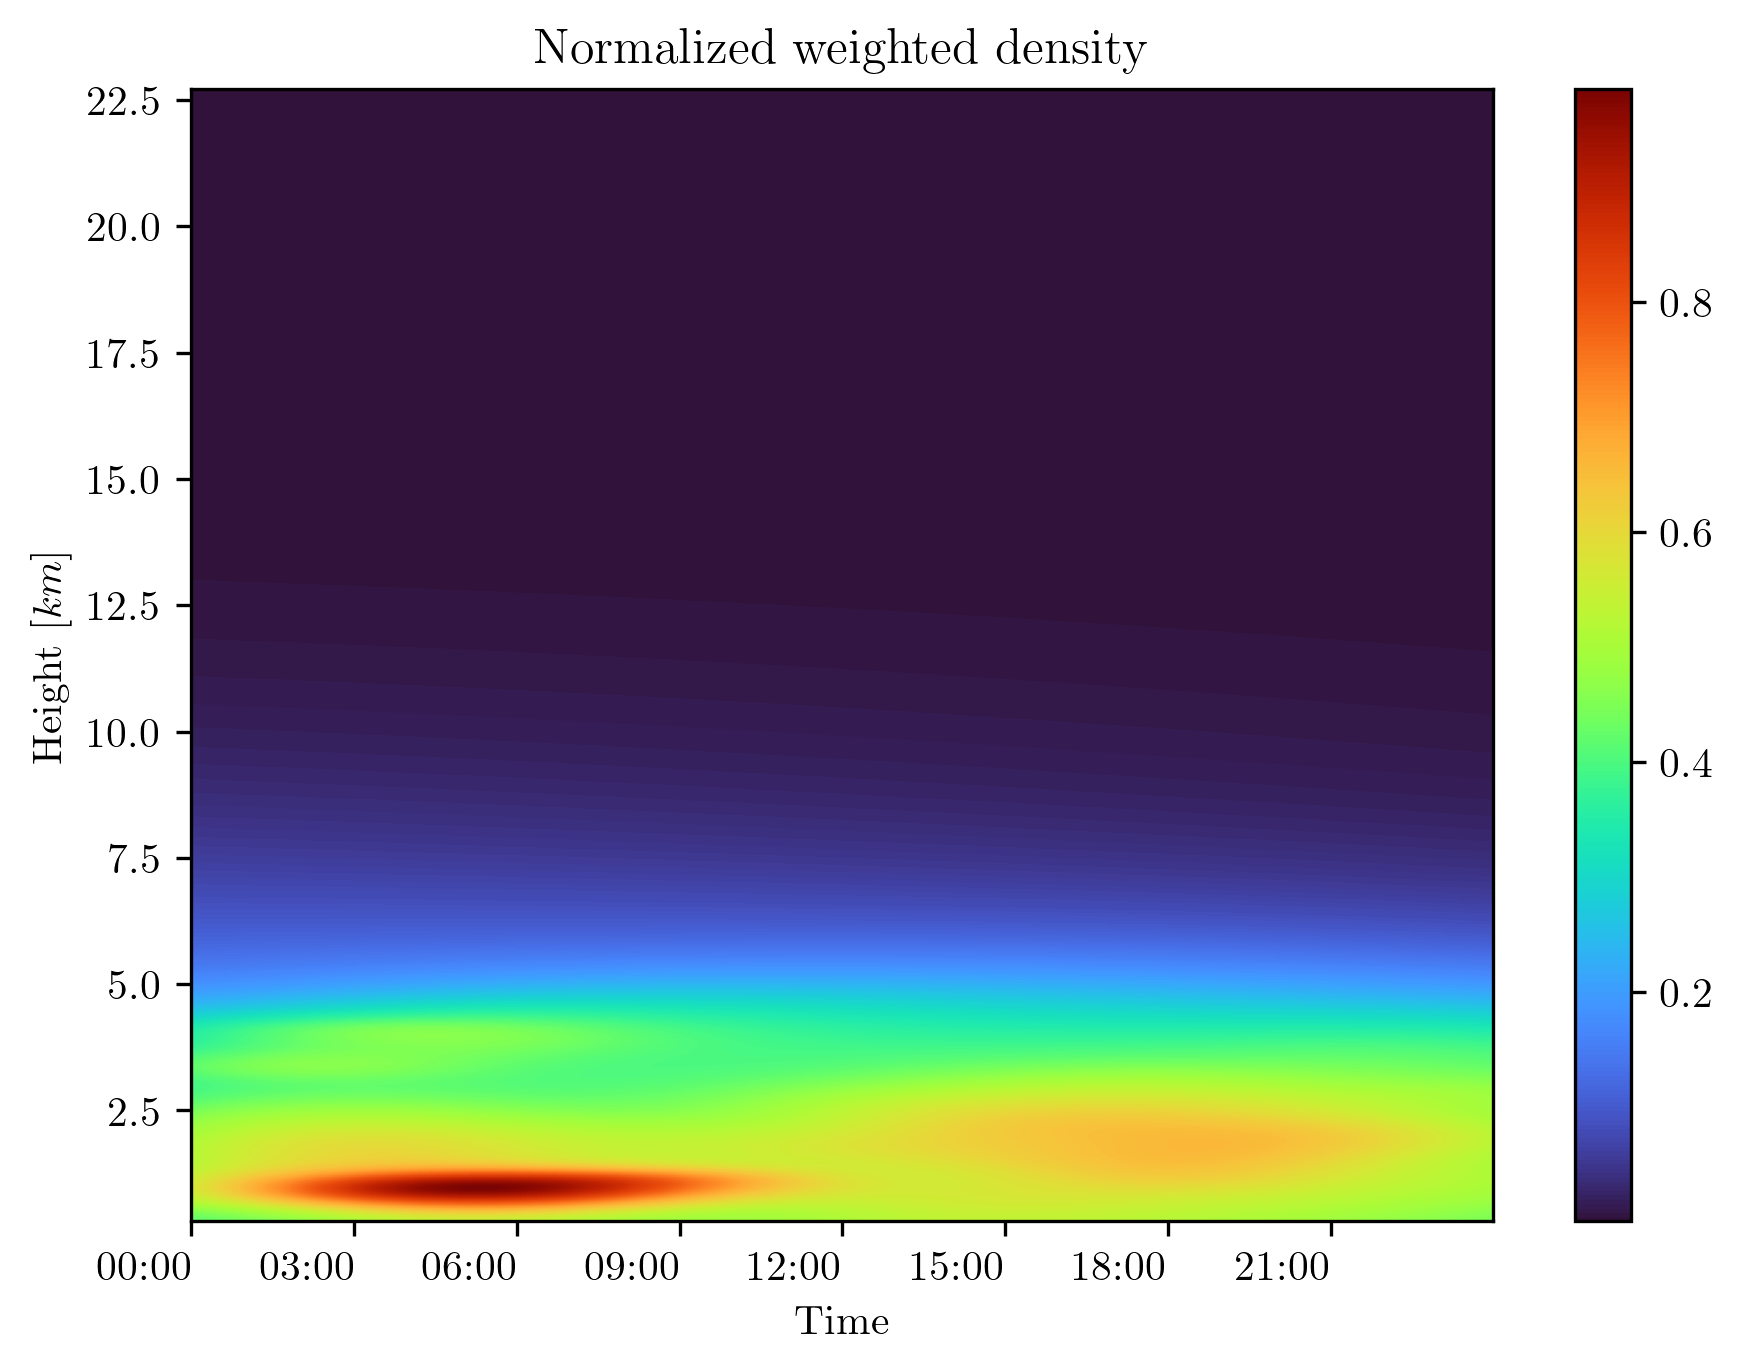

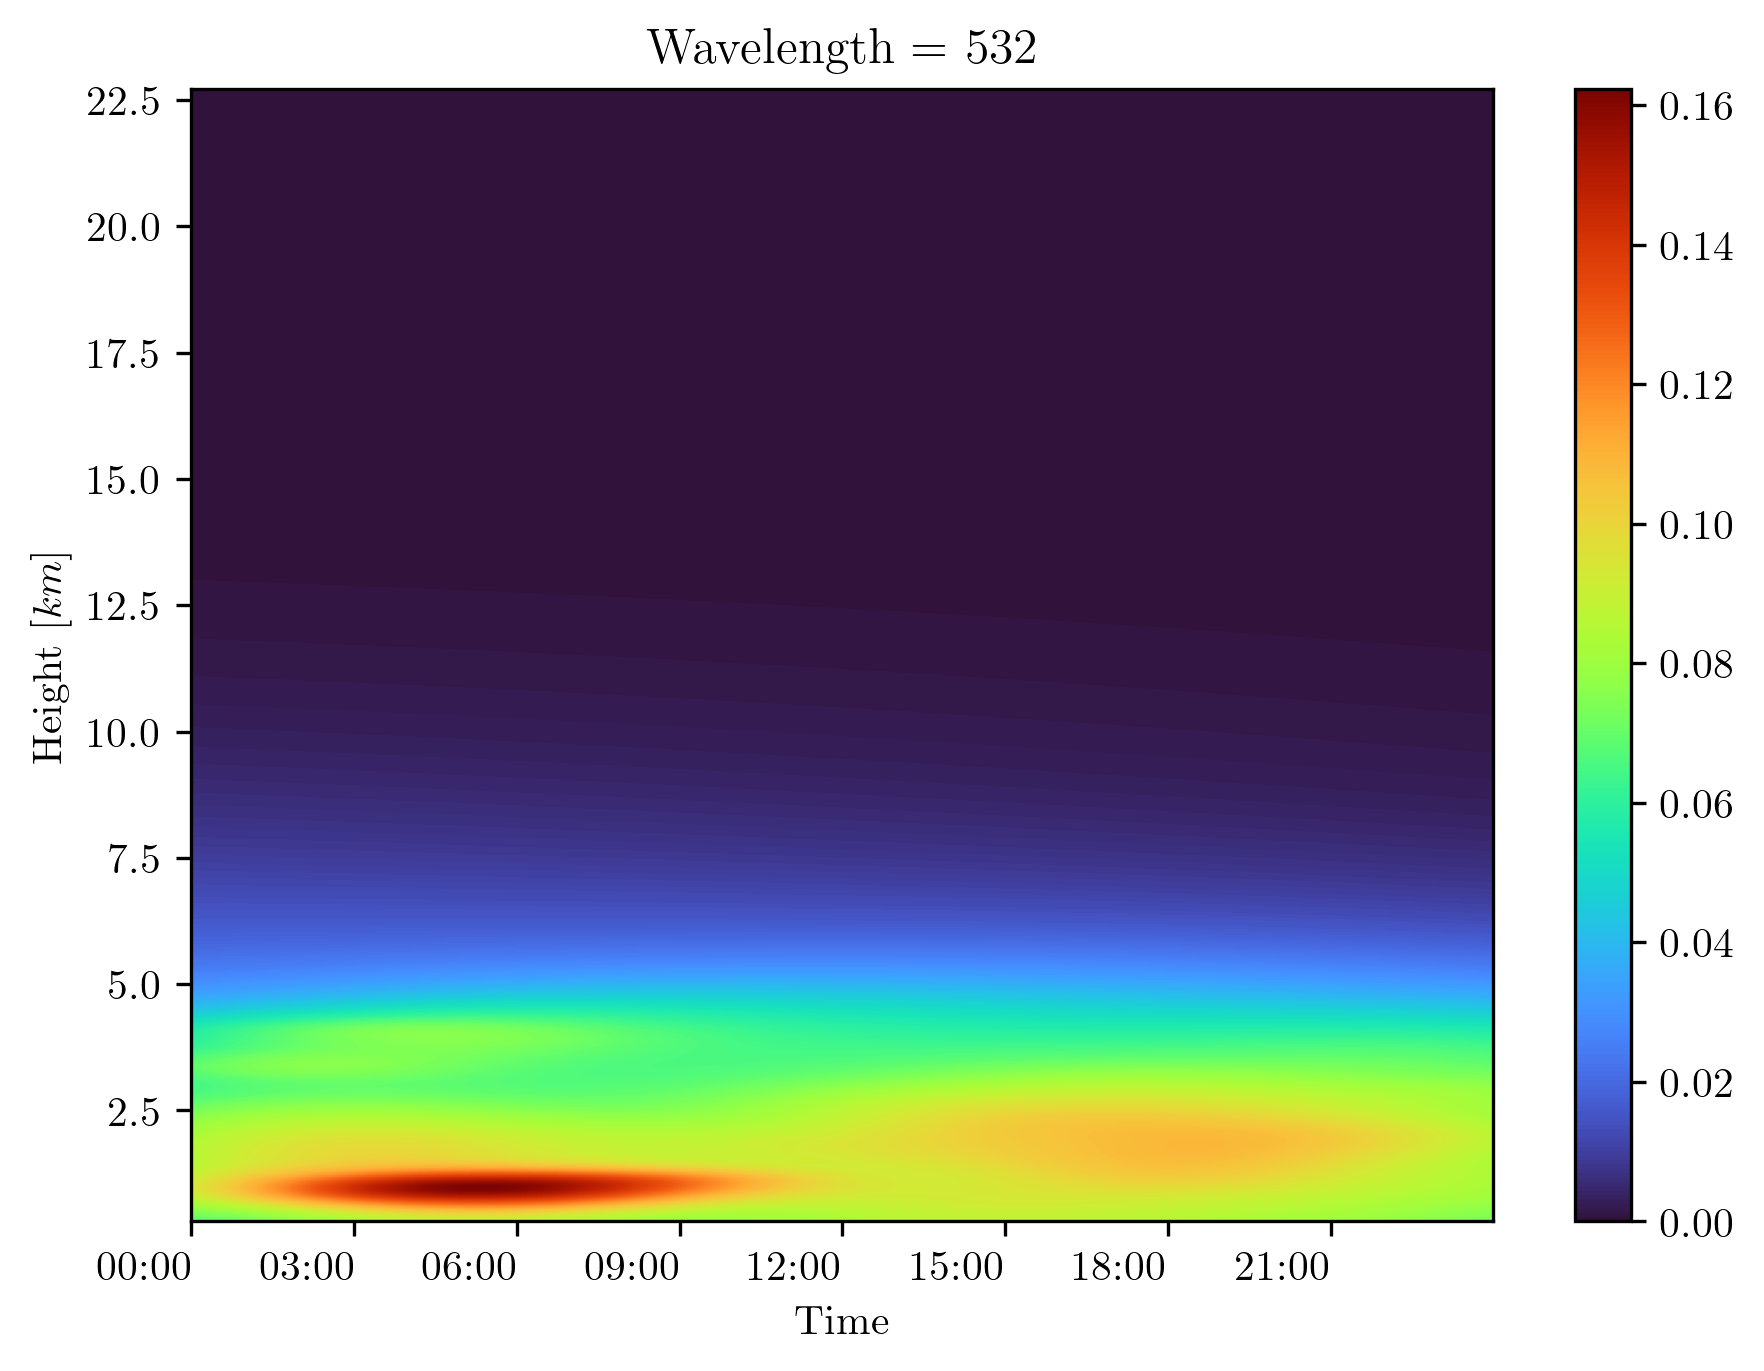

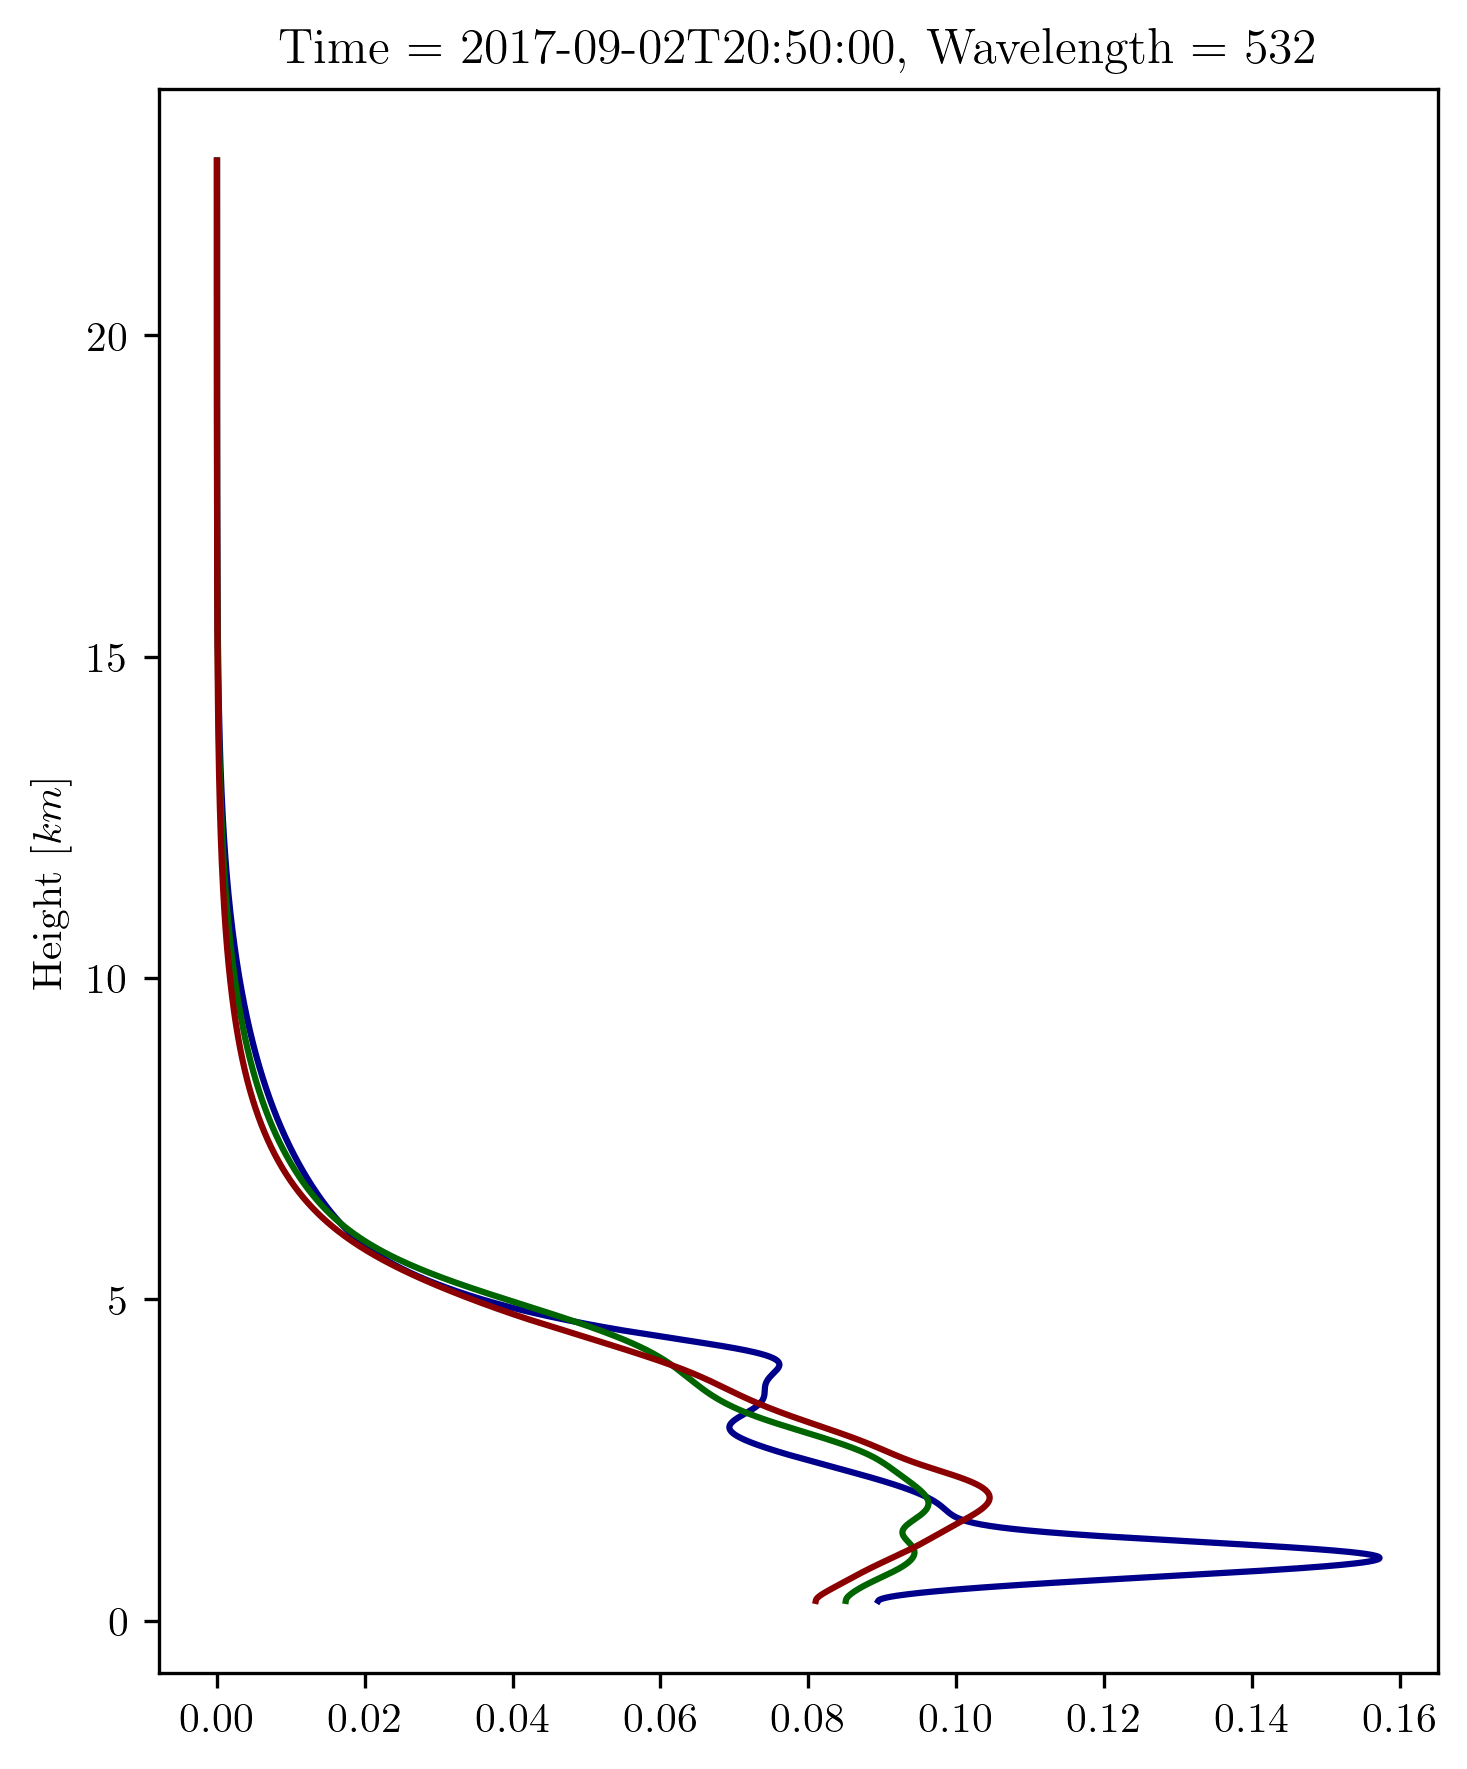

In [60]:
if PLOT_RESULTS:
	fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	ax = axes
	sigma_ratio.plot(cmap='turbo',ax =ax)
	ax.set_title('Normalized weighted density')
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)

	fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	ax = axes
	sigma_g.plot(cmap='turbo',ax =ax)
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)

	fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,6))
	ax = axes
	for t in times:
		sigma_g.sel(Time=t).plot(ax=ax, y = 'Height')
	plt.tight_layout()
	plt.show()

## Calculate Aearosol Optical Depth (AOD)
## $\tau_{aer,\lambda} = \int \sigma_{aer,\lambda} (r) dr\;\; \forall \, r \leq r_{ref} $

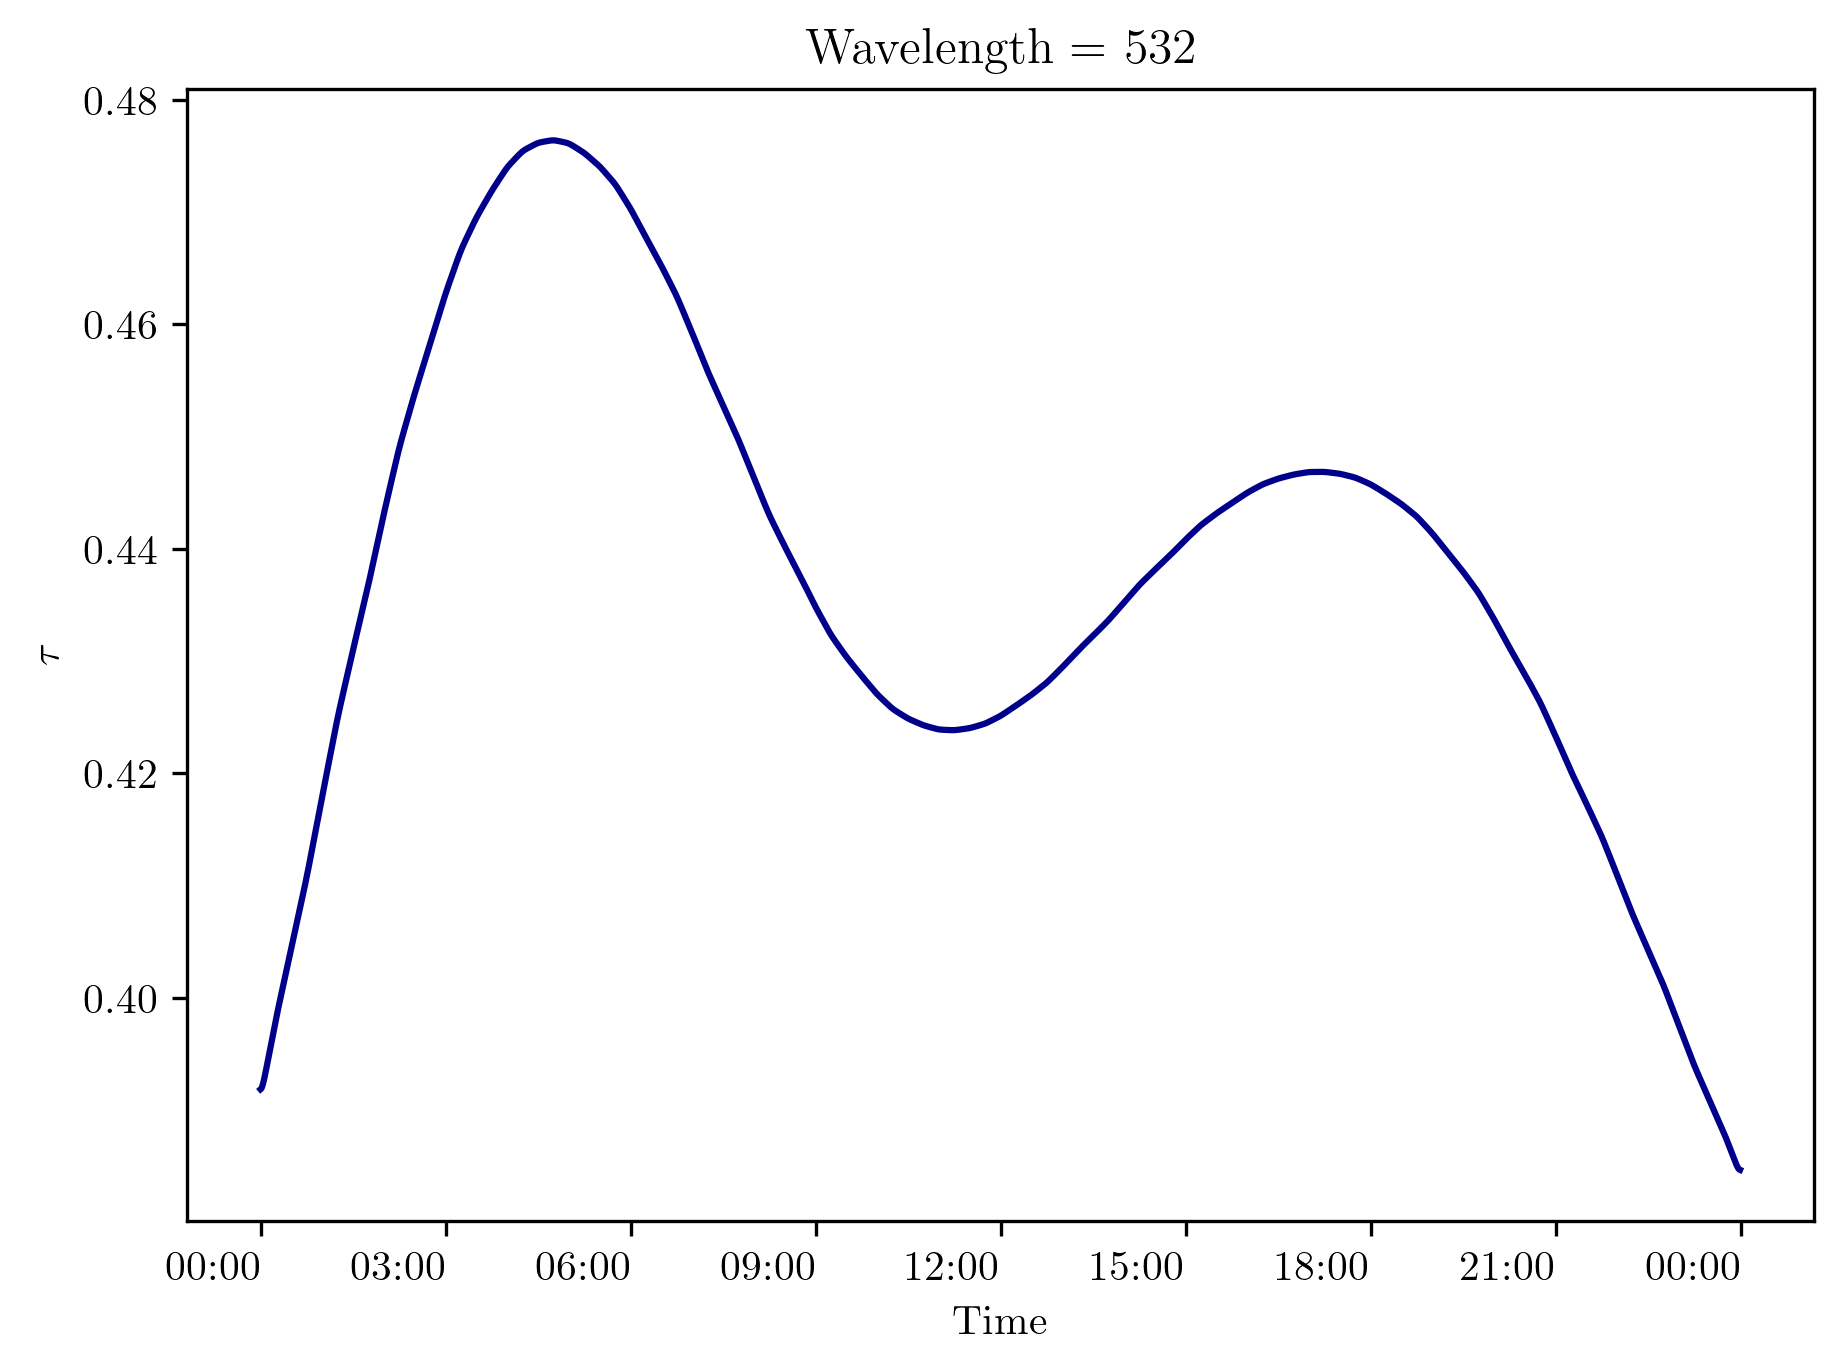

In [61]:
tau_g = dr*sigma_g.sum(dim='Height')
tau_g.name=r'$\tau$'
if PLOT_RESULTS:
	fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	ax = axes
	tau_g.plot(ax=ax)
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

## Angstrom Exponent
1. To convert $\sigma_{aer}$ from $532[nm]$ to $355[nm]$ and $1064[nm]$
2. Typical values of angstrom exponent are from `20170901_20170930_haifa_ang.nc`
3. Sample procedure is done in :`KDE_estimation_sample.ipynb`, and data is loaded from `ds_month_params`

In [62]:
RUN_SINGLE_SAMPLE=False
if RUN_SINGLE_SAMPLE:
	nc_name_aeronet = f"{month_start_day.strftime('%Y%m%d')}_{month_end_day.strftime('%Y%m%d')}_haifa_ang.nc"
	ds_ang = prep.load_dataset(os.path.join(station.aeronet_folder,nc_name_aeronet))

	t_slice =slice(cur_day,cur_day+timedelta(days =1))
	means = []
	for wavelengths in ds_ang.Wavelengths:
		angstrom_mean = ds_ang.angstrom.sel(Wavelengths = wavelengths ,Time=t_slice).mean().item()
		angstrom_std = ds_ang.angstrom.sel(Wavelengths = wavelengths ,Time=t_slice).std().item()

		textstr = ' '.join((
		r'$\mu=%.2f$, ' % (angstrom_mean, ),
		r'$\sigma=%.2f$' % (angstrom_std, )))
		ds_ang.angstrom.sel(Wavelengths = wavelengths ,Time=t_slice).\
			plot(x='Time',label =fr"$ \AA \, {wavelengths.item()}$, "+textstr)
		means.append(angstrom_mean)
	plt.legend()
	plt.show()
	ang_532_10264 = means[2]
	ang_355_532 = means[0]

## Estimate AOD of $\lambda=1064nm$ and  $\lambda=355nm$

$\tau_{1064} = \frac{\tau_{532}}{(532/1064)^{-A_{532,1064}}}$

$\tau_{355} =\tau_{532} \cdot (355/532)^{-A_{355,532}} $

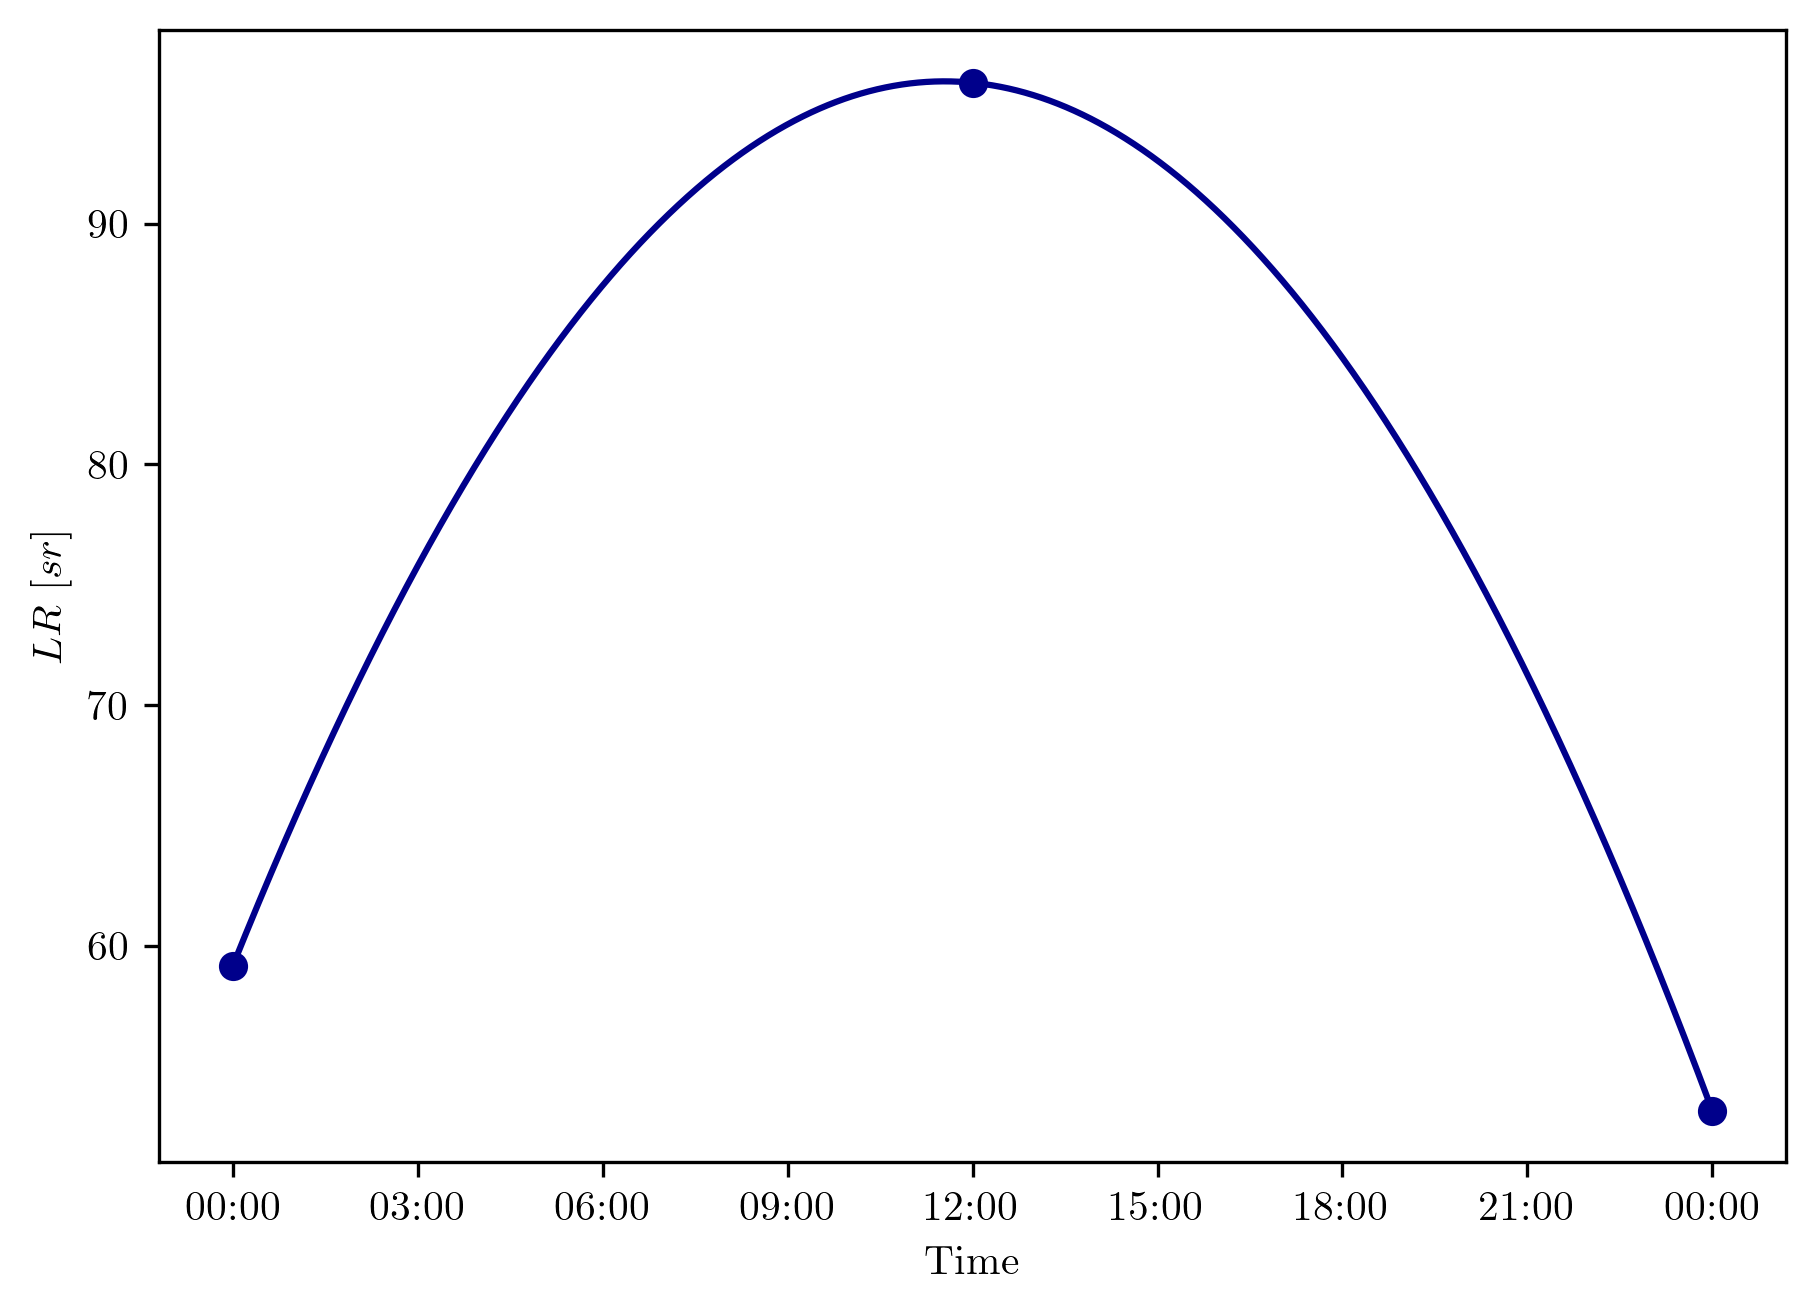

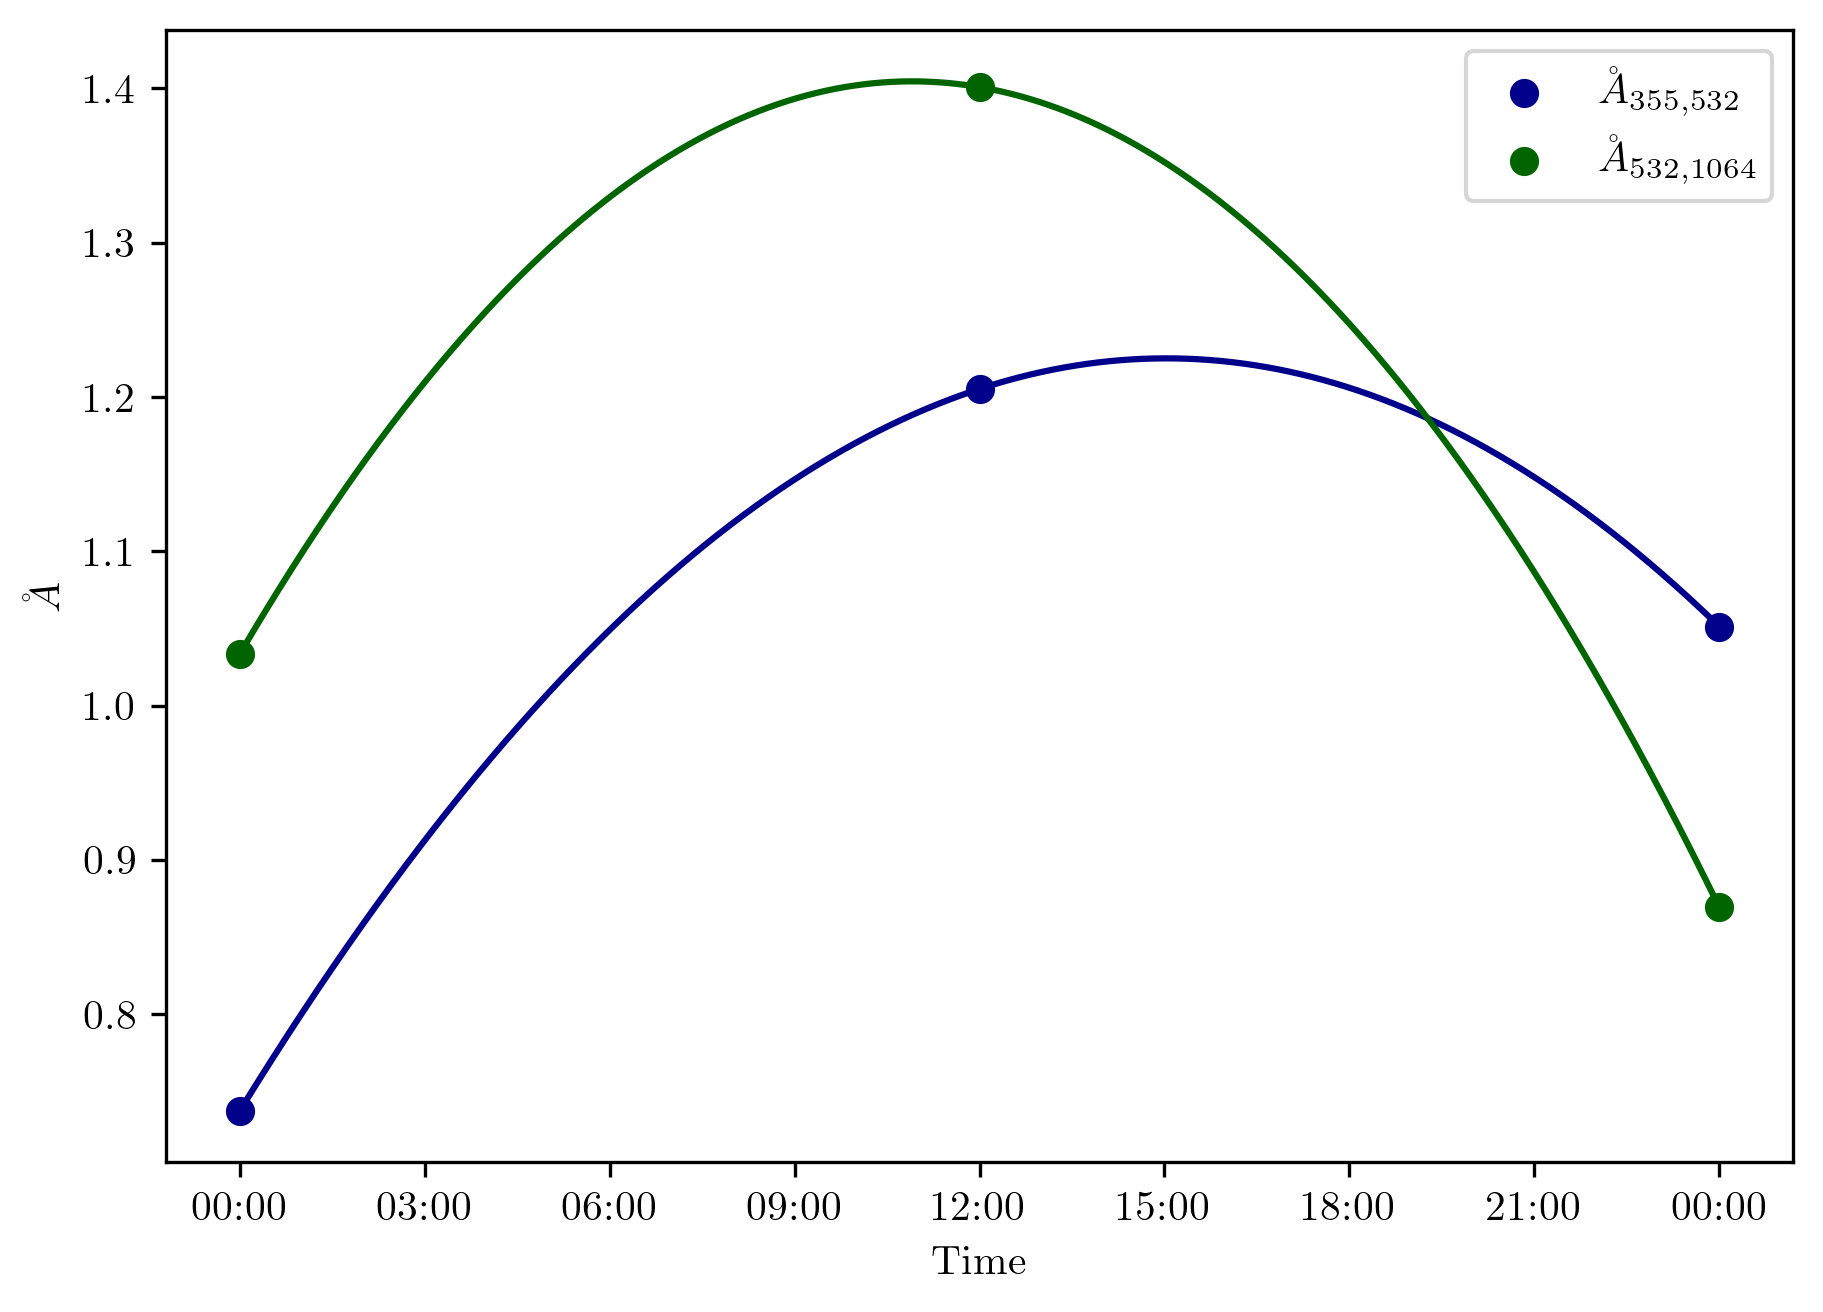

In [63]:
ang355532s = ds_day_params.ang355532.values
ang5321064s = ds_day_params.ang5321064.values
LRs = ds_day_params.LR.values

tbins = np.round( [int(dt2binscale(datetime.utcfromtimestamp ( dt.tolist ( ) / 1e9 ))) for
                   dt in ds_day_params.ang355532.Time.values])
# Workaround to handle missing values at last day. TODO: this should be fixed in KDE_estimation_sample.ipynb.
if tbins[-1]>0:
	tbins = np.append(tbins,2880)
	ang355532s= np.append(ang355532s, ang355532s.mean())
	ang5321064s= np.append(ang5321064s,ang5321064s.mean())
	LRs= np.append(LRs,LRs.mean())
else:
	tbins[2] =2880


cs_355532 = CubicSpline(tbins, ang355532s)
cs_5321064 = CubicSpline(tbins, ang5321064s)
cs_LR = CubicSpline(tbins, LRs)
LR = cs_LR(np.arange(time_index.size))
if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	ax.plot(time_index.tolist(), LR )
	ds_day_params.plot.scatter(y='LR',x='Time',ax=ax)#.plot.(ax=ax)
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

ang_355_532 = cs_355532(np.arange(time_index.size))
ang_532_10264 =  cs_5321064(np.arange(time_index.size))

if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	ds_day_params.plot.scatter(y='ang355532',x='Time',ax=ax,label=ds_day_params.ang355532.long_name)
	ax.plot(time_index.tolist(), ang_355_532 )
	ds_day_params.plot.scatter(y='ang5321064',x='Time',ax=ax,label=ds_day_params.ang5321064.long_name)
	ax.plot(time_index.tolist(), ang_532_10264 )
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	ax.set_ylabel(r'$\AA$')
	plt.legend()
	plt.show()

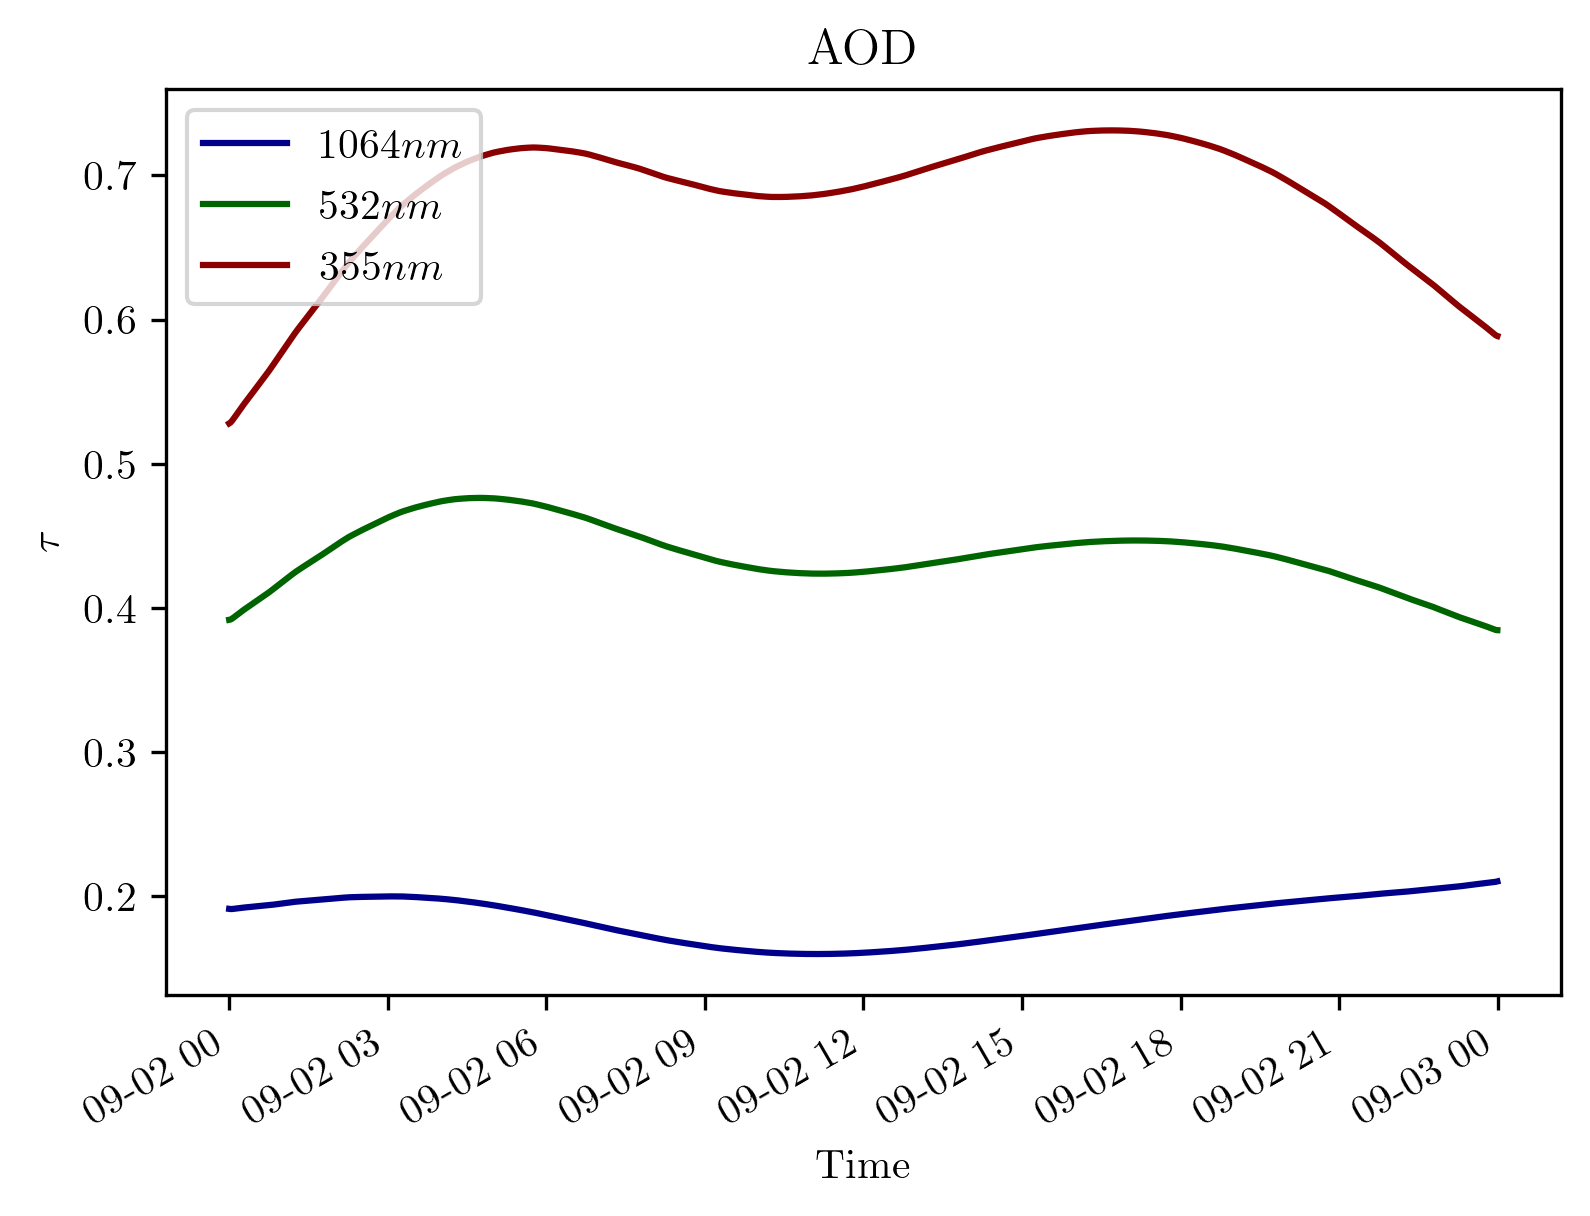

In [64]:
tau_ir = (tau_g/((532/1064)**(-ang_532_10264))).copy(deep=True)
tau_ir['Wavelength'] = 1064
tau_uv = (tau_g*((355/532)**(-ang_355_532))).copy(deep=True)
tau_uv['Wavelength'] = 355

if PLOT_RESULTS:
	tau_ir.plot(label=r'$1064nm$')
	tau_g.plot(label=r'$532nm$')
	tau_uv.plot(label=r'$355nm$')
	plt.title('AOD')
	plt.legend()
	plt.show()

Normalizing the original density of sigma per time

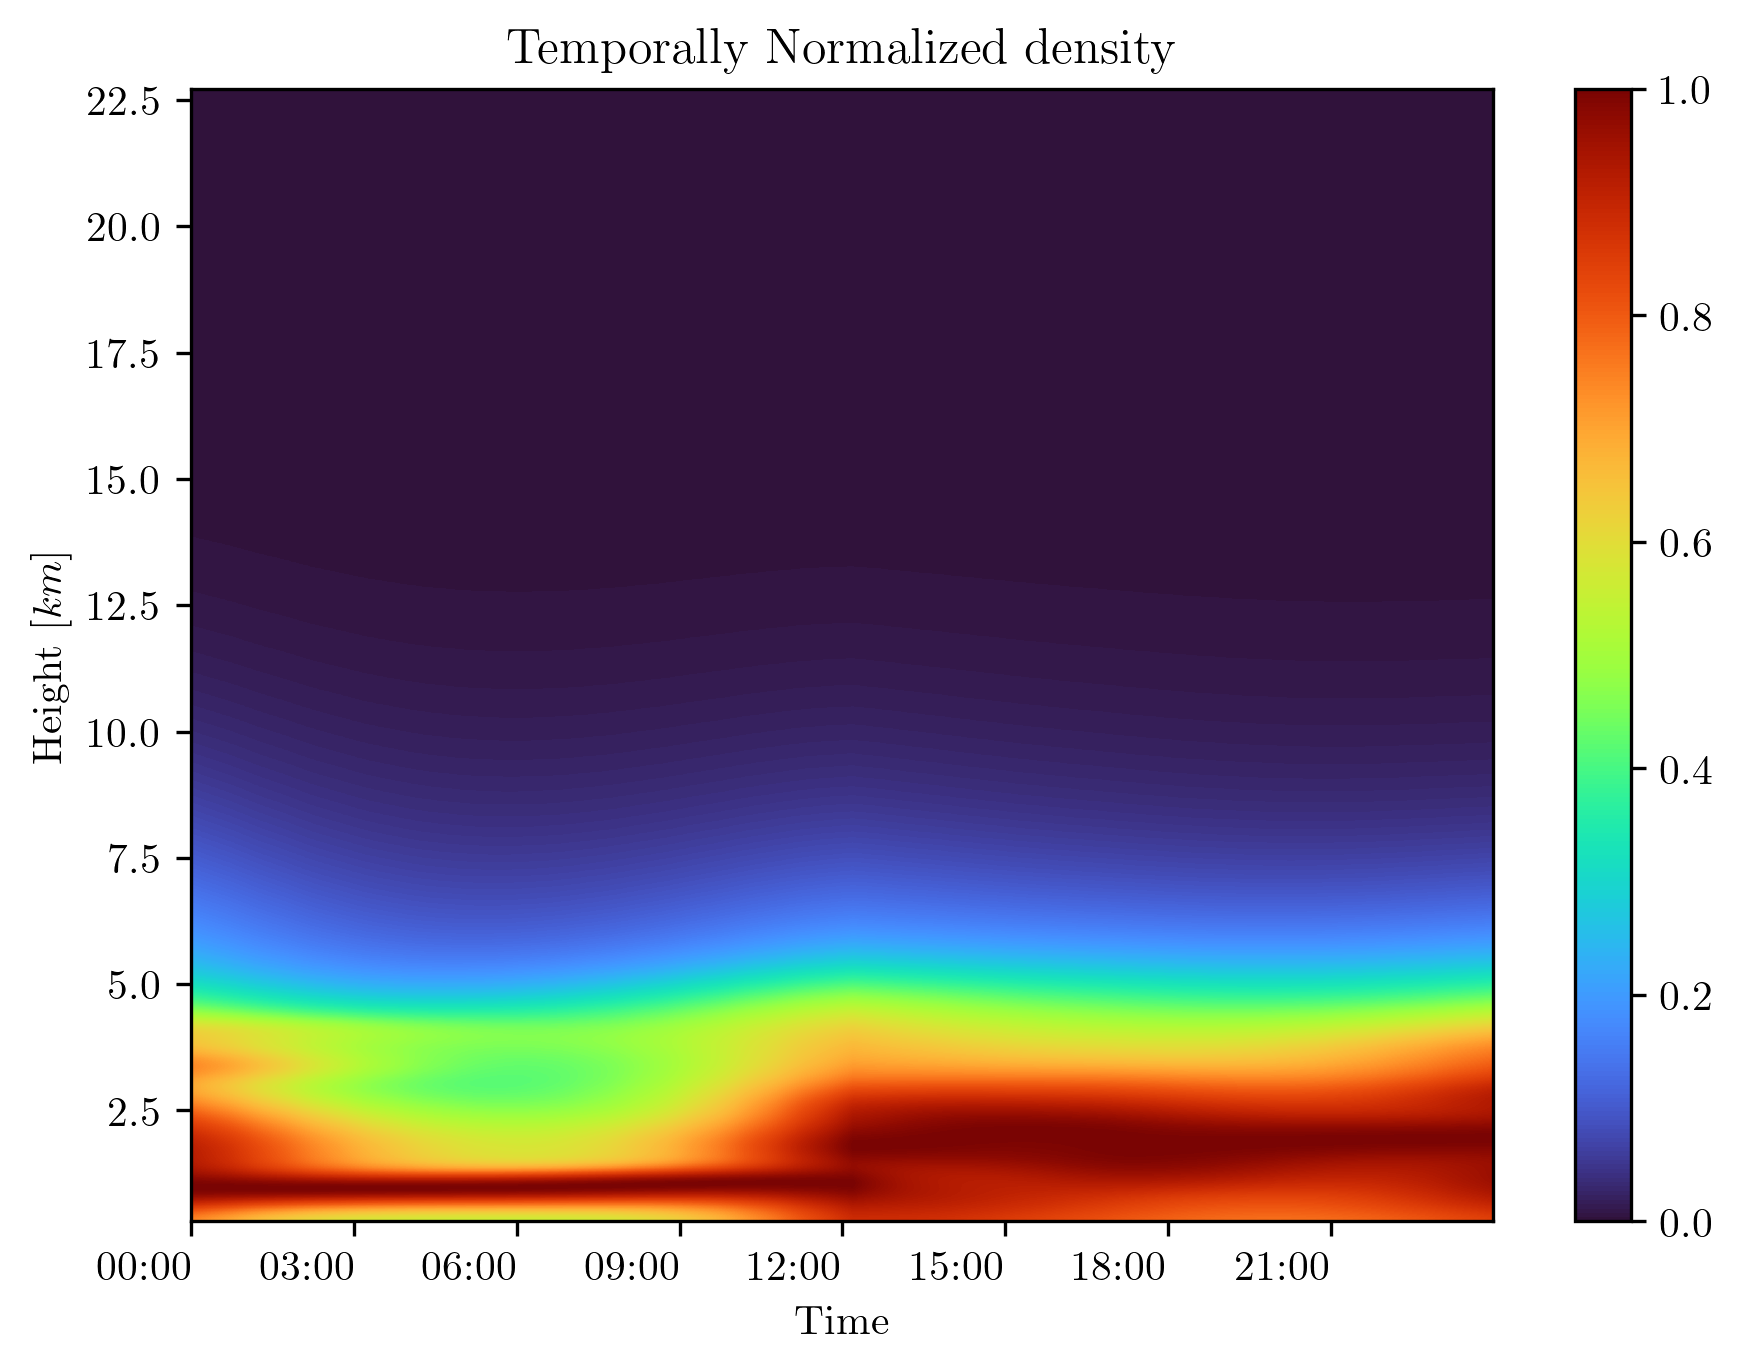

In [65]:
sigma_normalized = xr.apply_ufunc(lambda x: normalize(x),sigma_ratio, keep_attrs = True).copy(deep=True)
for t in sigma_normalized.Time:

	sigma_t = sigma_normalized.sel(Time=t).copy(deep=True)
	sigma_t = xr.apply_ufunc(lambda x: normalize(x),sigma_t)
	sigma_normalized.loc[dict(Time=t)] = sigma_t

if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	sigma_normalized.plot(cmap='turbo')
	plt.title('Temporally Normalized density')
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

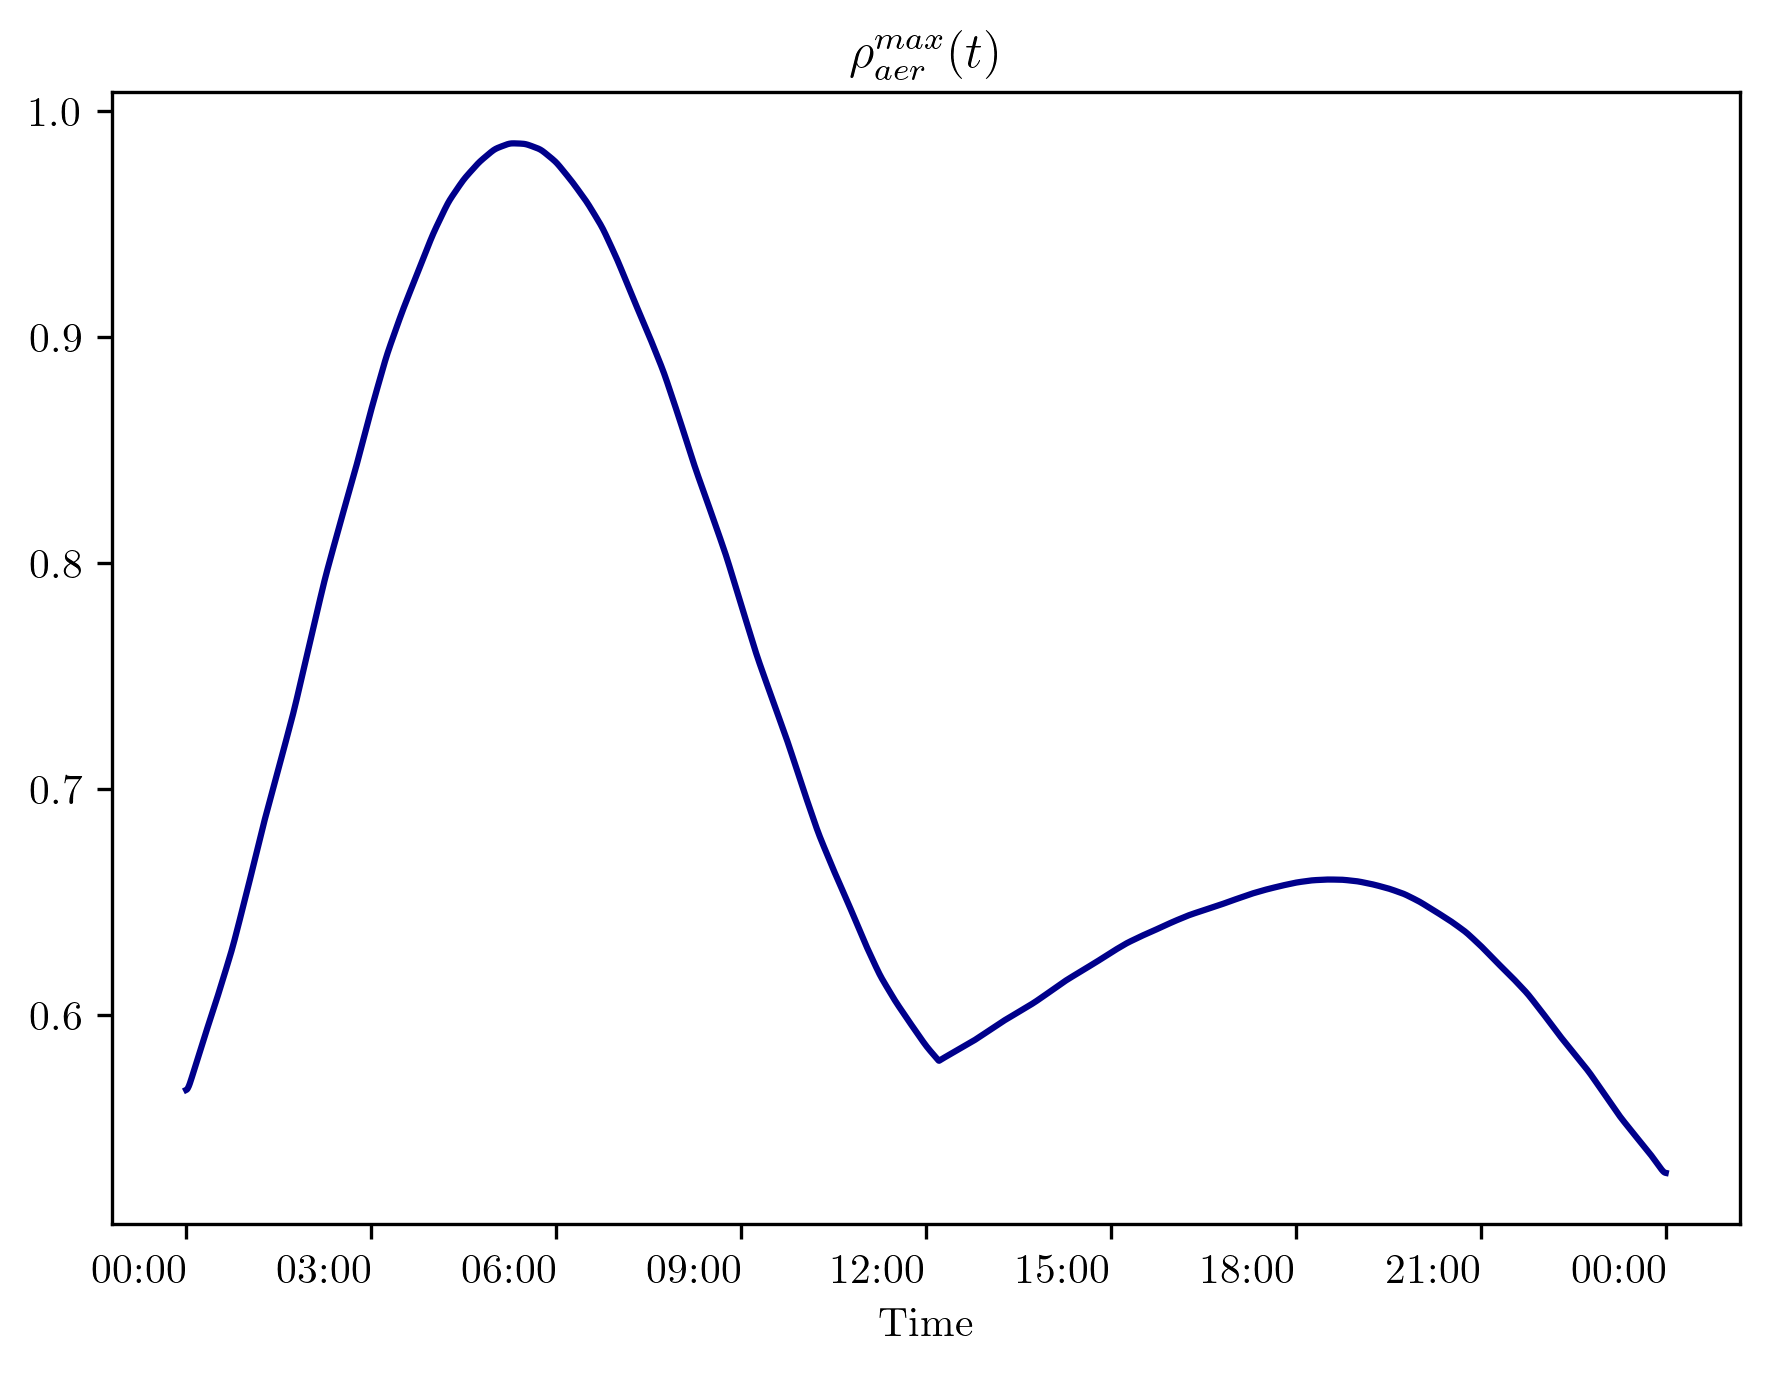

In [66]:
if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	sigma_ratio.max(dim='Height').plot(ax=ax)
	ax.set_title(r'$\rho_{aer}^{max}(t)$')
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

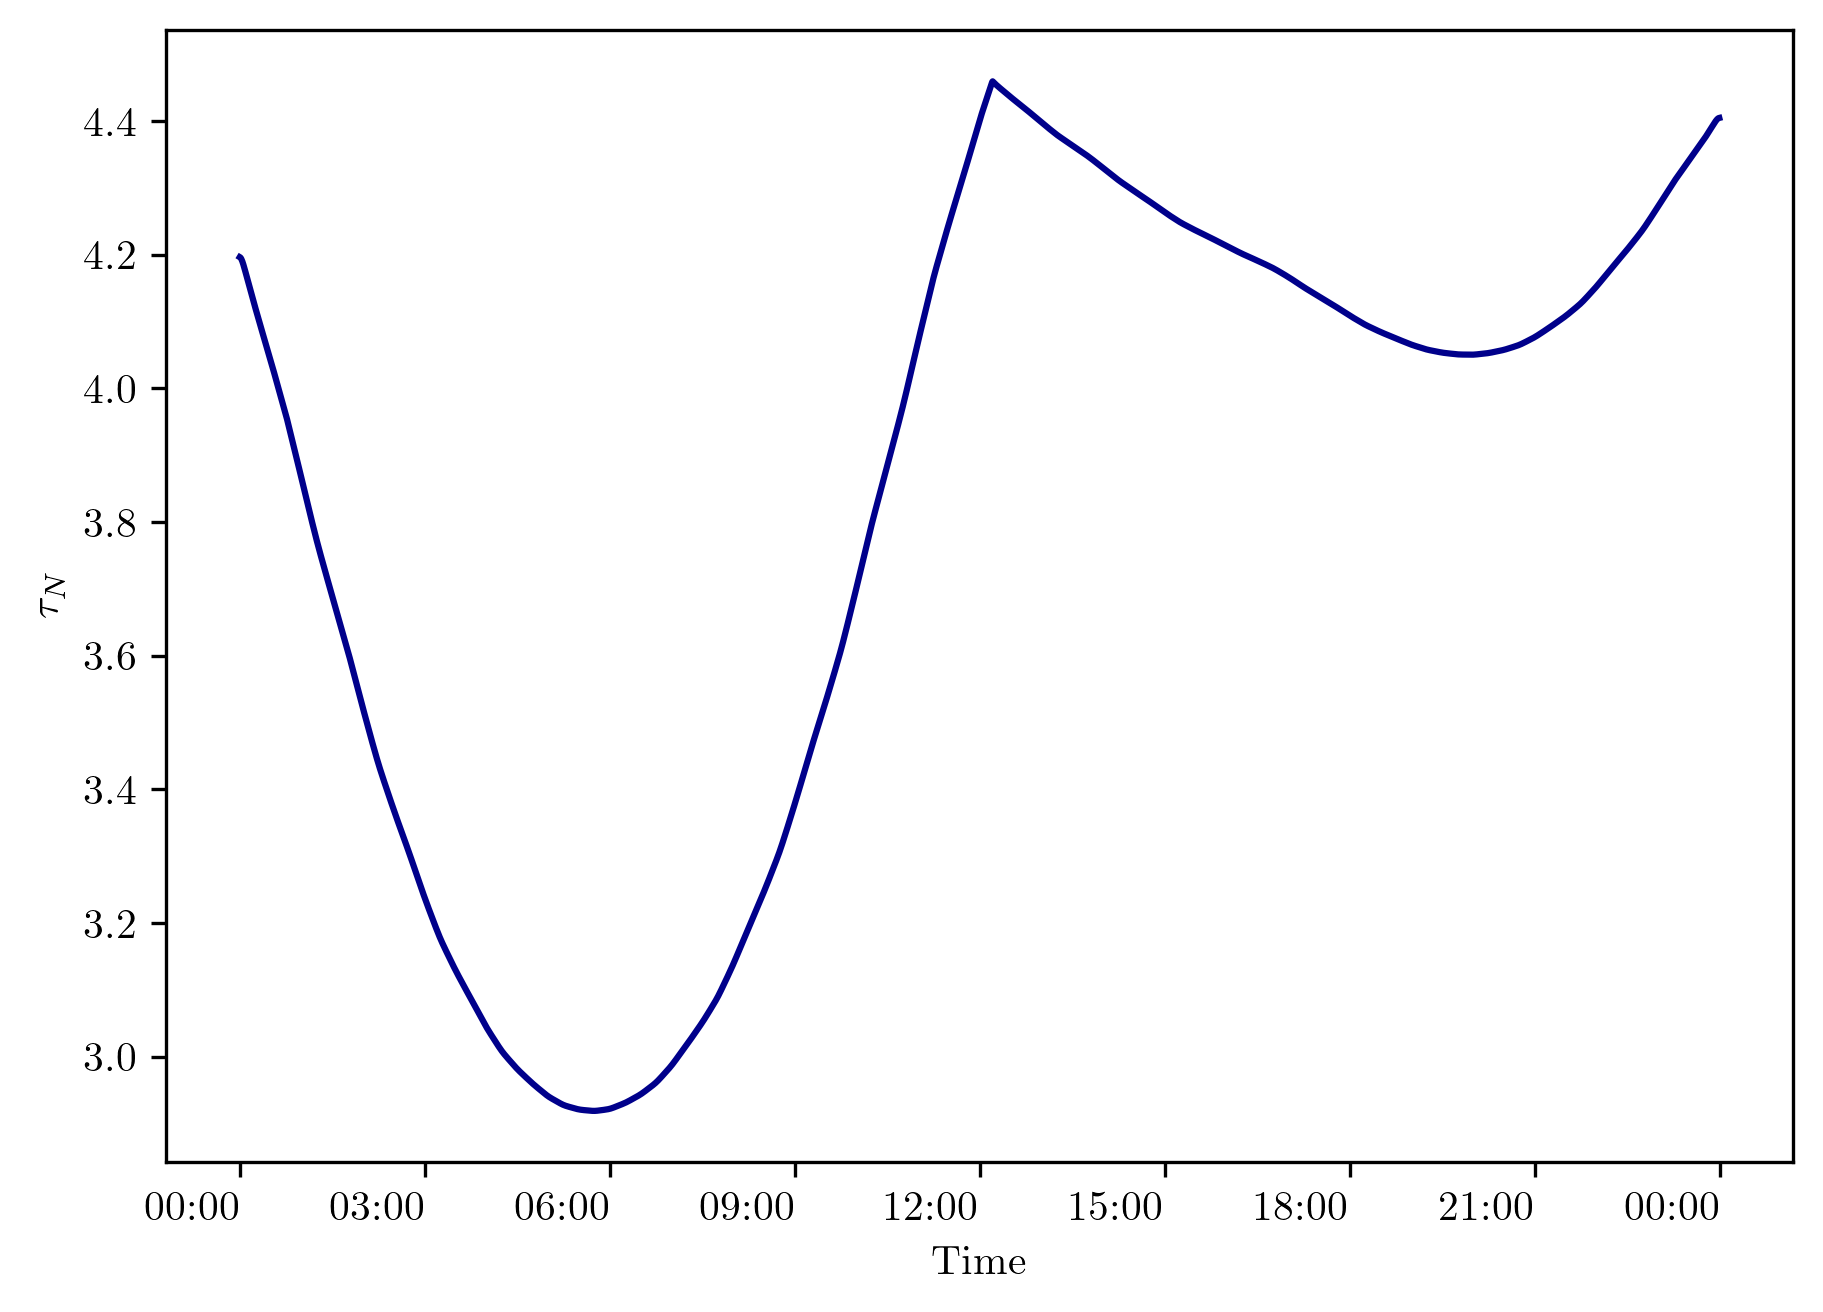

In [67]:
tau_normalized = dr*sigma_normalized.sum(dim='Height')
tau_normalized.name=r'$\tau_N$'
if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	plt.title('Normalized AOD')
	tau_normalized.plot(ax=ax)
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

convert $\sigma_{1064}$

### $\sigma_{1064}^{max}(t) = \frac{\tau_{1064}(t)}{\tau_N(t)}, \;\forall\, t \in Time_{day} $

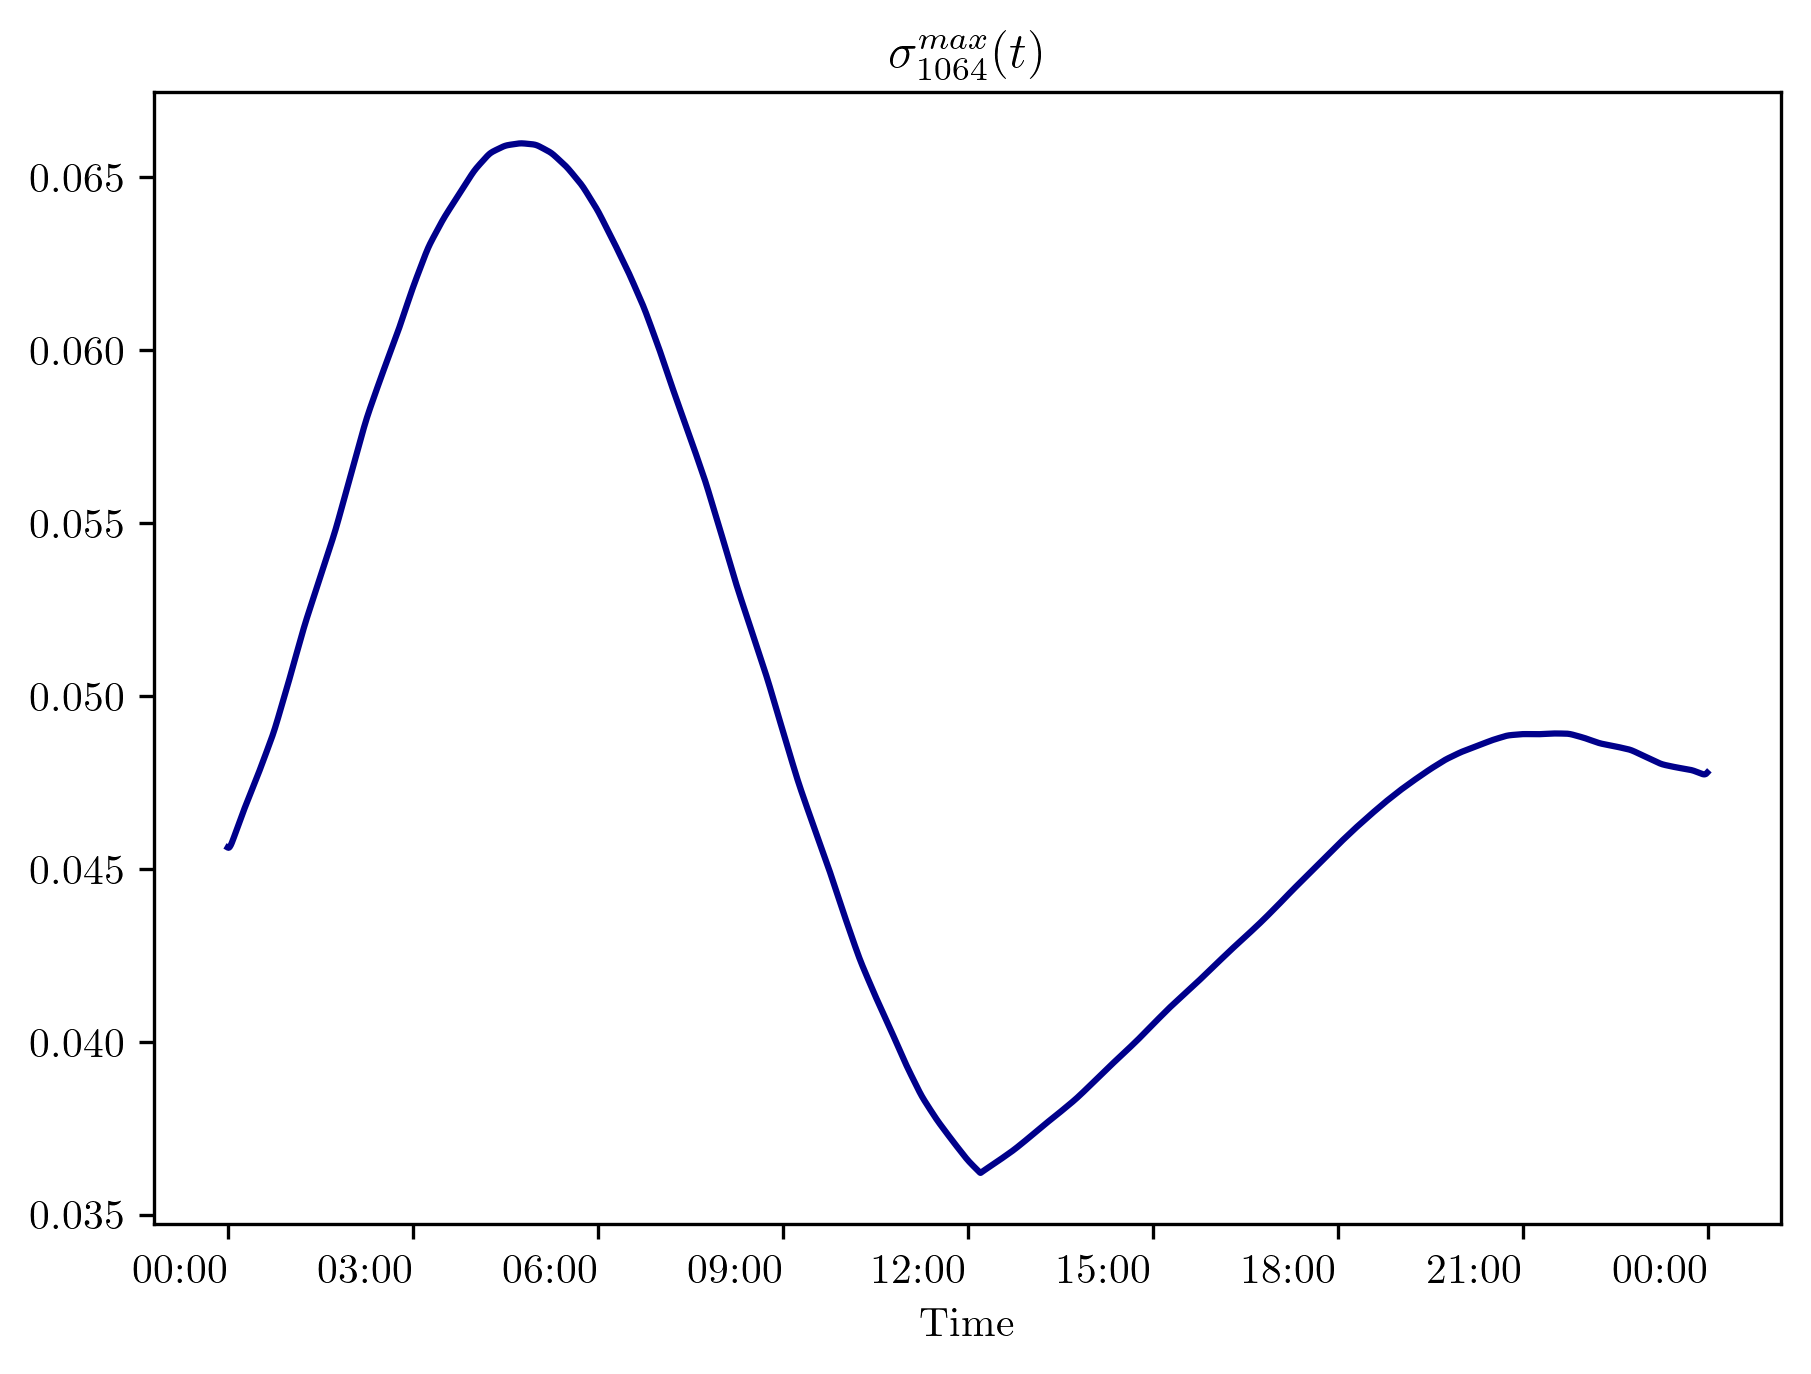

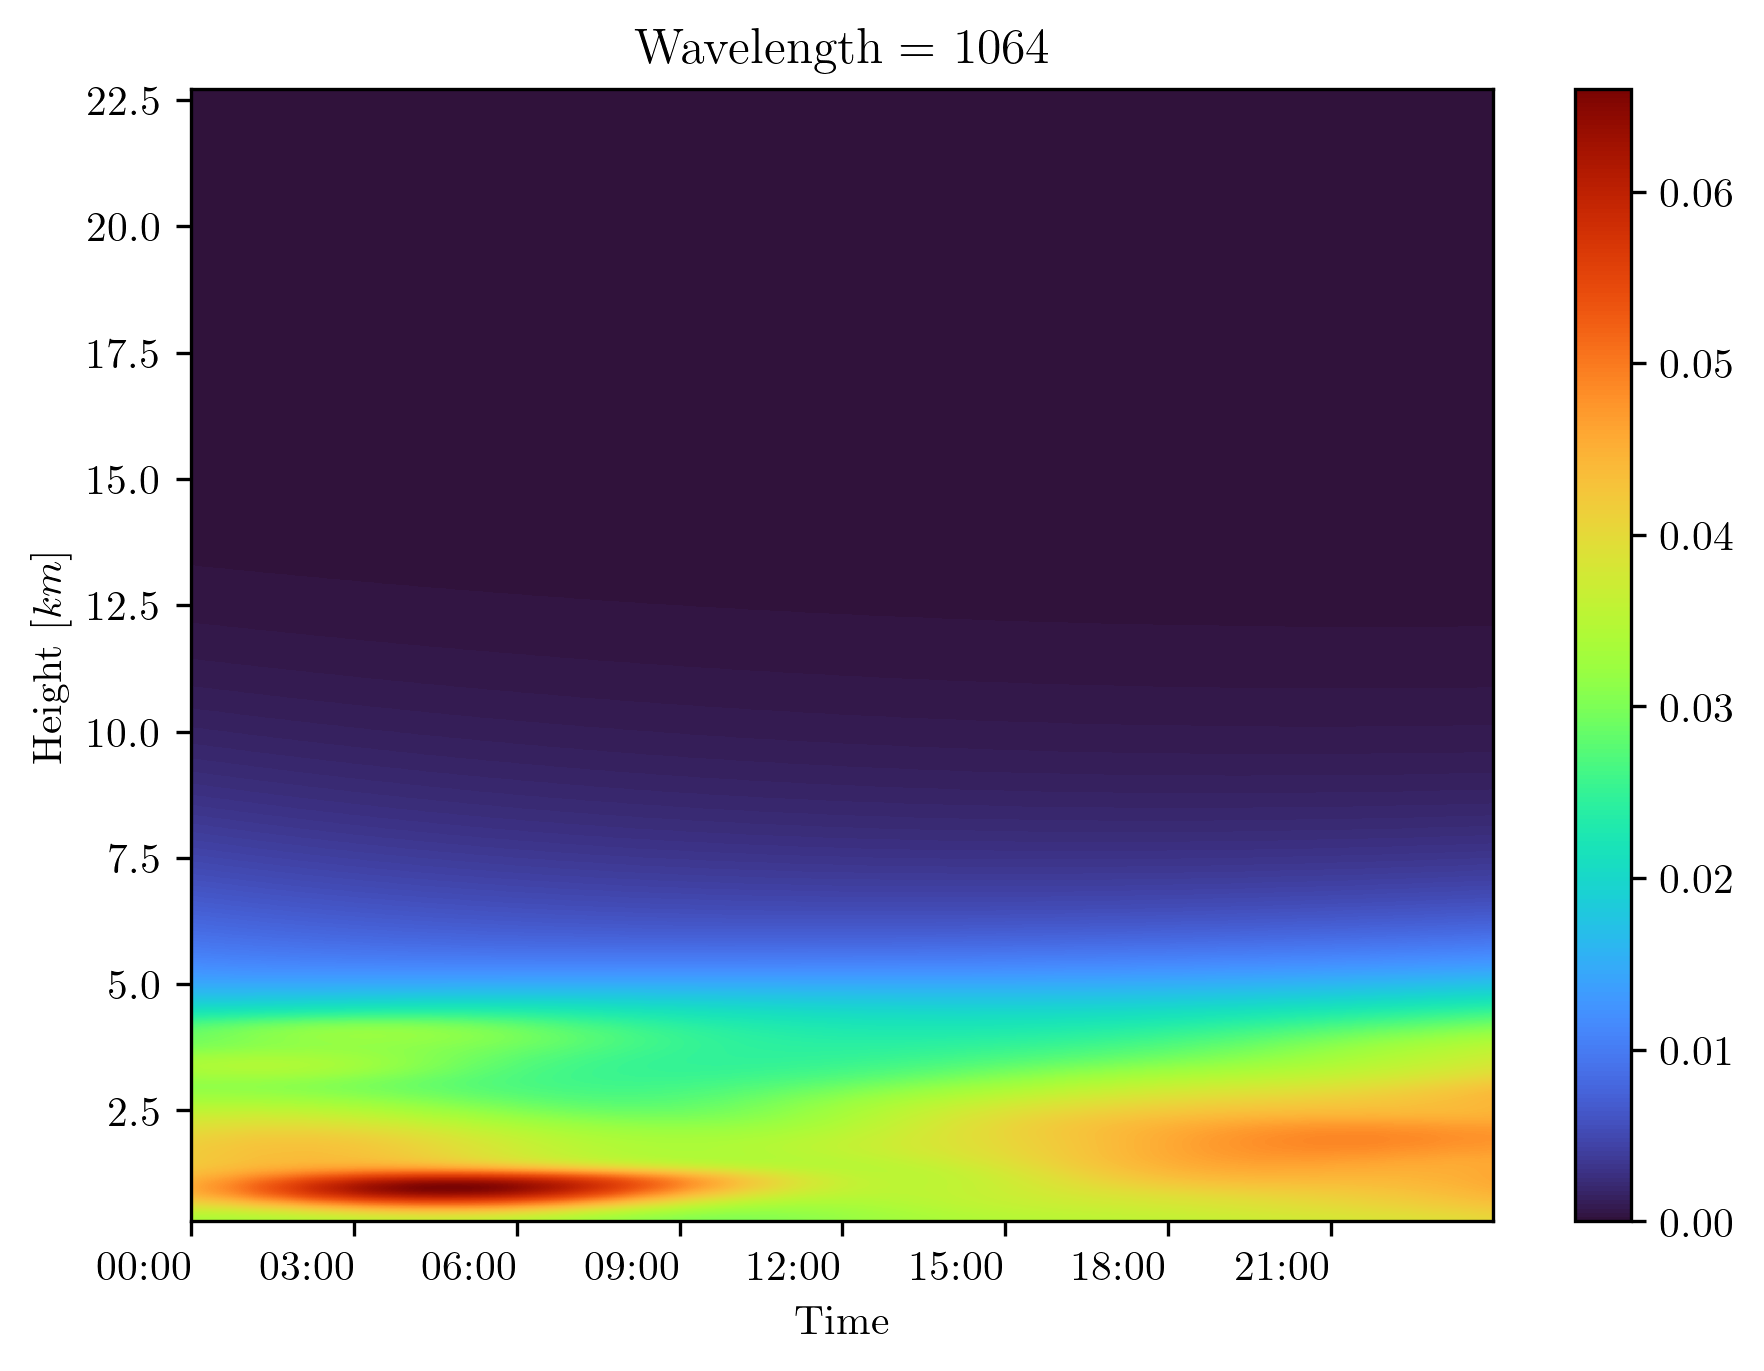

In [68]:
sigma_max = tau_ir/tau_normalized
sigma_ir = sigma_normalized*sigma_max

if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	sigma_max.plot()
	ax.set_title(r'$\sigma^{max}_{1064}(t) $')
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	sigma_ir.plot(cmap='turbo',ax=ax)
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

convert $\sigma_{1064}$

### $\sigma_{355}^{max}(t) = \frac{\tau_{355}(t)}{\tau_N(t)}, \;\forall\, t \in Time_{day} $

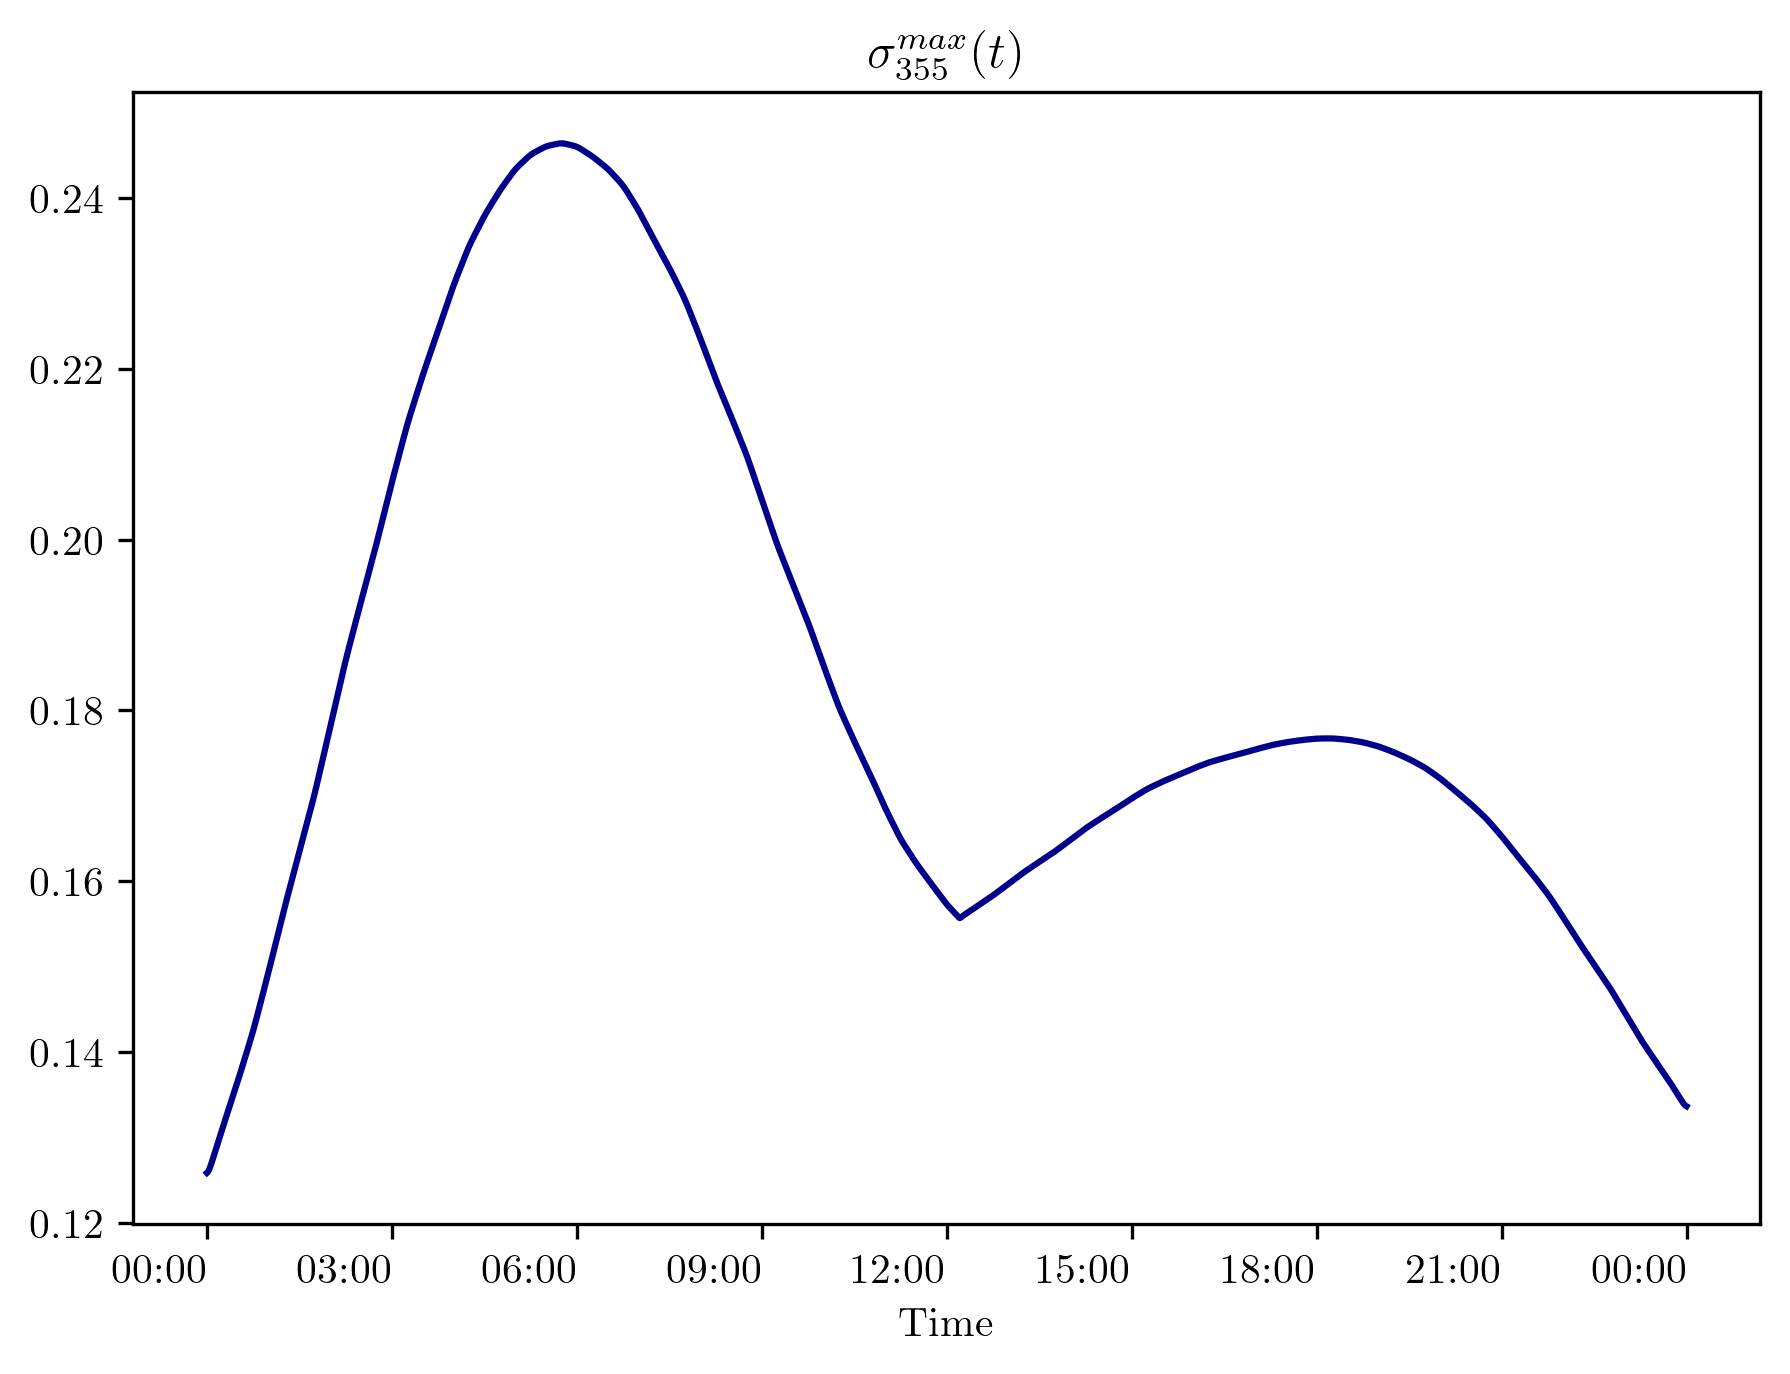

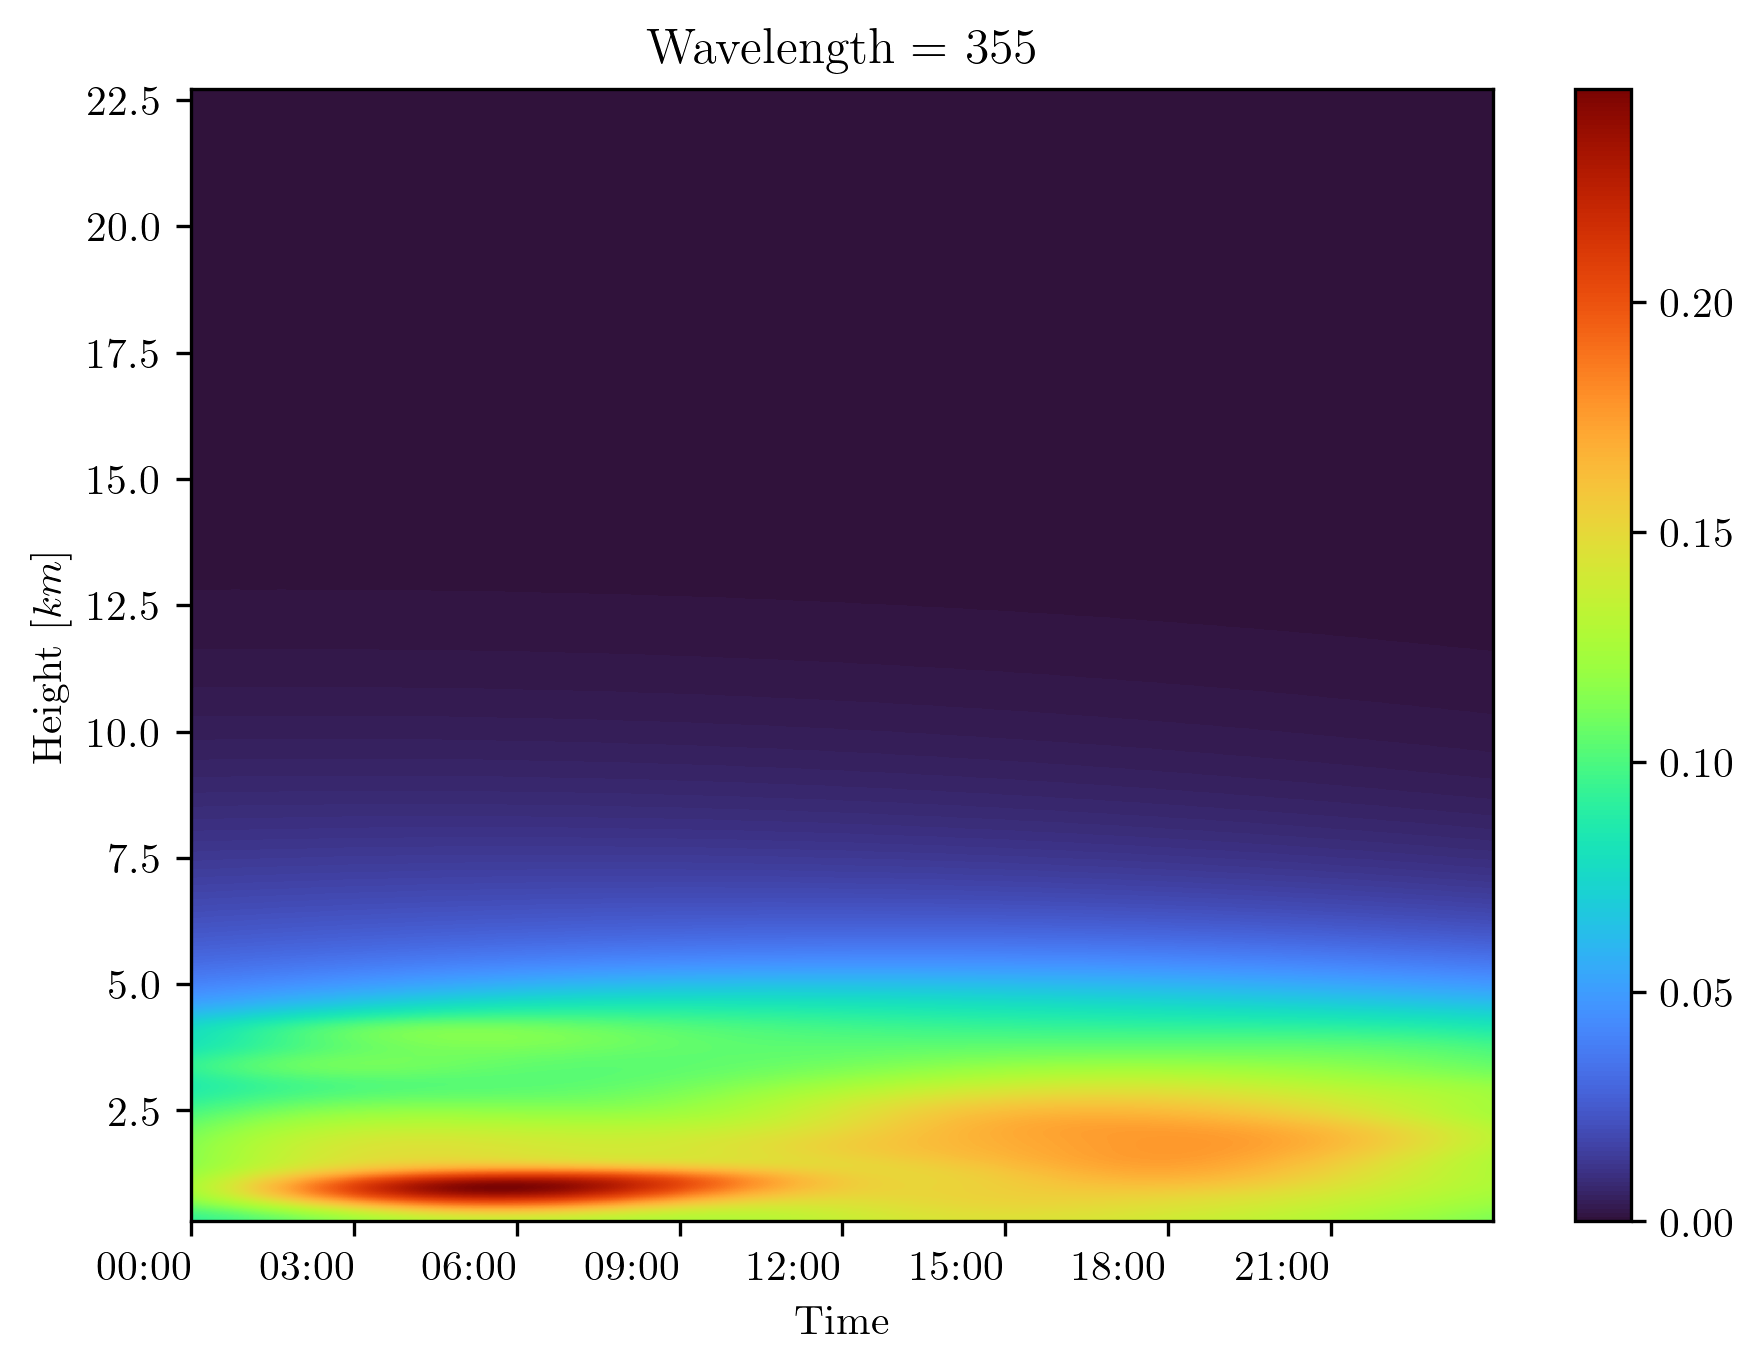

In [69]:
sigma_max = tau_uv/tau_normalized
sigma_uv = sigma_normalized*sigma_max
if PLOT_RESULTS:
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	sigma_max.plot(ax=ax)
	ax.set_title(r'$\sigma^{max}_{355}(t) $')
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
	sigma_uv.plot(cmap='turbo',ax=ax)
	ax.xaxis.set_major_formatter(timeformat)
	ax.xaxis.set_tick_params(rotation=0)
	plt.show()

## Extinction profiles of $\sigma_{aer}$ at different times

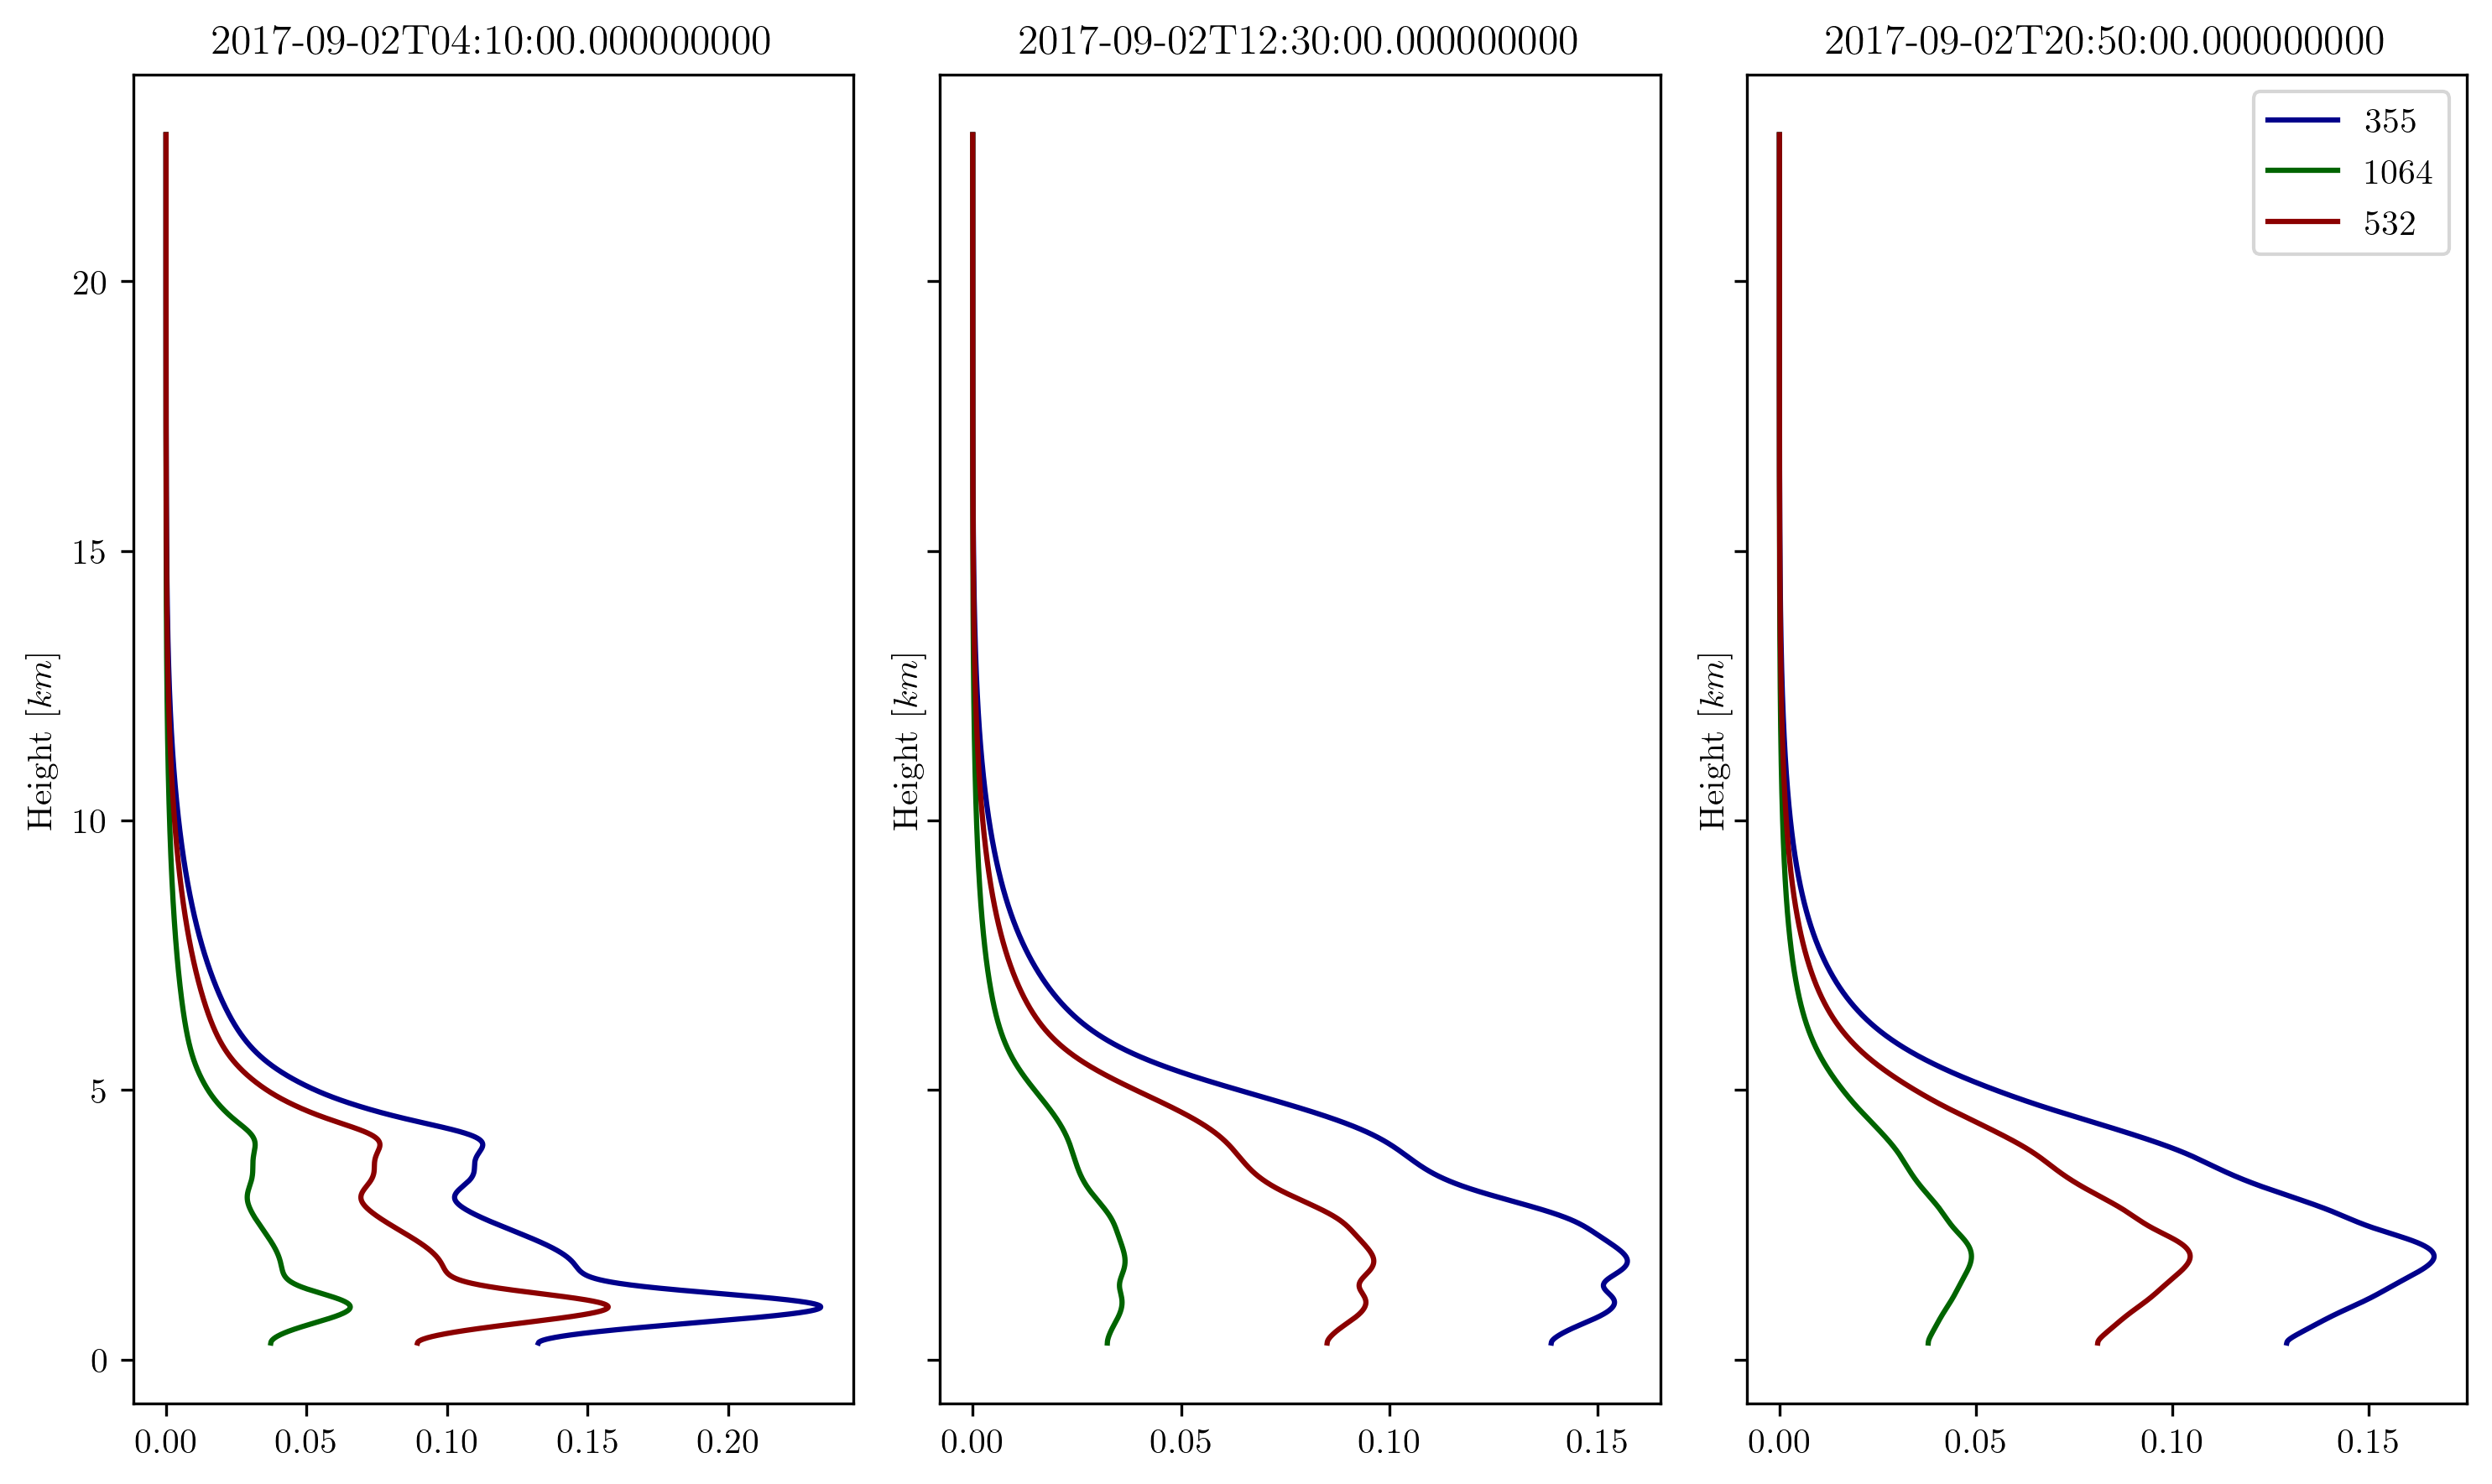

In [70]:
if PLOT_RESULTS:
	t_index = [500,1500,2500]
	times = [ds_density.Time[ind].values for ind in t_index]

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,6),sharey = True)
	for t, ax in zip(times,axes.ravel()):
		sigma_uv.sel(Time = t).plot.line(ax= ax,y='Height',label=sigma_uv.Wavelength.item())
		sigma_ir.sel(Time = t).plot.line(ax= ax,y='Height',label=sigma_ir.Wavelength.item())
		sigma_g.sel(Time = t).plot.line(ax= ax,y='Height',label=r'$532$')

		ax.set_title(t)
	plt.legend()
	plt.tight_layout()
	plt.show()

## Calculate $\beta_{aer}$ , e.g. assuming the lidar ratio $LR=60[sr]$

In [71]:
# %%  Creating Daily Lidar Aerosols' sigma dataset
sigma_ds = xr.concat([sigma_uv,sigma_g,sigma_ir],dim='Wavelength')
sigma_ds.attrs = {'info': "Daily aerosols' generated extinction coefficient",
                  'long_name':r'$\sigma$','units':r'$1/km$'}


# %%  Creating Daily Lidar Aerosols' beta dataset
beta_ds = xr.apply_ufunc(lambda sigma,LR: sigma/LR ,sigma_ds, LR , keep_attrs=True)
beta_ds.attrs = {'info': "Daily aerosols' generated backscatter coefficient",
                 'long_name':r'$\beta$','units':r'$1/km \cdot sr$'}

Creating Daily Lidar Aerosols' dataset with:
- beta
- sigma
- Generation parameters
    1. $\sigma_{532}^{max}$ - max value from Tropos retrievals calculated as $\beta_{532}^{max}\cdot LR$, $LR=55sr$  (Tropos assumption)
    2. $A_{532,1064}$ - Angstrom exponent of 532-1064, as a daily mean value calculated from AERONET
    3. $A_{355,532}$ - Angstrom exponent of 355-532, as a daily mean value calculated from AERONET
    4. $LR$ - Lidar ratio, corresponding to Angstroms values (based on literature and TROPOS)
    5. $r_{max}$ - top height of aerosol layer. Taken as $\sim1.25\cdot r_{max}$, $s.t.\; r_{max}$ is the maximum value of the reference range from TROPOS retrievals of that day.
- Source files:
    1. nc_name_aeronet - netcdf file post-processed from AERONET retrivals, using: read_AERONET_dat.py ( for angstrom values)
    2. ds_extended - calibration dataset processed from TROPOS retrivals, using dataseting.py (for r_mx, sigma_max values)

In [72]:
# %%  Creating Daily Lidar Aerosols' dataset
ds_aer = xr.Dataset()
ds_aer = ds_aer.assign(
    sigma = sigma_ds, beta = beta_ds,
    max_sigma_g = xr.Variable(dims =() ,data=sigma_532_max, attrs={'long_name': r'$\sigma_{532}^{max}$' , 'units':r'$1/km$',
                                           'info':r'A generation parameter. The maximum extinction value from '
                                           r'Tropos retrievals calculated as $\beta_{532}^{max}\cdot LR$, $LR=55sr$'}),
    ang_532_1064 = xr.Variable(dims =('Time') ,data=ang_532_10264, attrs={'long_name': r'$A_{532,1064}$' ,
                                           'info':r'A generation parameter. Angstrom exponent of 532-1064.'
                                                  r' The daily mean value calculated from AERONET level 2.0'}),
    ang_355_532 = xr.Variable(dims =('Time') ,data=ang_355_532, attrs={'long_name': r'$A_{355,532}$' ,
                                           'info':r'A generation parameter. Angstrom exponent of 355-532.'
                                                  r' The daily mean value calculated from AERONET level 2.0'}),
    LR = xr.Variable(dims =('Time') ,data=LR, attrs={'long_name': r'$\rm LR$' , 'units':r'$sr$',
                                           'info':r'A generation parameter. A lidar ratio, corresponds to Angstroms values (based on literature and TROPOS)'}),
    r_max = xr.Variable(dims =() ,data=ref_height, attrs={'long_name': r'$r_{max}$' , 'units':r'$km$',
                                           'info':r'A generation parameter. Top height of aerosol layer.'
                                                  r' Taken as $\sim1.25\cdot r_{max}$, $s.t.\; r_{max}$ is the maximum value of'
                                                  r' the reference range from TROPOS retrievals, for the date.'}),
    params_source = xr.Variable(dims=(),data=os.path.join(gen_source_path),
                             attrs={'info':'netcdf file name, containing generated density parameters,'
                                           ' using: KDE_estimation_sample.ipynb .'}))
ds_aer.attrs = {'info': 'Daily generated aerosol profiles',
                'source_file': 'generate_density.ipynb', # for python module: os.path.basename(__file__)
                'location': station.name,}
ds_aer.Height.attrs = {'units':r'$km$', 'info':'Measurements heights above sea level'}
ds_aer.Wavelength.attrs = {'units':r'$\lambda$', 'units':r'$nm$'}
ds_aer['date'] = cur_day
ds_aer

<xarray.Dataset>
Dimensions:        (Height: 3000, Time: 2880, Wavelength: 3)
Coordinates:
  * Height         (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
  * Time           (Time) datetime64[ns] 2017-09-02 ... 2017-09-02T23:59:30
  * Wavelength     (Wavelength) int64 355 532 1064
Data variables:
    sigma          (Wavelength, Height, Time) float64 0.09358 0.09361 ... 0.0
    beta           (Wavelength, Height, Time) float64 0.001582 0.001581 ... 0.0
    max_sigma_g    float64 0.1623
    ang_532_1064   (Time) float64 1.033 1.034 1.035 1.035 ... 0.8714 0.8707 0.87
    ang_355_532    (Time) float64 0.7373 0.7379 0.7384 ... 1.052 1.052 1.052
    LR             (Time) float64 59.17 59.22 59.28 59.33 ... 53.31 53.26 53.2
    r_max          float64 5.45
    params_source  <U80 'D:\\data_haifa\\GENERATION\\generated_density_params...
    date           datetime64[ns] 2017-09-02
Attributes:
    info:         Daily generated aerosol profiles
    source_file:  generate_density.ipynb
    location:     haifa

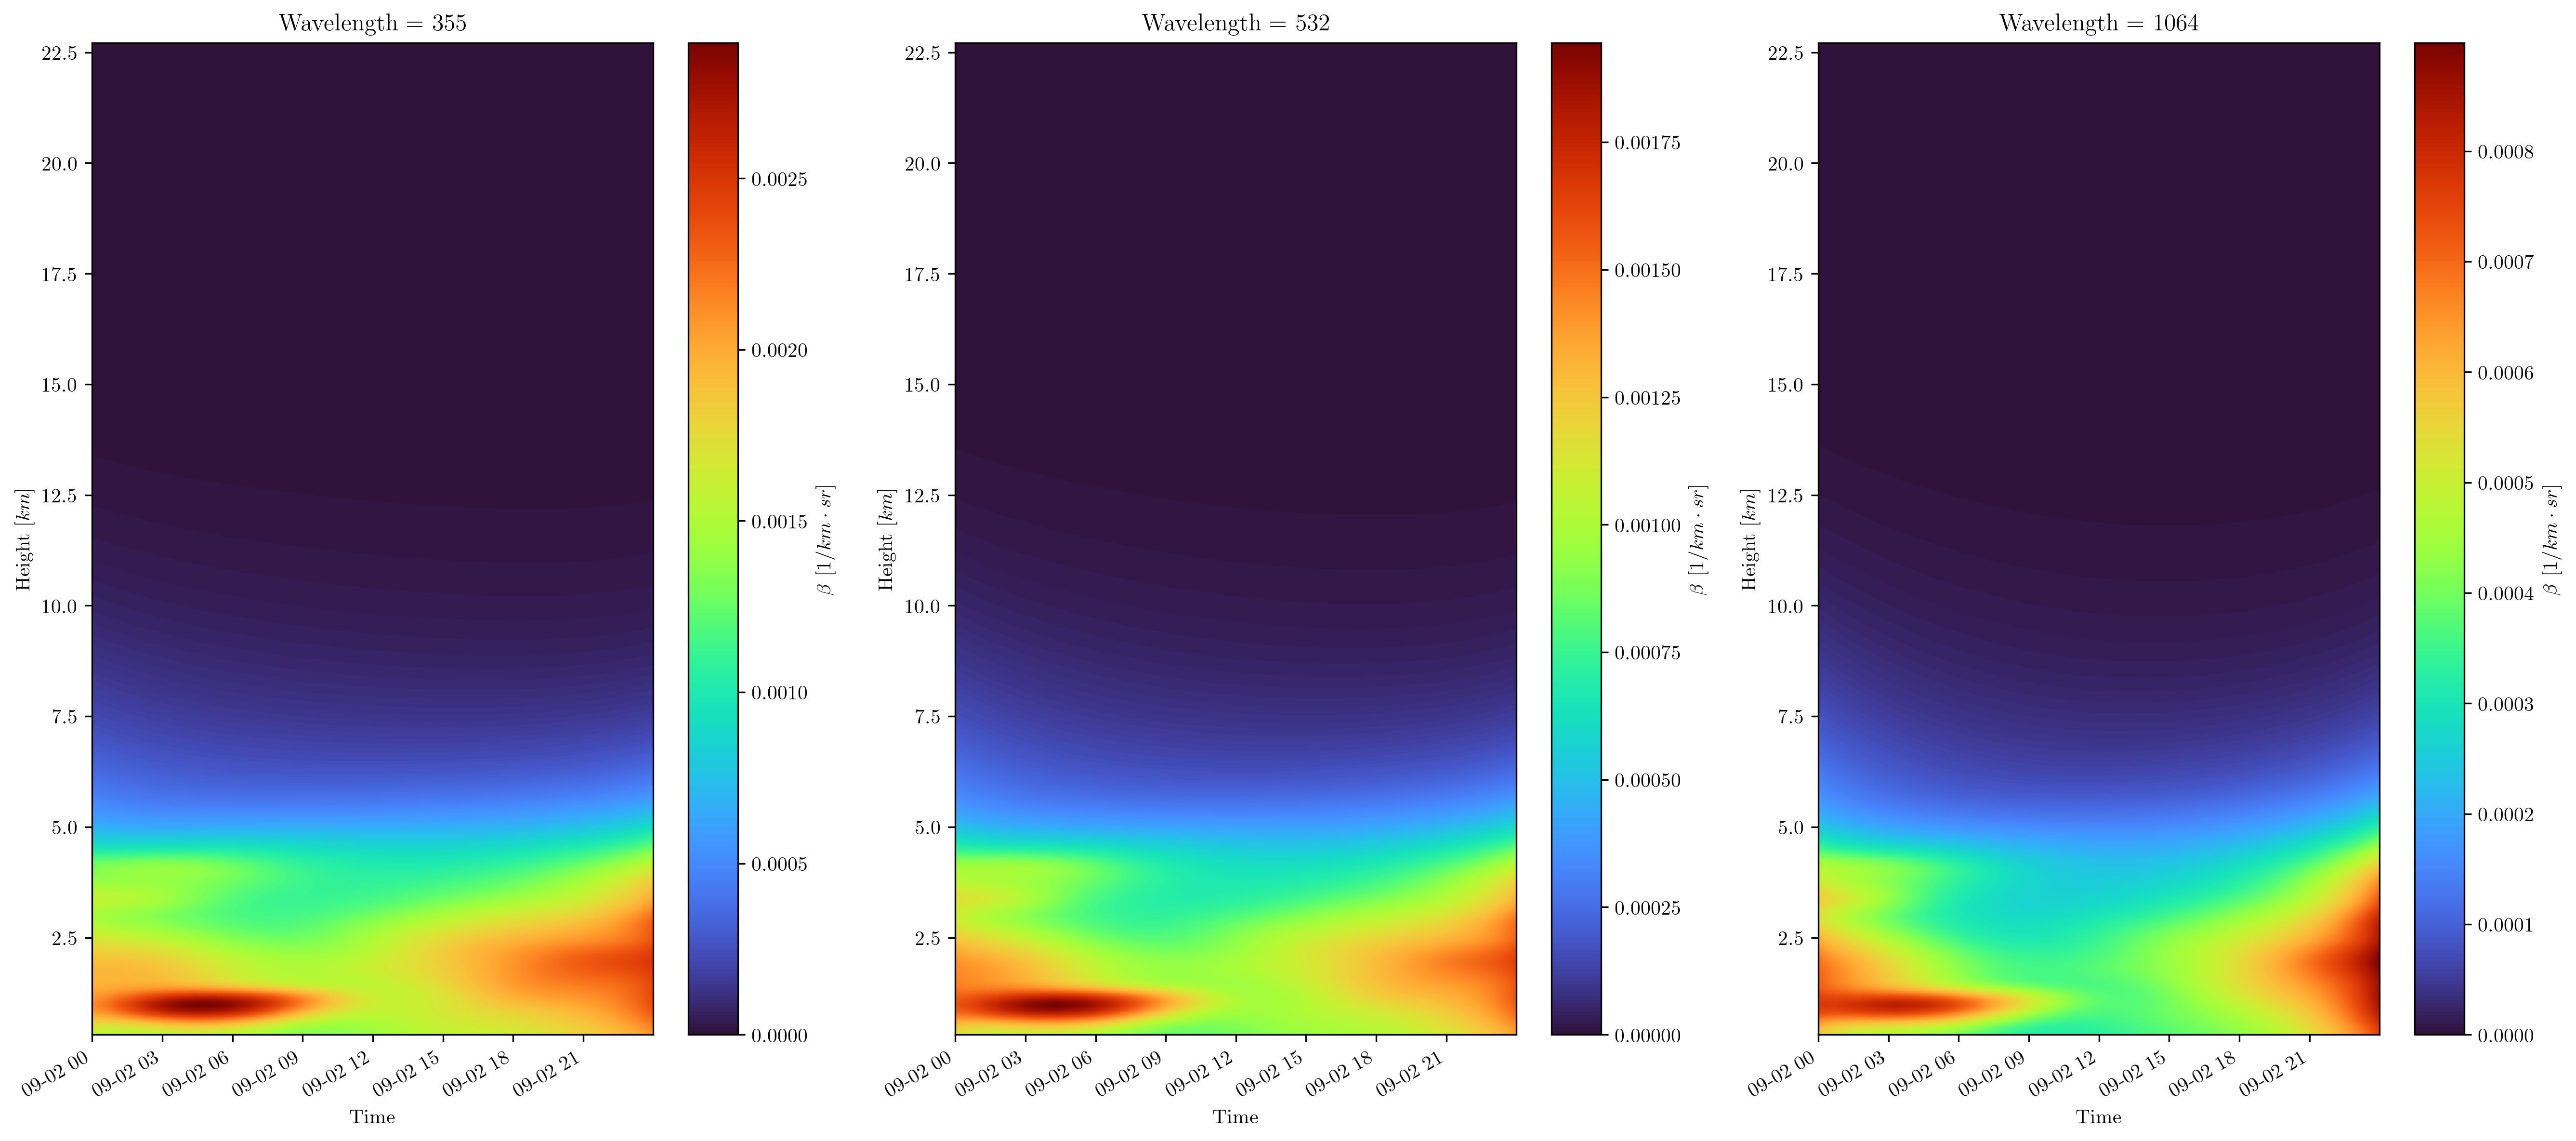

In [73]:
if PLOT_RESULTS:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
    for wavelength,ax in zip(ds_aer.Wavelength.values,axes.ravel()):
        ds_aer.beta.sel(Wavelength=wavelength).plot(ax= ax,cmap='turbo')
    plt.tight_layout()
    plt.show()

TODOS
1. Adapt the following variable to have dimension of Time : ang_532_1064, ang_355_532, LR


Save the aerosols dataset

In [74]:
save_generated_dataset(station, ds_aer, data_source ='aerosol' , save_mode='single')

['D:\\data_haifa\\GENERATION\\aerosol_dataset\\2017\\09\\2017_09_02_Haifa_generated_aerosol.nc']

### Show relative ratios between aerosols and molecular backscatter

In [75]:
EXPLORE_GEN_DAY = False
if EXPLORE_GEN_DAY:
    mol_month_folder = prep.get_month_folder_name( station.molecular_dataset,cur_day)
    nc_mol =  fr"{cur_day.strftime('%Y_%m_%d')}_{station.location}_molecular.nc"
    ds_mol = prep.load_dataset(os.path.join(mol_month_folder,nc_mol))
    ratio_beta = ds_aer.beta/(ds_mol.beta+ds_aer.beta)
    ratio_beta.where(ratio_beta<0.1).plot(x='Time',y='Height',row='Wavelength',
                    cmap = 'turbo_r',figsize=(10,10) ,sharex=True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(timeformat)
    ax.xaxis.set_tick_params(rotation=0)
    plt.show()

    ratio_sigma = ds_aer.sigma/(ds_mol.sigma+ds_aer.sigma)
    ratio_sigma.where(ratio_sigma<0.1).plot(x='Time',y='Height',row='Wavelength',
                    cmap = 'turbo_r',figsize=(10,10) ,sharex=True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(timeformat)
    ax.xaxis.set_tick_params(rotation=0)
    plt.show()

    atmosphere_ds.density.plot(x='Time',y='Height',row='Component',
                    cmap = 'turbo',figsize=(10,10) ,sharex=True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(timeformat)
    ax.xaxis.set_tick_params(rotation=0)
    plt.show()